# Assignment : Building ML Pipeline

## Package Importing & Setting

In [1]:
#Basic Package
import pandas as pd
import numpy as np 
import matplotlib as mpl
from matplotlib import rc
import datetime as dt
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')


#Graph, Font
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = fm.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


from tqdm import tqdm
from scipy.stats import gmean

In [2]:
cd C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\2차

C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\2차


## Feature Generation

In [3]:
tr_train = pd.read_csv("X_train.csv", sep=',', encoding='cp949');
tr_test = pd.read_csv("X_test.csv", sep=',', encoding='cp949');
tr= pd.concat([tr_train,tr_test])
gender = pd.read_csv("y_train.csv", sep=',', encoding='cp949')

In [4]:
features = []

#총구매액,구매건수,평균구매액,최대구매액
f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features.append(f)

#구매상품종류1,2,3
f = tr.groupby('cust_id').agg({
    'goods_id': [('구매상품종류1', lambda x: x.nunique())],
    'gds_grp_nm': [('구매상품종류2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('구매상품종류3', lambda x: x.nunique())]
})
f.columns = f.columns.droplevel()
f=f.reset_index()
features.append(f)

#내점일수,구매주기,주말방문비율,계절별구매비율
f = tr.groupby('cust_id')['tran_date'].agg([
    ('내점일수',lambda x: x.str[:10].nunique()),
    ('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique())),
    ('주말방문비율', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4)),
    ('봄-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()
features.append(f)

#환불금액,환불건수
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([
    ('환불금액', lambda x: x.sum() * -1),
    ('환불건수', np.size)
]).reset_index()
features.append(f)

# 내점당구매액 = 총구매액 / 내점일수, 내점당 구매액, 구매건수
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "내점당구매액"})
features.append(f)
f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "내점당구매건수"})
features.append(f)

# 최근 n개월의 구매금액/건수
for m in [3,6,12]:
    start = str(pd.to_datetime(tr.tran_date.max()) - pd.offsets.MonthBegin(m))
    f = tr.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
        (f'최근{m}개월_구매금액', np.sum), 
        (f'최근{m}개월_구매건수', np.size)
    ]).reset_index()
    features.append(f)

#구매추세패턴
is_1H = pd.to_datetime(tr['tran_date']).dt.month.isin([1,2,3,4,5,6])
is_1H = is_1H.map({True:-1,False:1})
tr_amount=tr['amount']
tr['amount*']= is_1H*tr_amount
f = tr.groupby('cust_id')['amount*'].agg([('구매추세패턴',lambda x: x.sum()>0)]).reset_index()

features.append(f)

#가격선호도
tr_onlyP = tr[tr.amount > 0]

bins = [0, 20000, 100000, 1000000, 4000000, np.inf] 

tr_onlyP['amount_level'] = pd.cut(tr_onlyP['amount'],bins=bins,
                                  labels=['~20,000','20,000~100,000','100,000~1,000,000','1,000,000~4,000,000','4,000,000~'])

f = tr_onlyP.groupby('cust_id')['amount_level'].agg([
    ('가격선호도',lambda x: x.mode().max())]).reset_index()

features.append(f)

#시즌선호도
tr['tran_month'] = pd.to_datetime(tr['tran_date']).dt.month
tr_onlyP = tr[tr.amount > 0]
monthly_amount = pd.pivot_table(tr_onlyP,values='amount',columns ='tran_month',aggfunc=sum)/tr.cust_id.nunique()
f = pd.pivot_table(tr_onlyP,values='amount',index='cust_id',columns ='tran_month',aggfunc=sum).fillna(0)

monthly_amount['성수기'] = monthly_amount.sort_values('amount',axis=1,ascending=False).iloc[0,0:3].sum()/3
monthly_amount['비수기'] = monthly_amount.sort_values('amount',axis=1,ascending=False).iloc[0,-3:].sum()/3
monthly_amount = monthly_amount.drop(range(1,13),axis=1)

f['성수기'] = f.iloc[:,-3:].sum(axis=1)/3/monthly_amount.iloc[0,0]
f['비수기'] = f.iloc[:,[2,6,8]].sum(axis=1)/3/monthly_amount.iloc[0,1]
f = f.drop(range(1,13),axis=1)
f['시즌선호도'] = f['성수기'] / (f['비수기']+0.01)
f.columns.name = None
f = f.drop(['성수기','비수기'],axis=1).reset_index()

features.append(f)

#휴면/이탈여부
tr['tran_dt'] = pd.to_datetime(tr.tran_date, format = '%Y-%m-%d')
tmp = tr.drop_duplicates(['cust_id','tran_dt'])
trcycle=[]

for i in range(3500):
    tr_id=tmp[tmp['cust_id']==i]
    cusid_dt_list = list(tr_id['tran_dt'])
    
    for j in range(len(cusid_dt_list)-1):
        
        Tdelta = abs(cusid_dt_list[j] - cusid_dt_list[j+1])
        Tdelta = Tdelta / timedelta (days=1)
        trcycle.append((i,Tdelta))

cusid_cycles=pd.DataFrame(trcycle, columns=['cust_id','cycle'])

tmp1 = cusid_cycles.groupby('cust_id')['cycle'].agg([('longest_gap',lambda x: x.max())]).reset_index()

tmp2 = tr.groupby('cust_id')['tran_date'].agg([("gap_lastV_lastD",lambda x: dt.datetime(2007,12,31) - pd.to_datetime(x, format='%Y-%m-%d').max())]).reset_index()

compare = pd.merge(tmp2,tmp1,on='cust_id',how='left').set_index('cust_id')
compare['gap_lastV_lastD']= compare['gap_lastV_lastD'] / timedelta (days=1)
compare['longest_gap']= compare['longest_gap'].fillna(0)

a = compare['gap_lastV_lastD']>=compare['longest_gap']
b = compare['gap_lastV_lastD']<=compare['longest_gap']
compare['휴면기간'] = compare['longest_gap']*b + compare['gap_lastV_lastD']*a
compare['휴면(이탈)여부'] = compare['휴면기간'] >= 90

f = compare.drop(['gap_lastV_lastD','longest_gap','휴면기간'],axis=1).reset_index()

features.append(f)

#베스트셀러상품군 상품별 총 판매액수,건수,여부
sales_summary = tr.groupby('gds_grp_mclas_nm')['amount'].agg([
    ('총판매액',np.sum), 
    ('판매건수', np.size)]).reset_index()
#총판매액 기준 탑10 베스트셀러 상품 리스트
top10_amount = sales_summary.sort_values(by=['총판매액'],
                                         axis=0,ascending=False).iloc[:,0:2].head(10)['gds_grp_mclas_nm']
top10_amount = list(top10_amount)
#판매건수 기준 탑10 베스트셀러 상품 리스트

top10_sales = sales_summary.drop(6,axis=0).sort_values(by=['판매건수'],
                                                       axis=0,ascending=False).iloc[:,[0,2]].head(10)['gds_grp_mclas_nm']
top10_sales = list(top10_sales)

tr_top10_amount = tr.loc[tr['gds_grp_mclas_nm'].isin(top10_amount),:]
tr_top10_sales = tr.loc[tr['gds_grp_mclas_nm'].isin(top10_sales),:]

tmp=[]
for i in range(10):
    f = tr.loc[tr['gds_grp_mclas_nm']==top10_amount[i],:]\
    .groupby('cust_id')['amount']\
    .agg([('%s품목총구매액'%(top10_amount[i]),np.sum)]).reset_index()
    tmp.append(f)
    
f = pd.DataFrame({'cust_id': tr.cust_id.unique()})
for df in tmp :
    f = pd.merge(f, df, how='left')
f= f.fillna(0)

features.append(f)


tmp=[]
for i in range(10):
    f = tr.loc[tr['gds_grp_mclas_nm']==top10_sales[i],:]\
    .groupby('cust_id')['amount']\
    .agg([('%s품목구매건수'%(top10_sales[i]),np.size)]).reset_index()
    tmp.append(f)

f = pd.DataFrame({'cust_id': tr.cust_id.unique()})    
for df in tmp :
    f = pd.merge(f, df, how='left')
f= f.fillna(0)

features.append(f)

tmp=[]
for i in range(10):
    f = tr.loc[tr['gds_grp_mclas_nm']==top10_sales[i],:]\
    .groupby('cust_id')['amount']\
    .agg([('%s품목구매여부'%(top10_sales[i]),lambda x: np.size(x)>0)]).reset_index()
    tmp.append(f)    

f = pd.DataFrame({'cust_id': tr.cust_id.unique()})
for df in tmp :
    f = pd.merge(f, df, how='left')
f = f.fillna(False)

features.append(f)

#주구매상품
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features.append(f)

#주구매지점
f = tr.groupby('cust_id')['store_nm'].agg([
    ('주구매지점', lambda x: x.value_counts().index[0])
]).reset_index()
features.append(f)

#상품별구매순서
food =['건강식품','가공식품','기타','농산물','수산품','육류','젓갈/반찬','주류','차/커피','축산가공']
housing = ['문구/팬시','일용잡화','주방용품','생활잡화','침구/수예','가구','소형가전','대형가전','식기','주방가전','악기','통신/컴퓨터','전자/전기']
fashion = ['화장품','골프','섬유잡화','피혁잡화','스포츠','캐주얼','커리어','아동','교복','구두','기타의류','남성 캐주얼','셔츠','남성 트랜디','남성정장','란제리/내의','멀티(아울렛)']
luxury = ['디자이너','명품','모피/피혁','보석','시티웨어','트래디셔널','준보석/시계','액세서리']

def return_class (item):
    if item in food :
        return 'Food'
    elif item in housing :
        return 'housing'
    elif item in fashion :
        return 'fashion'
    elif item in luxury :
        return 'luxury'

tr['M_class'] = tr.gds_grp_mclas_nm.apply(return_class)

class_tr = pd.pivot_table(tr,index='cust_id',columns='M_class',values='amount',aggfunc=np.size).fillna(0)

order_list = []
for i in range(len(class_tr)):
    order = class_tr.iloc[i,:].sort_values(ascending=False)
    order_list.append(list(order.index))

class_tr['상품(군)별구매순서'] = order_list
class_tr.columns.name = None

class_tr = class_tr.drop(['Food','fashion','luxury','housing'],axis=1).reset_index()
class_tr

f0 =tr.groupby('cust_id')['amount'].agg([('구매건수',np.size)])
f0 = f0[f0['구매건수'] >= 5]

f = pd.merge(f0,class_tr,on='cust_id',how='left').drop(['구매건수'],axis=1)
f['상품(군)별구매순서'] = f['상품(군)별구매순서'].apply(lambda x : '-'.join(x))
features.append(f)

#구매시환불비율
tr_refund=tr[tr['amount']<0]
refund = tr_refund.groupby('cust_id')['amount'].agg([ 
    ('환불건수', np.size)]).reset_index()
purchase = tr.groupby('cust_id')['amount'].agg([ 
    ('구매건수', np.size)]).reset_index()
f = pd.merge(purchase,refund,on='cust_id', how='left')

f['구매시환불비율']=f['환불건수']/f['구매건수']
f=f.fillna(0).drop(['구매건수','환불건수'],axis=1)

features.append(f)

#최장휴면일수

tr['tran_dt'] = pd.to_datetime(tr.tran_date, format = '%Y-%m-%d')
tmp = tr.drop_duplicates(['cust_id','tran_dt'])
trcycle=[]

for i in range(3500):
    tr_id=tmp[tmp['cust_id']==i]
    cusid_dt_list = list(tr_id['tran_dt'])
    
    for j in range(len(cusid_dt_list)-1):
        
        Tdelta = abs(cusid_dt_list[j] - cusid_dt_list[j+1])
        Tdelta = Tdelta / timedelta (days=1)
        trcycle.append((i,Tdelta))

cusid_cycles=pd.DataFrame(trcycle, columns=['cust_id','cycle'])
tmp1 = cusid_cycles.groupby('cust_id')['cycle'].agg([('longest_gap',lambda x: x.max())]).reset_index()

tmp2 = tr.groupby('cust_id')['tran_date'].agg([("gap_lastV_lastD",lambda x: dt.datetime(2007,12,31) - pd.to_datetime(x, format='%Y-%m-%d').max())]).reset_index()

compare = pd.merge(tmp2,tmp1,on='cust_id',how='left').set_index('cust_id')
compare['gap_lastV_lastD']= compare['gap_lastV_lastD'] / timedelta (days=1)
compare['longest_gap']= compare['longest_gap'].fillna(0)

a = compare['gap_lastV_lastD']>=compare['longest_gap']
b = compare['gap_lastV_lastD']<=compare['longest_gap']
compare['최장휴면일수'] = compare['longest_gap']*b + compare['gap_lastV_lastD']*a
f = compare.drop(['gap_lastV_lastD','longest_gap'],axis=1).reset_index()

features.append(f)

#행사상품 구매건수,총액
tr_event = tr[tr.gds_grp_nm.str.contains('행사')]
f = tr_event.groupby('cust_id')['amount']\
.agg([('행사상품구매건수',np.size),('행사상품구매총액',np.sum)]).reset_index()

features.append(f) 

#주구매요일
tr['tran_weekday'] = pd.to_datetime(tr['tran_date'], format='%Y-%m-%d').dt.dayofweek
tr['tran_weekday'] = tr['tran_weekday'].map({0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'})
tr_purchase = tr[tr.amount>0]

df1 = tr_purchase.groupby('cust_id')['amount'].agg([ 
    ('구매건수', np.size)
]).reset_index()

df2 = tr_purchase.groupby(['cust_id','tran_weekday'])['amount'].agg([ 
    ('sum_amount_byweekday', lambda x: np.sum(x))]).reset_index()


df3 = df2.groupby('cust_id')['sum_amount_byweekday'].agg([
    ('주구매요일',lambda x: np.max(x))]).reset_index()

f = pd.merge(left=df3, right=df1, how='left', on='cust_id', sort=False)

f = f[f['구매건수']>5]

f = pd.merge(left=f, right=df2, how='left', \
                  left_on=['cust_id','주구매요일'], right_on = ['cust_id','sum_amount_byweekday'], sort=False).drop_duplicates(['cust_id','sum_amount_byweekday'])
f = f.drop(columns= ['주구매요일','구매건수','sum_amount_byweekday'])
f = f.rename(columns={'tran_weekday':'주구매요일'})

features.append(f)

#주구매계절
#tr['tran_month'] = tr['tran_date'].apply(lambda x: pd.to_datetime(x[:10], format='%Y-%m-%d').month)
tr['tran_season'] = tr['tran_month']\
.map({1:'겨울',2:'겨울',3:'봄',4:'봄',5:'봄',6:'여름',7:'여름',8:'여름',9:'가을',10:'가을',11:'가을',12:'겨울'})

df1 = tr.groupby('cust_id')['amount'].agg([ 
    ('구매건수', np.size)
]).reset_index()

df2 = tr.groupby(['cust_id','tran_season'])['amount'].agg([ 
    ('sum_amount_byseason', lambda x: np.sum(x))]).reset_index()


df3 = df2.groupby('cust_id')['sum_amount_byseason'].agg([
    ('시즌선호도',lambda x: np.max(x))]).reset_index()

f = pd.merge(left=df3, right=df1, how='left', on='cust_id', sort=False)
f = f[f['구매건수']>5]
f = pd.merge(left=f, right=df2, how='left', \
                  left_on=['cust_id','시즌선호도'], right_on = ['cust_id','sum_amount_byseason'], sort=False)
f = f.drop(columns= ['시즌선호도','구매건수','sum_amount_byseason'])
f = f.rename(columns={'tran_season':'주구매계절'})

features.append(f)



#특징상품구매비율
feature_goods =['보석', '시티웨어', '침구/수예', '디자이너', '란제리/내의', '모피/피혁', '커리어', '액세서리', '농산물', '화장품']

f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('특징상품-구매비율', lambda x: np.mean( x.isin(feature_goods))),
    ]).reset_index()
features.append(f)

#남성, 여성상품 구매건수비율, 총액비율
tr_gender = pd.merge(tr_train, gender, on='cust_id',how='left')
tr_gender_p = tr_gender[tr_gender.amount>=0]

product_gender_sum = pd.pivot_table(tr_gender_p, index='gds_grp_nm', columns='gender', values='amount',
                                    aggfunc=np.size,fill_value=0).reset_index()
product_gender_sum.columns = ['goods_type','woman','man']
product_gender_sum['man_woman_ratio'] = product_gender_sum.man / (product_gender_sum.woman + 0.1)

product_man_sum = product_gender_sum[product_gender_sum.man_woman_ratio>=0.65]
product_woman_sum = product_gender_sum[product_gender_sum.man_woman_ratio<=0.36]
W_goodstype = product_woman_sum.goods_type.tolist()
M_goodstype = product_man_sum.goods_type.tolist()

f = tr.groupby('cust_id')['gds_grp_nm'].agg([
    ('남성상품구매건수비율', lambda x: np.mean( x.isin(M_goodstype))),
    ('여성상품구매건수비율', lambda x: np.mean( x.isin(W_goodstype)))
    ]).reset_index()
features.append(f)

total_purchase = tr.groupby('cust_id')['amount'].agg([('총구매액',np.sum)]).reset_index()

data_mangoods = tr.loc[tr['gds_grp_nm'].isin(M_goodstype)]
data_mangoods_ratio = data_mangoods.groupby('cust_id')['amount'].agg([('남성상품구매총액비율',np.size)]).reset_index()

data_womangoods = tr.loc[tr['gds_grp_nm'].isin(W_goodstype)]
data_womangoods_ratio = data_womangoods.groupby('cust_id')['amount'].agg([('여성상품구매총액비율',np.size)]).reset_index()

f = pd.merge(total_purchase,data_mangoods_ratio, on='cust_id', how='left').fillna(0)
f = pd.merge(f,data_womangoods_ratio, on='cust_id', how='left').fillna(0)
f.iloc[:,1:] = f.iloc[:,1:].div(f['총구매액'],axis=0)
f = f.drop(columns='총구매액')
features.append(f)

In [5]:
cd C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\3차\n차제출()_0527

C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\3차\n차제출()_0527


In [6]:
data = pd.DataFrame({'cust_id': tr.cust_id.unique()})
for f in features :
    data = pd.merge(data, f, how='left')

In [7]:
cat_features = list(data.select_dtypes(include=['object']).columns)
num_features = [c for c in data.columns.tolist() if c not in cat_features]

data[cat_features] = data[cat_features].fillna('예외')
data[num_features] = data[num_features].fillna(0)
data.to_csv('Raw_feature_continuos+categorical_before_Encoding.csv',encoding='cp949')
#if len(cat_features) > 0:
    #data_eda = pd.concat([data[num_features], pd.get_dummies(data[cat_features])], axis=1)

train = data[data.cust_id.isin(set(tr_train.cust_id))]
test = data[data.cust_id.isin(set(tr_test.cust_id))]
data_eda = pd.merge(train, gender, how='left')

# Part 1. EDA & Categorization

* training set 의 성별 분포 확인: 여성이 62.4%(2,184명), 남성이 37.6%(1,316명)인 성별 분포를 보임

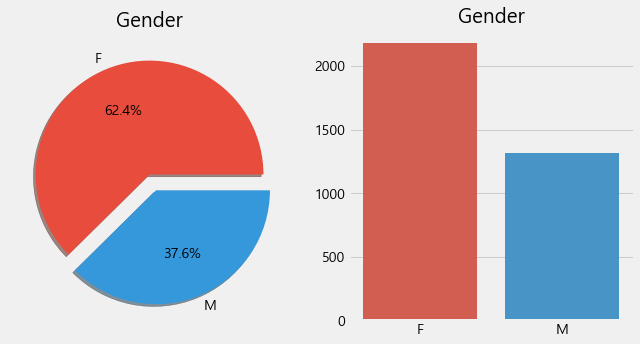

In [8]:
f,ax=plt.subplots(1, 2, figsize=(10,5))
data_eda['gender'].value_counts().plot.pie(explode=[0,0.15], autopct='%1.1f%%', ax=ax[0], shadow=True, colors=["#e74c3c","#3498db"], labels=['F','M'])
ax[0].set_title('Gender')
ax[0].set_ylabel('')
sns.countplot('gender', data=data_eda, ax=ax[1], palette=["#e74c3c","#3498db"])
ax[1].set_title('Gender')
ax[1].set_xlabel('')
ax[1].set_xticklabels(['F','M'])
ax[1].set_ylabel('')
plt.show()

## Feature Analysis (CATEGORICAL)

### 주구매상품

* 대부분의 상품군에서 여성의 구매비율이 높게 나타났다.  
* 남성캐주얼, 남성정장, 생활잡화, 악기, 주류, 주방가전 에서 남성 비율이 높게 나타났다.

In [9]:
data_eda.groupby('주구매상품')['gender'].agg([('고객수',np.size)]).reset_index().sort_values('고객수').set_index('주구매상품')

,고객수
주구매상품,
준보석/시계,2
악기,2
남성 트랜디,2
소형가전,4
보석,4
액세서리,5
통신/컴퓨터,5
주류,7
란제리/내의,8


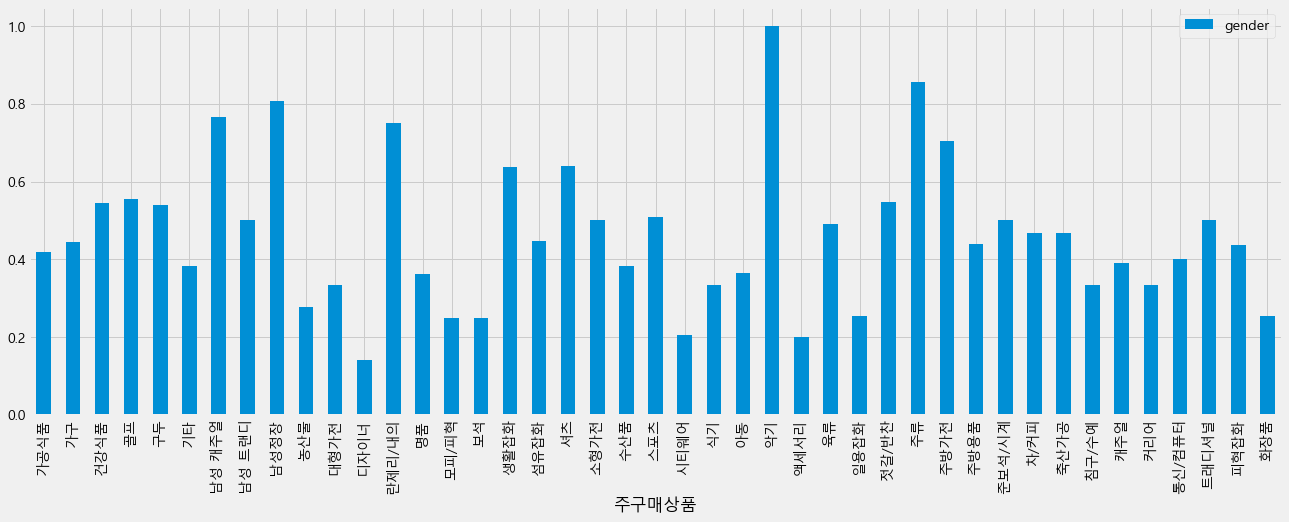

In [10]:
data_eda[['주구매상품','gender']].groupby(['주구매상품']).mean().plot.bar(figsize=(20,7))
plt.show()

### 가격선호도

* 1,000,000원 ~ 4,000,000원 이상 구간에서 남성 고객이 비율이 비교적 높게 관찰되었다.

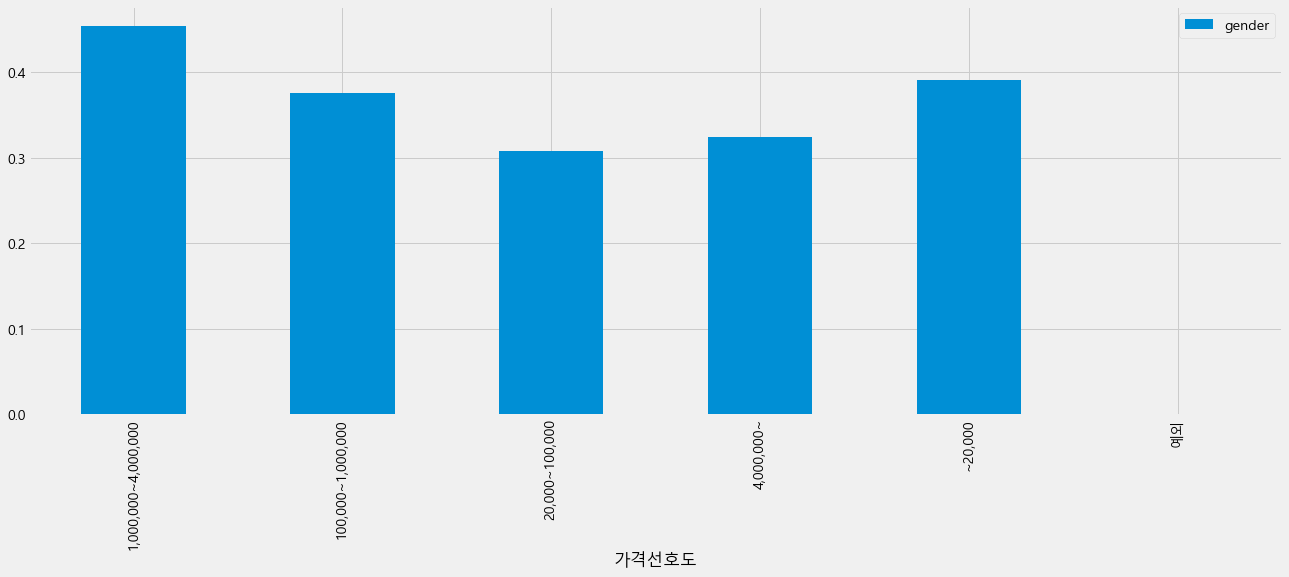

In [11]:
data_eda[['가격선호도','gender']].groupby(['가격선호도']).mean().plot.bar(figsize=(20,7))
plt.show()

### 주구매지점

* 대부분의 지점에서 비슷한 성별분포를 보인다.
* 강남, 상인, 창원 (남성), 대구, 전주 (여성)에서 경향성이 보이는 것 같지만, 강남을 제외하고는 데이터 수가 매우 적게 관찰되었다.
* 유의미한 feature가 아니라고 판단, 삭제할 예정이다.

In [12]:
data_eda.groupby('주구매지점')['gender'].agg([('고객수',np.size)]).reset_index().sort_values('고객수').set_index('주구매지점').T


주구매지점,상인점,창원점,전주점,울산점,대구점,센텀시티점,포항점,안양점,인천점,관악점,...,청량리점,노원점,광주점,강남점,일산점,영등포점,부산본점,분당점,잠실점,본 점
고객수,1,4,5,6,7,7,11,29,34,45,...,87,91,114,151,200,242,245,439,462,1074


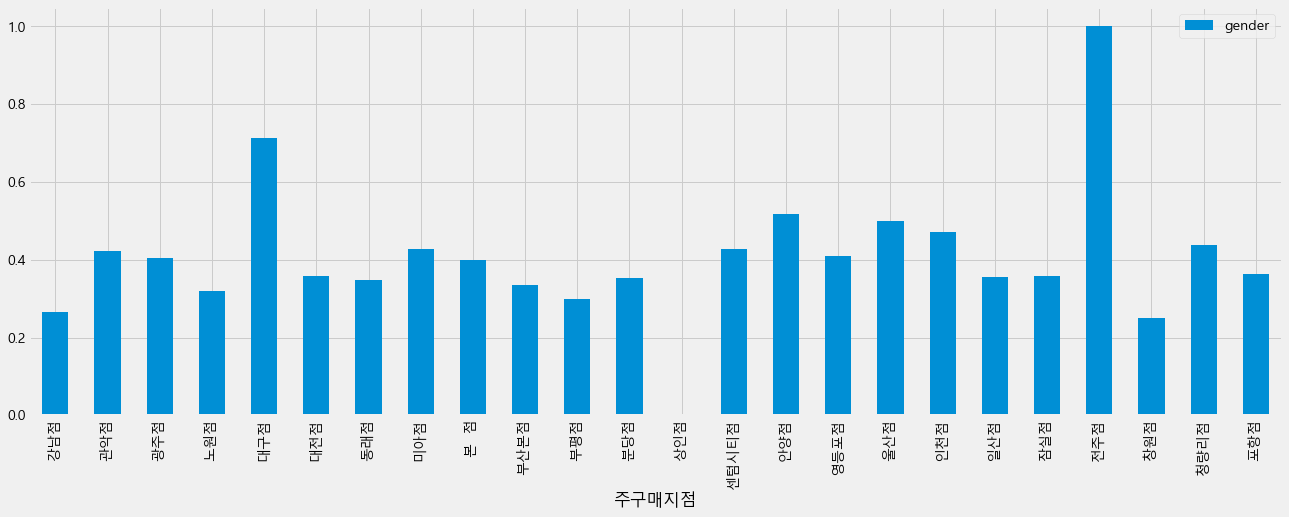

In [13]:
data_eda[['주구매지점','gender']].groupby(['주구매지점']).mean().plot.bar(figsize=(20,7))
plt.show()

### 상품별구매순서

* 구매우선순위가 luxury가 우선인 경우 대부분 여성 고객으로 나타났다.(291건)  
* Food-Fashion-luxury-housing 의 순서는 총 535건중 약 70%가 여성으로 나타났다.
* Food-Luxury-Fashoin-Housing 의 순서도 여성의 비율이 높게(약 20%) 나타났다 (274건)
* housing-fashion-luxury-Food, housing-luxury-Food-fashion 에서 높은 남성 비율을 보였으나 데이터 수가 너무 적어 의미가 없었다.
* 남성을 예측하는데 의미가 없는 변수라고 판단, 삭제할 예정이다.

In [14]:
data_eda.groupby('상품(군)별구매순서')['gender'].agg([('고객수',np.size)]).T

상품(군)별구매순서,Food-fashion-housing-luxury,Food-fashion-luxury-housing,Food-housing-fashion-luxury,Food-housing-luxury-fashion,Food-luxury-fashion-housing,Food-luxury-housing-fashion,fashion-Food-housing-luxury,fashion-Food-luxury-housing,fashion-housing-Food-luxury,fashion-housing-luxury-Food,...,housing-fashion-luxury-Food,housing-luxury-Food-fashion,housing-luxury-fashion-Food,luxury-Food-fashion-housing,luxury-Food-housing-fashion,luxury-fashion-Food-housing,luxury-fashion-housing-Food,luxury-housing-Food-fashion,luxury-housing-fashion-Food,예외
고객수,348,535,200,125,274,228,84,257,32,20,...,7,1,9,84,48,106,35,2,16,868


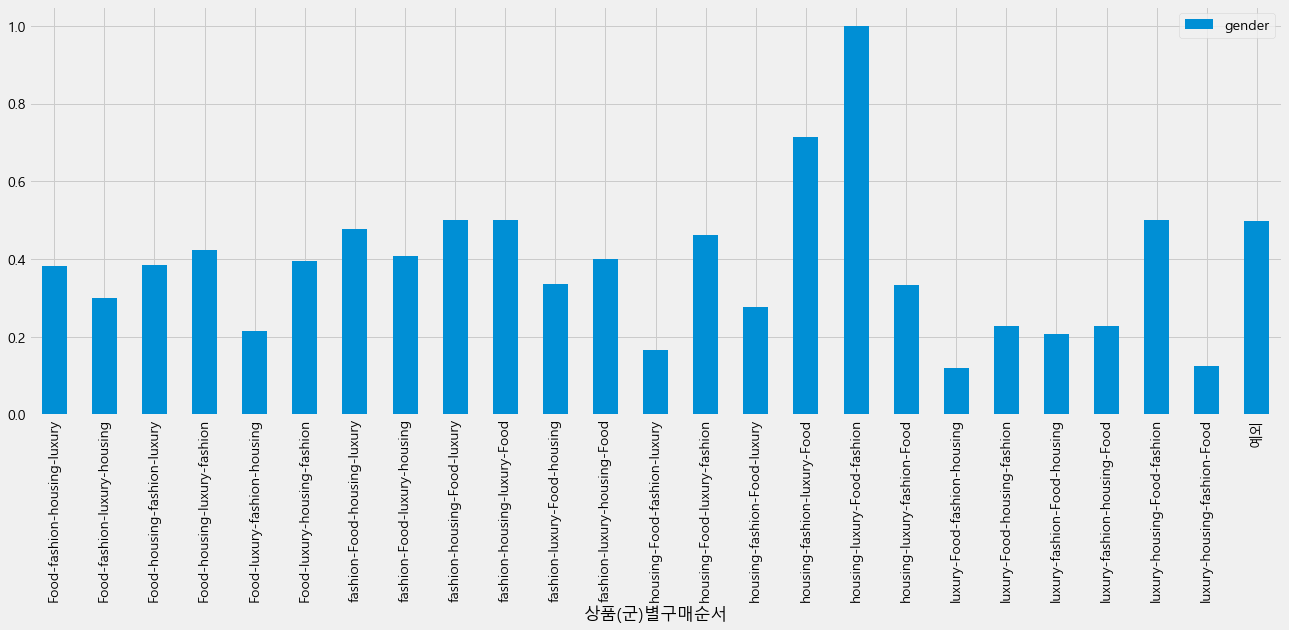

In [15]:
data_eda[['상품(군)별구매순서','gender']].groupby(['상품(군)별구매순서']).mean().plot.bar(figsize=(20,7))
plt.show()

### 주구매요일

* 주구매요일이 주중일 경우 여성일 확률이 높게 나타났다.   
* 트렌드가 뚜렷하지 않은 경우, 남성일 확률이 높게 나타났다.

In [16]:
arg_order = ['월','화','수','목','금','토','일','예외']
data_eda.groupby('주구매요일')['gender'].agg([('고객수',np.size)]).loc[arg_order].T

주구매요일,월,화,수,목,금,토,일,예외
고객수,206,288,301,330,519,428,419,1009


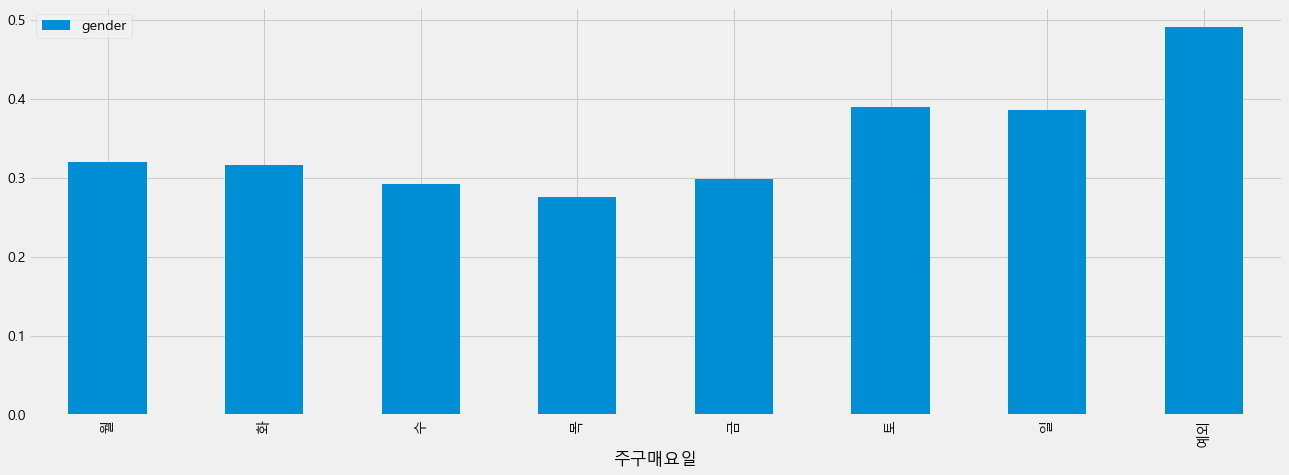

In [17]:
data_eda[['주구매요일','gender']].groupby(['주구매요일']).mean().loc[arg_order].plot.bar(figsize=(20,7))
plt.show()

### 주구매계절

* 주구매계절이 뚜렷하지 않을 경우 남성일 확률이 높게 나타났다. 

In [18]:
arg_order = ['봄', '여름', '가을','겨울','예외']
data_eda.groupby('주구매계절')['gender'].agg([('고객수',np.size)]).loc[arg_order].T

주구매계절,봄,여름,가을,겨울,예외
고객수,624,483,760,645,988


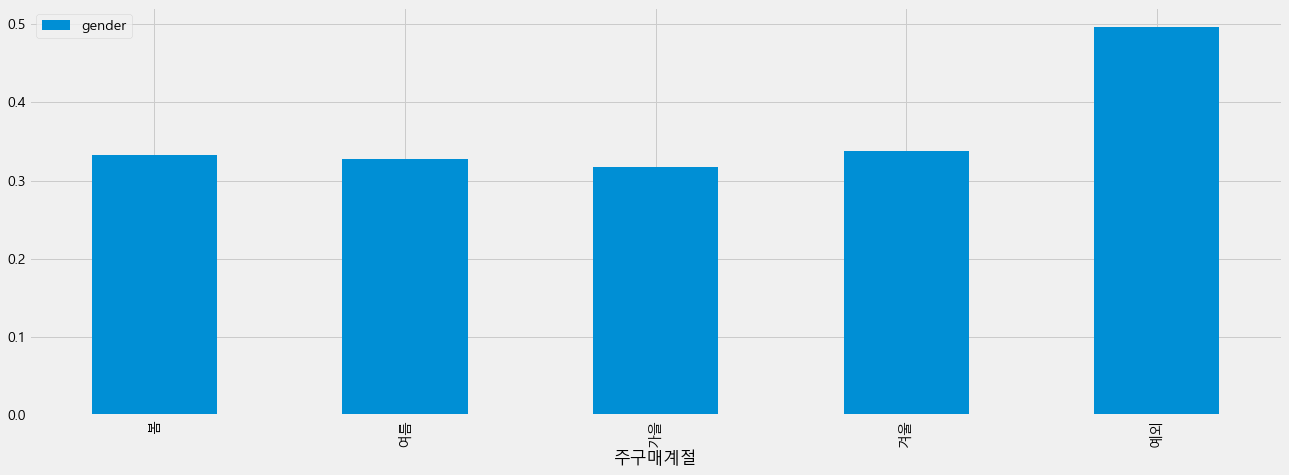

In [19]:
data_eda[['주구매계절','gender']].groupby(['주구매계절']).mean().loc[arg_order].plot.bar(figsize=(20,7))
plt.show()

## Analyzing The Features (Continuous)

In [20]:
train = pd.merge(train, gender, how='left')

* continuous feature는 binning을 통해 categorical feature로 변환하였다.  
* 이때 n분위의 경계값을 적절한 수치로 반올림하였다.  
* qcut을 이용한 n분위로 분할이 어려운 경우에는 적절한 분위로 나눌 수 있는 구간을 탐색하였다.  
* 또한 총구매액이 음수인 것과 같은 예외적인 그룹들은 따로 분리하였다.  

### **총구매액**

* 총구매액이 적을수록, 남성일 확률이 높게 나타났다.
* 총구매액이 음수인 경우는 별도의 그룹 '0'으로 분리하여, 이들은 전체적인 트렌드를 벗어난 예외인 것으로 따로 분류하였다. (모두 여성)

In [21]:
train['총구매액2'] = pd.qcut(train['총구매액'], 10)
train.groupby(['총구매액2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
총구매액2,
"(-52421520.001, 791579.0]",0.517143
"(791579.0, 2946440.0]",0.520000
"(2946440.0, 7058240.0]",0.488571
"(7058240.0, 14676000.0]",0.428571
"(14676000.0, 28222700.0]",0.382857
"(28222700.0, 49479620.0]",0.362857
"(49479620.0, 83269962.0]",0.300000
"(83269962.0, 142439226.0]",0.317143
"(142439226.0, 264019303.0]",0.240000


In [22]:
train['총구매액_cat'] = 0
train.loc[train['총구매액']<0,'총구매액_cat'] = 0
train.loc[(train['총구매액']>0) & (train['총구매액']<=3000000),'총구매액_cat'] = 1
train.loc[(train['총구매액']>3000000) & (train['총구매액']<=15000000),'총구매액_cat'] = 2
train.loc[(train['총구매액']>15000000) & (train['총구매액']<=50000000),'총구매액_cat'] = 3
train.loc[(train['총구매액']>50000000) & (train['총구매액']<=150000000),'총구매액_cat'] = 4
train.loc[train['총구매액']>150000000,'총구매액_cat'] = 5
train = train.drop(columns="총구매액2")

In [23]:
train.groupby('총구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,총구매액_cat,고객수
0,0,10
1,1,699
2,2,700
3,3,698
4,4,725
5,5,668


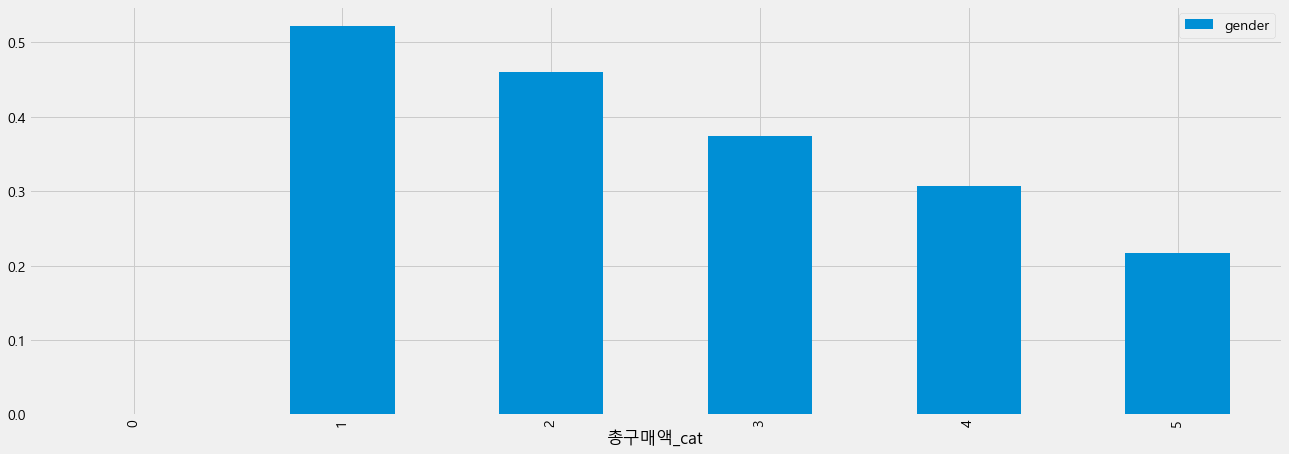

In [24]:
train[['총구매액_cat','gender']].groupby(['총구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [25]:
test['총구매액_cat'] = 0
test.loc[test['총구매액']<0,'총구매액_cat'] = 0
test.loc[(test['총구매액']>0) & (test['총구매액']<=3000000),'총구매액_cat'] = 1
test.loc[(test['총구매액']>3000000) & (test['총구매액']<=15000000),'총구매액_cat'] = 2
test.loc[(test['총구매액']>15000000) & (test['총구매액']<=50000000),'총구매액_cat'] = 3
test.loc[(test['총구매액']>50000000) & (test['총구매액']<=150000000),'총구매액_cat'] = 4
test.loc[test['총구매액']>150000000,'총구매액_cat'] = 5
test = test.drop(columns="총구매액")

### 구매건수 (Continuous)

* 구매건수가 적을수록 남성의 비율이 높게 나타났다.

In [26]:
train['구매건수2'] = pd.qcut(train['구매건수'], 10)
train.groupby(['구매건수2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
구매건수2,
"(0.999, 2.0]",0.514134
"(2.0, 3.0]",0.454054
"(3.0, 6.0]",0.474164
"(6.0, 11.0]",0.437126
"(11.0, 21.0]",0.428152
"(21.0, 35.0]",0.355114
"(35.0, 56.0]",0.344828
"(56.0, 90.0]",0.259366
"(90.0, 179.0]",0.223496


In [27]:
train['구매건수_cat'] = 0
train.loc[train['구매건수']<=3,'구매건수_cat'] = 0
train.loc[(train['구매건수']>3) & (train['구매건수']<=10),'구매건수_cat'] = 1
train.loc[(train['구매건수']>10) & (train['구매건수']<=35),'구매건수_cat'] = 2
train.loc[(train['구매건수']>35) & (train['구매건수']<=90),'구매건수_cat'] = 3
train.loc[train['구매건수']>90,'구매건수_cat'] = 4
train = train.drop(columns="구매건수2")

In [28]:
train.groupby('구매건수_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,구매건수_cat,고객수
0,0,751
1,1,611
2,2,745
3,3,695
4,4,698


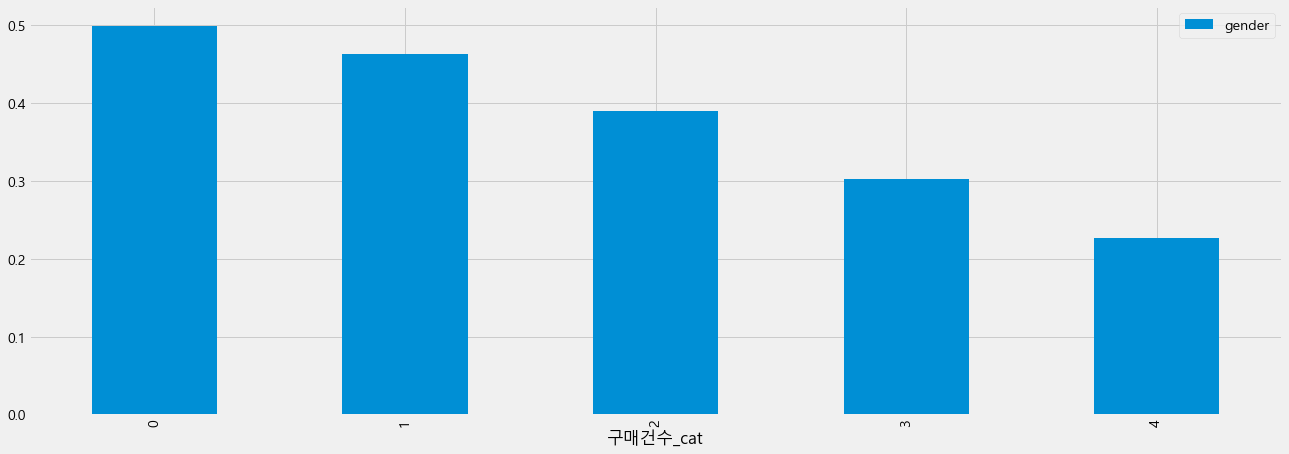

In [29]:
train[['구매건수_cat','gender']].groupby(['구매건수_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [30]:
test['구매건수_cat'] = 0
test.loc[test['구매건수']<=3,'구매건수_cat'] = 0
test.loc[(test['구매건수']>3) & (test['구매건수']<=10),'구매건수_cat'] = 1
test.loc[(test['구매건수']>10) & (test['구매건수']<=35),'구매건수_cat'] = 2
test.loc[(test['구매건수']>35) & (test['구매건수']<=90),'구매건수_cat'] = 3
test.loc[test['구매건수']>90,'구매건수_cat'] = 4
test = test.drop(columns="구매건수")

### 평균구매액 (Continuous)

* 평균구매액이 작을수록 남성의 비율이 높게 나타났다.
* 평균구매액이 음수인 경우는 별도의 그룹 '0'으로 분리하여, 이들은 전체적인 트렌드를 벗어난 예외인 것으로 따로 분류하였다. (모두 여성)

In [31]:
train['평균구매액2'] = pd.qcut(train['평균구매액'], 10)
train.groupby(['평균구매액2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
평균구매액2,
"(-2992000.001, 151535.4]",0.488571
"(151535.4, 361725.6]",0.397143
"(361725.6, 615590.5]",0.397143
"(615590.5, 918889.4]",0.348571
"(918889.4, 1274937.0]",0.348571
"(1274937.0, 1720611.2]",0.362857
"(1720611.2, 2309744.8]",0.374286
"(2309744.8, 3303730.4]",0.357143
"(3303730.4, 5403181.2]",0.317143


In [32]:
train['평균구매액_cat'] = 0
train.loc[train['평균구매액']<=0,'평균구매액_cat'] = 0
train.loc[(train['평균구매액']>0) & (train['평균구매액']<=350000),'평균구매액_cat'] = 1
train.loc[(train['평균구매액']>350000) & (train['평균구매액']<=900000),'평균구매액_cat'] = 2
train.loc[(train['평균구매액']>900000) & (train['평균구매액']<=1700000),'평균구매액_cat'] = 3
train.loc[(train['평균구매액']>1700000) & (train['평균구매액']<=3300000),'평균구매액_cat'] = 4
train.loc[train['평균구매액']>3300000,'평균구매액_cat'] = 5
train = train.drop(columns=["평균구매액","평균구매액2"])

In [33]:
train.groupby('평균구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,평균구매액_cat,고객수
0,0,10
1,1,675
2,2,695
3,3,706
4,4,712
5,5,702


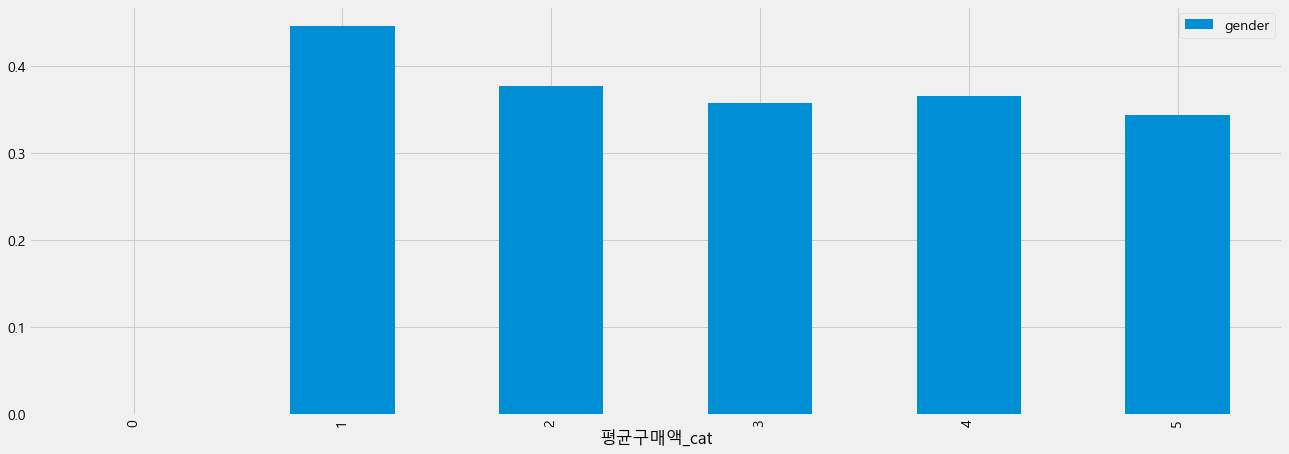

In [34]:
train[['평균구매액_cat','gender']].groupby(['평균구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [35]:
test['평균구매액_cat'] = 0
test.loc[test['평균구매액']<=0,'평균구매액_cat'] = 0
test.loc[(test['평균구매액']>0) & (test['평균구매액']<=350000),'평균구매액_cat'] = 1
test.loc[(test['평균구매액']>350000) & (test['평균구매액']<=900000),'평균구매액_cat'] = 2
test.loc[(test['평균구매액']>900000) & (test['평균구매액']<=1700000),'평균구매액_cat'] = 3
test.loc[(test['평균구매액']>1700000) & (test['평균구매액']<=3300000),'평균구매액_cat'] = 4
test.loc[test['평균구매액']>3300000,'평균구매액_cat'] = 5
test = test.drop(columns="평균구매액")

### 최대구매액 (Continuous)

* 최대구매액이 작을수록 남성의 비율이 높게 나타났다.
* 최대구매액이 음수인 경우는 별도의 그룹 '0'으로 분리하여, 이들은 전체적인 트렌드를 벗어난 예외인 것으로 따로 분류하였다. (여성, 1명)

In [36]:
train['최대구매액2'] = pd.qcut(train['최대구매액'], 10)
train.groupby(['최대구매액2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
최대구매액2,
"(-2992000.001, 584260.0]",0.534286
"(584260.0, 1907200.0]",0.525714
"(1907200.0, 3973380.0]",0.474286
"(3973380.0, 6500000.0]",0.394886
"(6500000.0, 9837000.0]",0.307471
"(9837000.0, 13750800.0]",0.365714
"(13750800.0, 19000000.0]",0.321937
"(19000000.0, 28124800.0]",0.303725
"(28124800.0, 48000000.0]",0.293785


In [37]:
train['최대구매액_cat'] = 0
train.loc[train['최대구매액']<=0,'최대구매액_cat'] = 0
train.loc[(train['최대구매액']>0) & (train['최대구매액']<=2000000),'최대구매액_cat'] = 1
train.loc[(train['최대구매액']>2000000) & (train['최대구매액']<=6500000),'최대구매액_cat'] = 2
train.loc[(train['최대구매액']>6500000) & (train['최대구매액']<=15000000),'최대구매액_cat'] = 3
train.loc[(train['최대구매액']>15000000) & (train['최대구매액']<=30000000),'최대구매액_cat'] = 4
train.loc[train['최대구매액']>30000000,'최대구매액_cat'] = 5
train = train.drop(columns=["최대구매액","최대구매액2"])

In [38]:
train.groupby('최대구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,최대구매액_cat,고객수
0,0,1
1,1,723
2,2,678
3,3,805
4,4,650
5,5,643


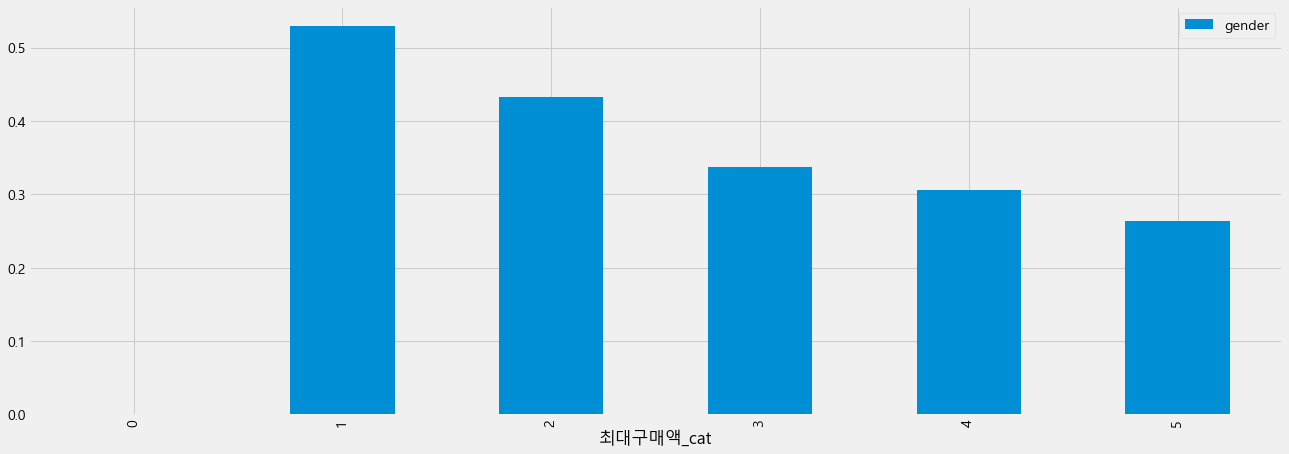

In [39]:
train[['최대구매액_cat','gender']].groupby(['최대구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [40]:
test['최대구매액_cat'] = 0
test.loc[test['최대구매액']<=0,'최대구매액_cat'] = 0
test.loc[(test['최대구매액']>0) & (test['최대구매액']<=2000000),'최대구매액_cat'] = 1
test.loc[(test['최대구매액']>2000000) & (test['최대구매액']<=6500000),'최대구매액_cat'] = 2
test.loc[(test['최대구매액']>6500000) & (test['최대구매액']<=15000000),'최대구매액_cat'] = 3
test.loc[(test['최대구매액']>15000000) & (test['최대구매액']<=30000000),'최대구매액_cat'] = 4
test.loc[test['최대구매액']>30000000,'최대구매액_cat'] = 5
test = test.drop(columns="최대구매액")

### 구매상품종류

* 구매상품종류에 대한 3개의 feature는 소,중,대분류의 개념으로 서로간의 상관관계가 높게 관찰되었다.  
* 따라서 구매종류1 feature만 사용하고, 나머지는 탈락시킬 예정이다.

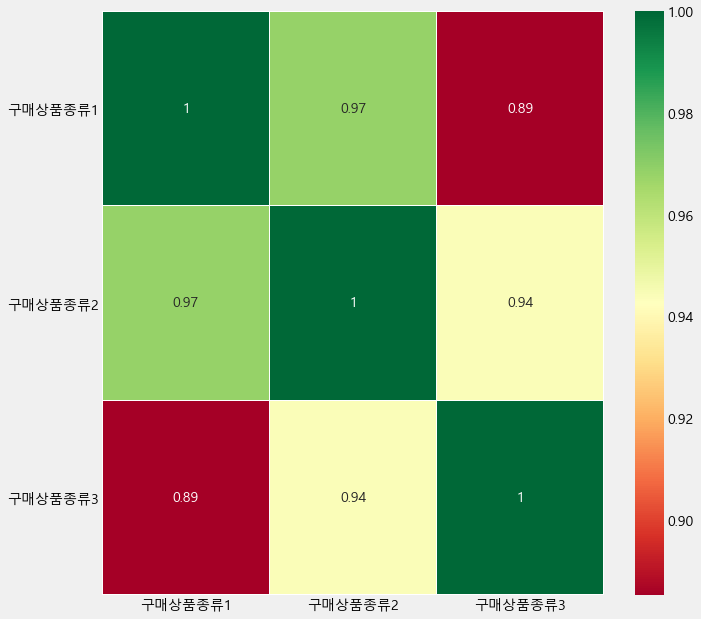

In [41]:
sns.heatmap(train[train.columns[[3,4,5]]].corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [42]:
train = train.drop(columns=["구매상품종류2","구매상품종류3"])
test = test.drop(columns=["구매상품종류2","구매상품종류3"])

### 구매상품종류1

* 구매상품종류(1)가 적을수록 남성의 비율이 높게 나타났다.

In [43]:
train['구매상품종류1_2'] = pd.qcut(train['구매상품종류1'], 5)
train.groupby(['구매상품종류1_2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
구매상품종류1_2,
"(0.999, 2.0]",0.503827
"(2.0, 7.0]",0.453505
"(7.0, 18.0]",0.367030
"(18.0, 39.0]",0.319708
"(39.0, 224.0]",0.216255


In [44]:
train['구매상품종류1_cat'] = 0
train.loc[train['구매상품종류1']<=2,'구매상품종류1_cat'] = 0
train.loc[(train['구매상품종류1']>2) & (train['구매상품종류1']<=10),'구매상품종류1_cat'] = 1
train.loc[(train['구매상품종류1']>10) & (train['구매상품종류1']<=20),'구매상품종류1_cat'] = 2
train.loc[(train['구매상품종류1']>20) & (train['구매상품종류1']<=40),'구매상품종류1_cat'] = 3
train.loc[train['구매상품종류1']>40,'구매상품종류1_cat'] = 4
train = train.drop(columns=["구매상품종류1","구매상품종류1_2"])

In [45]:
train.groupby('구매상품종류1_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,구매상품종류1_cat,고객수
0,0,784
1,1,906
2,2,524
3,3,618
4,4,668


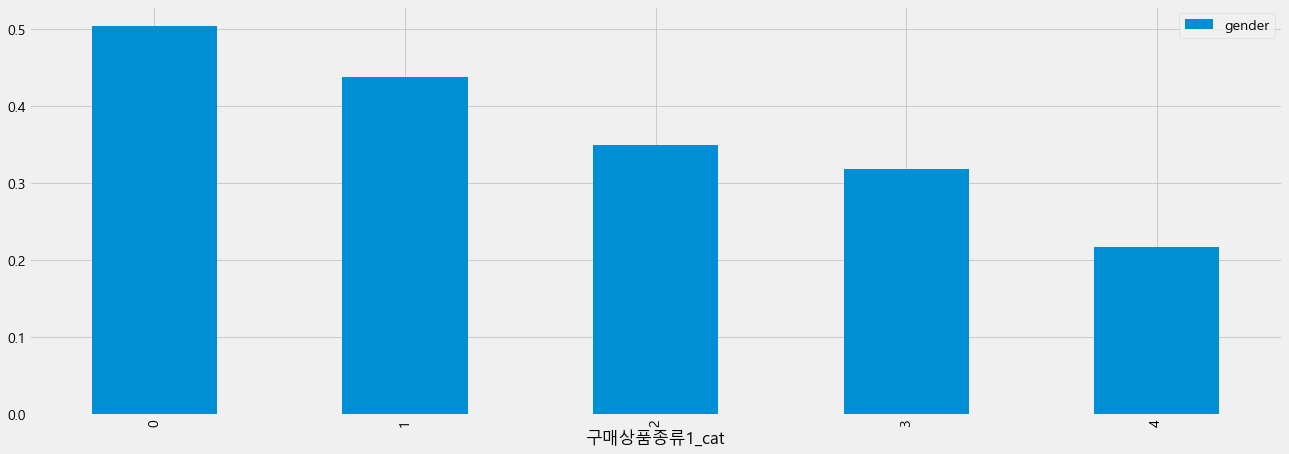

In [46]:
train[['구매상품종류1_cat','gender']].groupby(['구매상품종류1_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [47]:
test['구매상품종류1_cat'] = 0
test.loc[test['구매상품종류1']<=2,'구매상품종류1_cat'] = 0
test.loc[(test['구매상품종류1']>2) & (test['구매상품종류1']<=10),'구매상품종류1_cat'] = 1
test.loc[(test['구매상품종류1']>10) & (test['구매상품종류1']<=20),'구매상품종류1_cat'] = 2
test.loc[(test['구매상품종류1']>20) & (test['구매상품종류1']<=40),'구매상품종류1_cat'] = 3
test.loc[test['구매상품종류1']>40,'구매상품종류1_cat'] = 4
test = test.drop(columns="구매상품종류1")

### 내점일수

* 내점일수가 적을수록 남성의 비율이 높게 나타났다.

In [48]:
train['내점일수2'] = pd.qcut(train['내점일수'], 5)
train.groupby(['내점일수2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
내점일수2,
"(0.999, 2.0]",0.505387
"(2.0, 5.0]",0.416838
"(5.0, 13.0]",0.398319
"(13.0, 31.0]",0.291607
"(31.0, 285.0]",0.223343


In [49]:
train['내점일수_cat'] = 0
train.loc[train['내점일수']<=2,'내점일수_cat'] = 0
train.loc[(train['내점일수']>2) & (train['내점일수']<=7),'내점일수_cat'] = 1
train.loc[(train['내점일수']>7) & (train['내점일수']<=15),'내점일수_cat'] = 2
train.loc[(train['내점일수']>15) & (train['내점일수']<=30),'내점일수_cat'] = 3
train.loc[train['내점일수']>30,'내점일수_cat'] = 4
train = train.drop(columns=["내점일수", "내점일수2"])

In [50]:
train.groupby('내점일수_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,내점일수_cat,고객수
0,0,1021
1,1,653
2,2,552
3,3,550
4,4,724


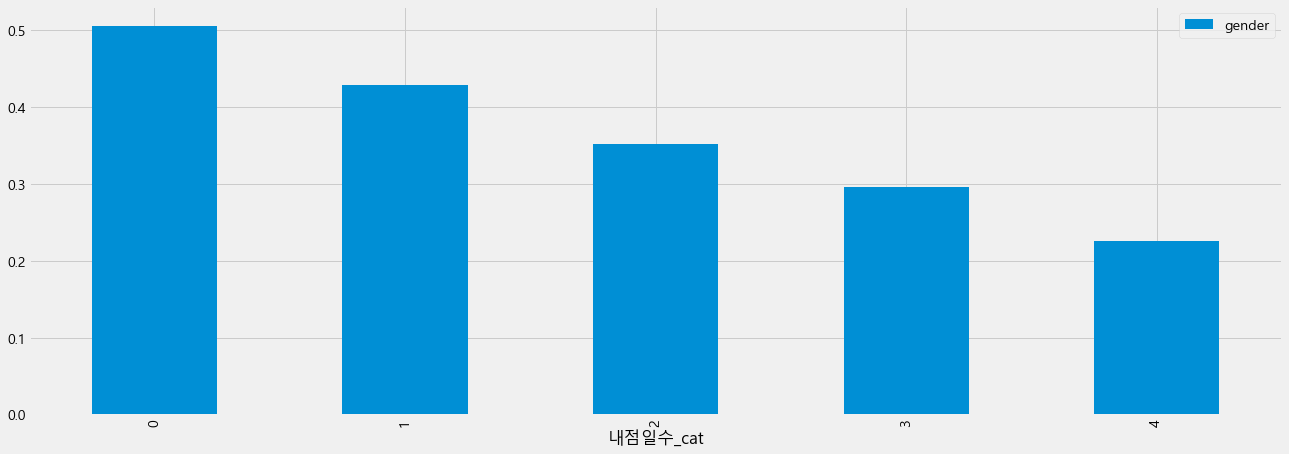

In [51]:
train[['내점일수_cat','gender']].groupby(['내점일수_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [52]:
test['내점일수_cat'] = 0
test.loc[test['내점일수']<=2,'내점일수_cat'] = 0
test.loc[(test['내점일수']>2) & (test['내점일수']<=7),'내점일수_cat'] = 1
test.loc[(test['내점일수']>7) & (test['내점일수']<=15),'내점일수_cat'] = 2
test.loc[(test['내점일수']>15) & (test['내점일수']<=30),'내점일수_cat'] = 3
test.loc[test['내점일수']>30,'내점일수_cat'] = 4
test = test.drop(columns="내점일수")

### 구매주기

* 구매주기가 하루에서 이틀인 경우에서 남성의 비율이 높게 나타났다.

In [53]:
train['구매주기2'] = pd.qcut(train['구매주기'], 5)
train.groupby(['구매주기2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
구매주기2,
"(-0.001, 2.0]",0.501971
"(2.0, 9.0]",0.248521
"(9.0, 18.0]",0.304102
"(18.0, 34.0]",0.370149
"(34.0, 166.0]",0.441691


In [54]:
train['구매주기_cat'] = 0
train.loc[train['구매주기']<=2,'구매주기_cat'] = 0
train.loc[(train['구매주기']>2) & (train['구매주기']<=7),'구매주기_cat'] = 1
train.loc[(train['구매주기']>7) & (train['구매주기']<=15),'구매주기_cat'] = 2
train.loc[(train['구매주기']>15) & (train['구매주기']<=30),'구매주기_cat'] = 3
train.loc[train['구매주기']>30,'구매주기_cat'] = 4
train = train.drop(columns=["구매주기", "구매주기2"])

In [55]:
train.groupby('구매주기_cat')['gender'].agg([('트랜잭션건수',np.size)]).reset_index()

,구매주기_cat,트랜잭션건수
0,0,761
1,1,488
2,2,683
3,3,765
4,4,803


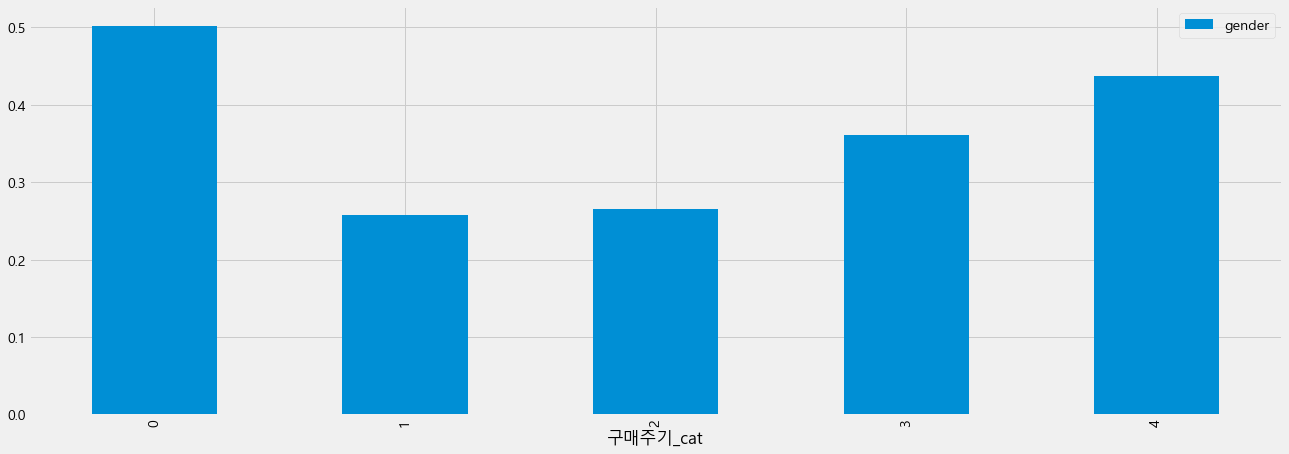

In [56]:
train[['구매주기_cat','gender']].groupby(['구매주기_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [57]:
test['구매주기_cat'] = 0
test.loc[test['구매주기']<=2,'구매주기_cat'] = 0
test.loc[(test['구매주기']>2) & (test['구매주기']<=7),'구매주기_cat'] = 1
test.loc[(test['구매주기']>7) & (test['구매주기']<=15),'구매주기_cat'] = 2
test.loc[(test['구매주기']>15) & (test['구매주기']<=30),'구매주기_cat'] = 3
test.loc[test['구매주기']>30,'구매주기_cat'] = 4
test = test.drop(columns="구매주기")

### 주말방문비율

* 주말의 방문하지 않았거나, 주말방문비율이 50%를 초과할 경우 남성의 비율이 높게 나타났다.

In [58]:
train['주말방문비율2'] = pd.qcut(train['주말방문비율'], 4)
train.groupby(['주말방문비율2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
주말방문비율2,
"(-0.001, 0.0273]",0.454857
"(0.0273, 0.256]",0.275114
"(0.256, 0.449]",0.301714
"(0.449, 1.0]",0.472540


In [59]:
train['주말방문비율_cat'] = 0
train.loc[train['주말방문비율']==0,'주말방문비율_cat'] = 0
train.loc[(train['주말방문비율']>0) & (train['주말방문비율']<=0.2),'주말방문비율_cat'] = 1
train.loc[(train['주말방문비율']>0.2) & (train['주말방문비율']<=0.35),'주말방문비율_cat'] = 2
train.loc[(train['주말방문비율']>0.35) & (train['주말방문비율']<=0.5),'주말방문비율_cat'] = 3
train.loc[train['주말방문비율']>0.5,'주말방문비율_cat'] = 4
train = train.drop(columns=["주말방문비율", "주말방문비율2"])

In [60]:
train.groupby('주말방문비율_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,주말방문비율_cat,고객수
0,0,863
1,1,610
2,2,773
3,3,579
4,4,675


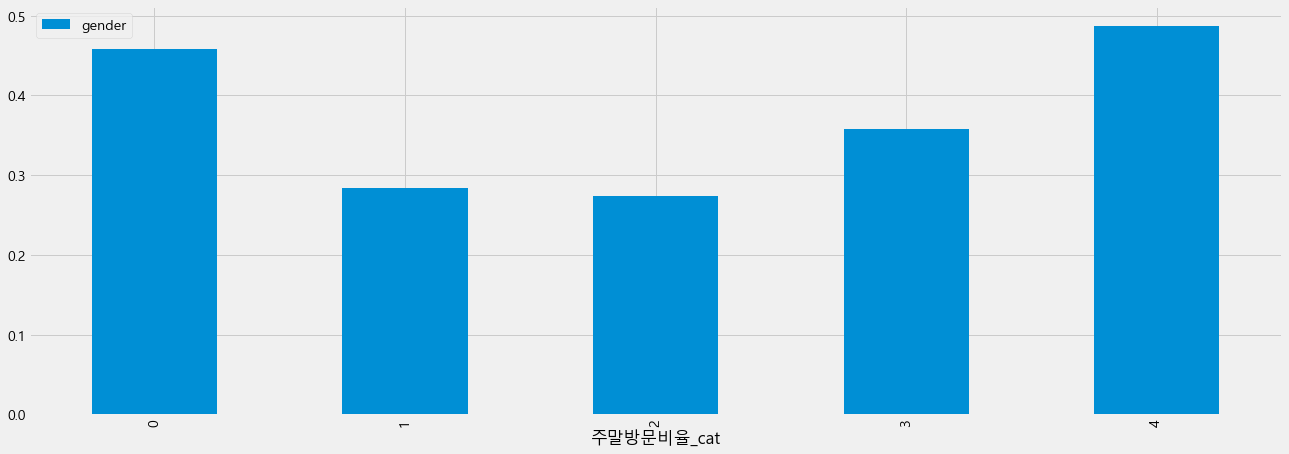

In [61]:
train[['주말방문비율_cat','gender']].groupby(['주말방문비율_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [62]:
test['주말방문비율_cat'] = 0
test.loc[test['주말방문비율']==0,'주말방문비율_cat'] = 0
test.loc[(test['주말방문비율']>0) & (test['주말방문비율']<=0.2),'주말방문비율_cat'] = 1
test.loc[(test['주말방문비율']>0.2) & (test['주말방문비율']<=0.35),'주말방문비율_cat'] = 2
test.loc[(test['주말방문비율']>0.35) & (test['주말방문비율']<=0.5),'주말방문비율_cat'] = 3
test.loc[test['주말방문비율']>0.5,'주말방문비율_cat'] = 4
test = test.drop(columns="주말방문비율")

### 계절별 구매비율

#### 봄-구매비율

* 봄의 구매비율이 0%일 때 남성일 비율이 높게 관찰되었다.

In [63]:
train['봄-구매비율_cat'] = 0
train.loc[train['봄-구매비율']<=0.00,'봄-구매비율_cat'] = 0
train.loc[(train['봄-구매비율']>0.00) & (train['봄-구매비율']<=0.22),'봄-구매비율_cat'] = 1
train.loc[(train['봄-구매비율']>0.22) & (train['봄-구매비율']<=0.37),'봄-구매비율_cat'] = 2
train.loc[train['봄-구매비율']>0.37,'봄-구매비율_cat'] = 3
train = train.drop(columns="봄-구매비율")

In [64]:
train.groupby('봄-구매비율_cat')['gender'].agg([('트랜잭션건수',np.size)]).reset_index()

,봄-구매비율_cat,트랜잭션건수
0,0,884
1,1,929
2,2,877
3,3,810


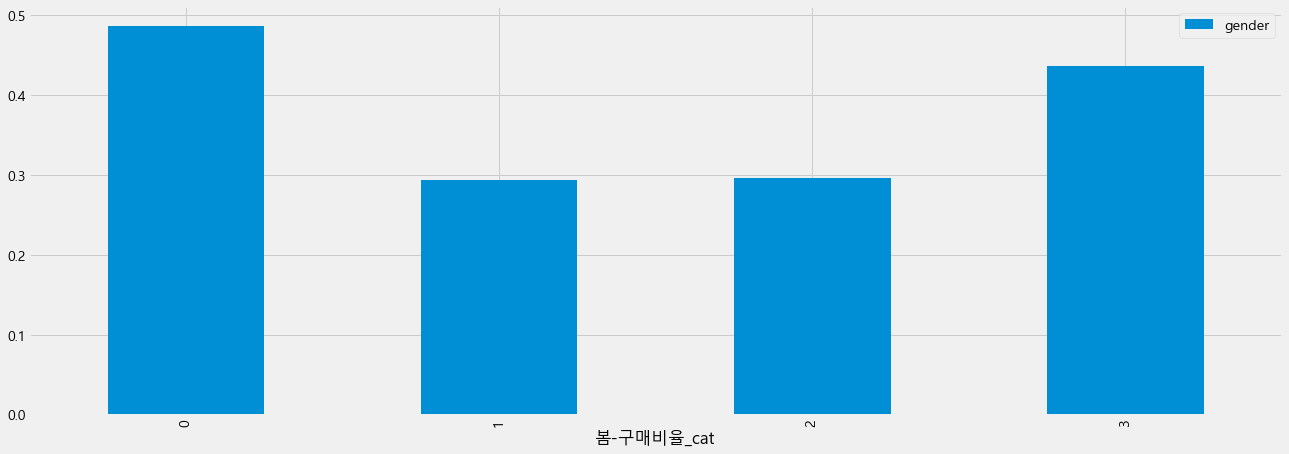

In [65]:
train[['봄-구매비율_cat','gender']].groupby(['봄-구매비율_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [66]:
test['봄-구매비율_cat'] = 0
test.loc[test['봄-구매비율']<=0.00,'봄-구매비율_cat'] = 0
test.loc[(test['봄-구매비율']>0.00) & (test['봄-구매비율']<=0.22),'봄-구매비율_cat'] = 1
test.loc[(test['봄-구매비율']>0.22) & (test['봄-구매비율']<=0.37),'봄-구매비율_cat'] = 2
test.loc[test['봄-구매비율']>0.37,'봄-구매비율_cat'] = 3
test = test.drop(columns="봄-구매비율")

#### 여름-구매비율

* 여름의 구매비율이 0%일 때 남성의 비율이 높게 관찰되었다.  
* 23%~35% 구간에서 여성의 비율이 높게 나타났다.

In [67]:
train['여름-구매비율_cat'] = 0
train.loc[train['여름-구매비율']<=0,'여름-구매비율_cat'] = 0
train.loc[(train['여름-구매비율']>0) & (train['여름-구매비율']<=0.23),'여름-구매비율_cat'] = 1
train.loc[(train['여름-구매비율']>0.23) & (train['여름-구매비율']<=0.35),'여름-구매비율_cat'] = 2
train.loc[train['여름-구매비율']>0.35,'여름-구매비율_cat'] = 3
train = train.drop(columns="여름-구매비율")

In [68]:
train.groupby('여름-구매비율_cat')['gender'].agg([('트랜잭션건수',np.size)]).reset_index()

,여름-구매비율_cat,트랜잭션건수
0,0,1133
1,1,842
2,2,789
3,3,736


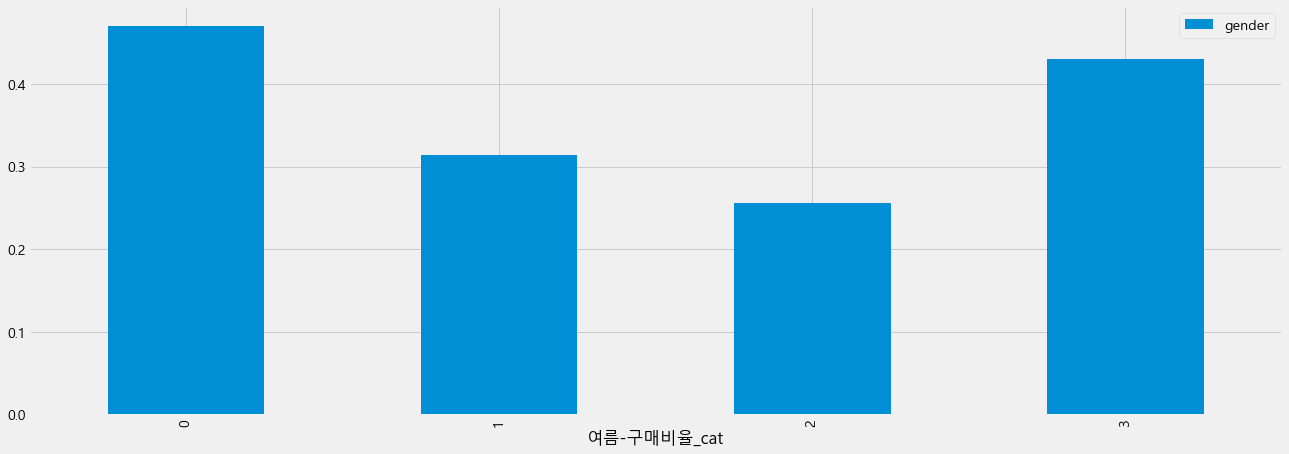

In [69]:
train[['여름-구매비율_cat','gender']].groupby(['여름-구매비율_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [70]:
test['여름-구매비율_cat'] = 0
test.loc[test['여름-구매비율']<=0,'여름-구매비율_cat'] = 0
test.loc[(test['여름-구매비율']>0) & (test['여름-구매비율']<=0.23),'여름-구매비율_cat'] = 1
test.loc[(test['여름-구매비율']>0.23) & (test['여름-구매비율']<=0.35),'여름-구매비율_cat'] = 2
test.loc[test['여름-구매비율']>0.35,'여름-구매비율_cat'] = 3
test = test.drop(columns="여름-구매비율")

#### 가을-구매비율

* 가을의 구매비율이 0%일 때 남성의 비율이 높게 관찰되었다.  

In [71]:
train['가을-구매비율_cat'] = 0
train.loc[train['가을-구매비율']<=0,'가을-구매비율_cat'] = 0
train.loc[(train['가을-구매비율']>0) & (train['가을-구매비율']<=0.23),'가을-구매비율_cat'] = 1
train.loc[(train['가을-구매비율']>0.23) & (train['가을-구매비율']<=0.35),'가을-구매비율_cat'] = 2
train.loc[train['가을-구매비율']>0.35,'가을-구매비율_cat'] = 3
train = train.drop(columns="가을-구매비율")

In [72]:
train.groupby('가을-구매비율_cat')['gender'].agg([('트랜잭션건수',np.size)]).reset_index()

,가을-구매비율_cat,트랜잭션건수
0,0,1068
1,1,825
2,2,786
3,3,821


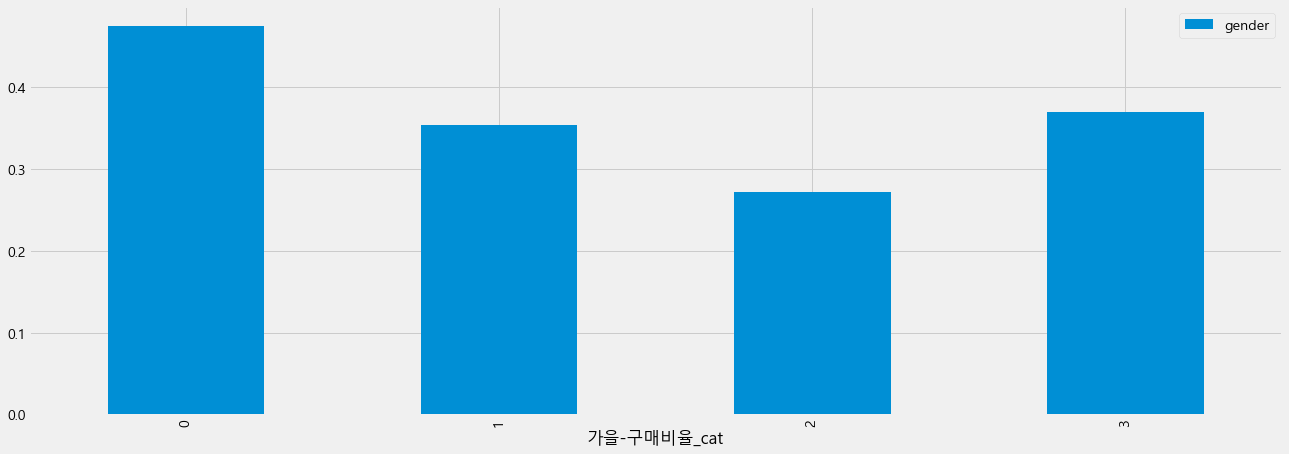

In [73]:
train[['가을-구매비율_cat','gender']].groupby(['가을-구매비율_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [74]:
test['가을-구매비율_cat'] = 0
test.loc[test['가을-구매비율']<=0,'가을-구매비율_cat'] = 0
test.loc[(test['가을-구매비율']>0) & (test['가을-구매비율']<=0.23),'가을-구매비율_cat'] = 1
test.loc[(test['가을-구매비율']>0.23) & (test['가을-구매비율']<=0.35),'가을-구매비율_cat'] = 2
test.loc[test['가을-구매비율']>0.35,'가을-구매비율_cat'] = 3
test = test.drop(columns="가을-구매비율")

#### 겨울-구매비율

* 겨울의 구매비율이 0%일 때 남성의 비율이 높게 관찰되었다.

In [75]:
train['겨울-구매비율_cat'] = 0
train.loc[train['겨울-구매비율']<=0,'겨울-구매비율_cat'] = 0
train.loc[(train['겨울-구매비율']>0) & (train['겨울-구매비율']<=0.21),'겨울-구매비율_cat'] = 1
train.loc[(train['겨울-구매비율']>0.21) & (train['겨울-구매비율']<=0.35),'겨울-구매비율_cat'] = 2
train.loc[train['겨울-구매비율']>0.35,'겨울-구매비율_cat'] = 3
train = train.drop(columns="겨울-구매비율")

In [76]:
train.groupby('겨울-구매비율_cat')['gender'].agg([('트랜잭션건수',np.size)]).reset_index()

,겨울-구매비율_cat,트랜잭션건수
0,0,897
1,1,891
2,2,873
3,3,839


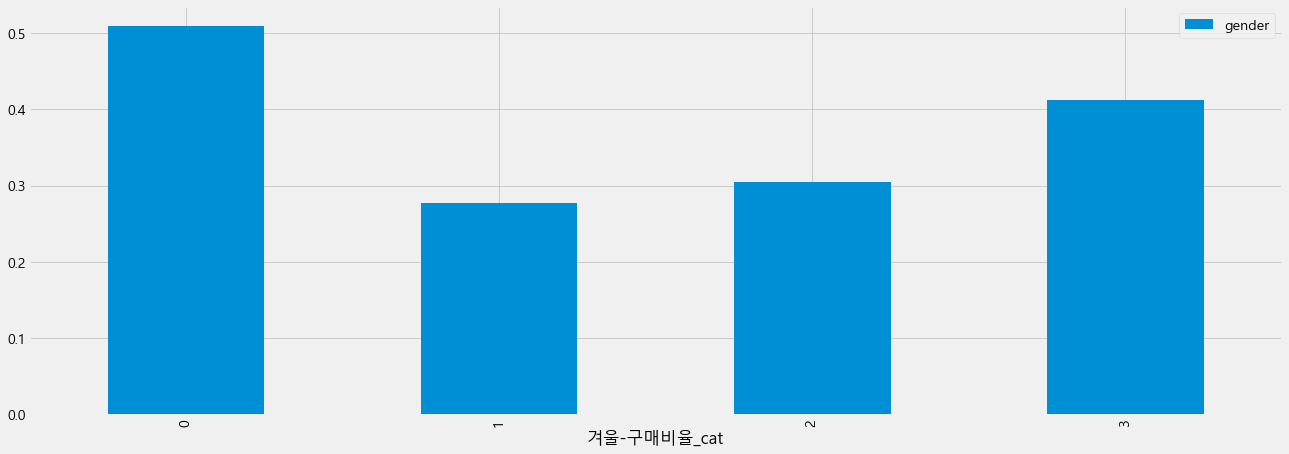

In [77]:
train[['겨울-구매비율_cat','gender']].groupby(['겨울-구매비율_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [78]:
test['겨울-구매비율_cat'] = 0
test.loc[test['겨울-구매비율']<=0,'겨울-구매비율_cat'] = 0
test.loc[(test['겨울-구매비율']>0) & (test['겨울-구매비율']<=0.21),'겨울-구매비율_cat'] = 1
test.loc[(test['겨울-구매비율']>0.21) & (test['겨울-구매비율']<=0.35),'겨울-구매비율_cat'] = 2
test.loc[test['겨울-구매비율']>0.35,'겨울-구매비율_cat'] = 3
test = test.drop(columns="겨울-구매비율")

### 환불금액

* 환불금액(액수)이 적을수록 남성의 비율이 높게 나타났다.

In [79]:
train['환불금액_cat'] = 0
train.loc[train['환불금액']==0,'환불금액_cat'] = 0
train.loc[(train['환불금액']>0) & (train['환불금액']<=10000000),'환불금액_cat'] = 1
train.loc[train['환불금액']>10000000,'환불금액_cat'] = 2
train = train.drop(columns="환불금액")

In [80]:
train.groupby('환불금액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,환불금액_cat,고객수
0,0,2295
1,1,678
2,2,527


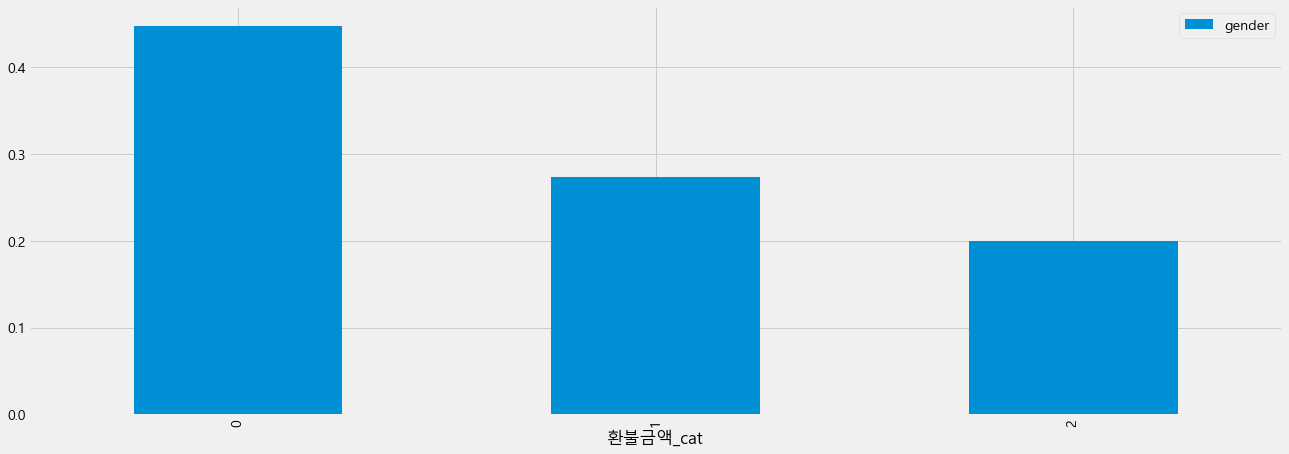

In [81]:
train[['환불금액_cat','gender']].groupby(['환불금액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [82]:
test['환불금액_cat'] = 0
test.loc[test['환불금액']==0,'환불금액_cat'] = 0
test.loc[(test['환불금액']>0) & (test['환불금액']<=10000000),'환불금액_cat'] = 1
test.loc[test['환불금액']>10000000,'환불금액_cat'] = 2
test = test.drop(columns="환불금액")

### 환불건수

* 환불건수가 0건일 경우 남성의 비율이 높게 나타났다.  
* 적절한 분위를 찾아 binning 한 결과, 바로 위의 환불금액_cat feature와 상관관계가 높아,  
환불여부에 대한 데이터로 재가공하여 사용여부를 결정할 예정이다.

In [83]:
train['환불건수_cat'] = 0
train.loc[train['환불건수']==0,'환불건수_cat'] = 0
train.loc[(train['환불건수']>0) & (train['환불건수']<=2),'환불건수_cat'] = 1
train.loc[train['환불건수']>2,'환불건수_cat'] = 2

In [84]:
train.groupby('환불건수_cat')['gender'].agg([('고객',np.size)]).reset_index()

,환불건수_cat,고객
0,0,2295
1,1,623
2,2,582


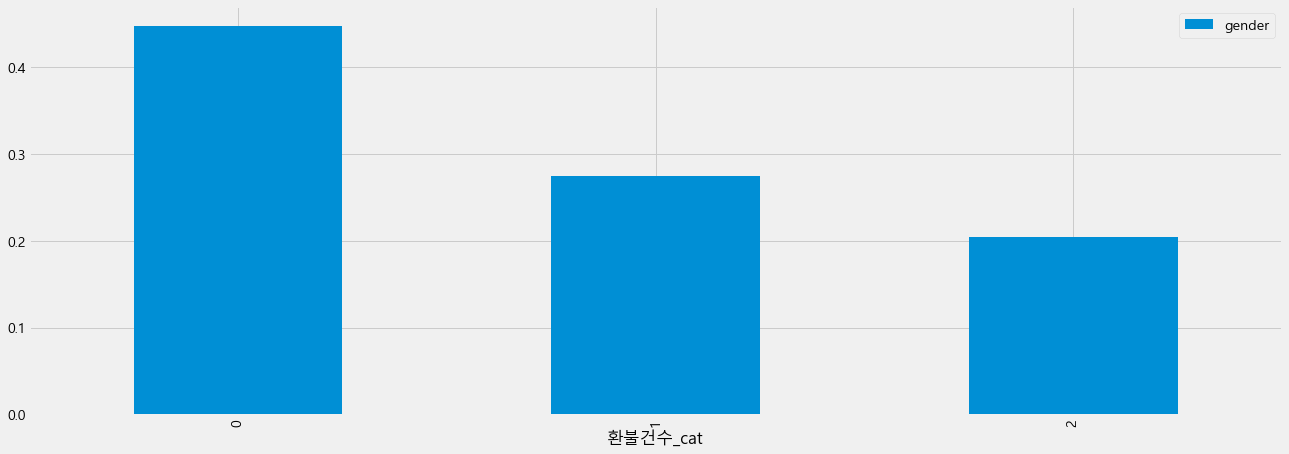

In [85]:
train[['환불건수_cat','gender']].groupby(['환불건수_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

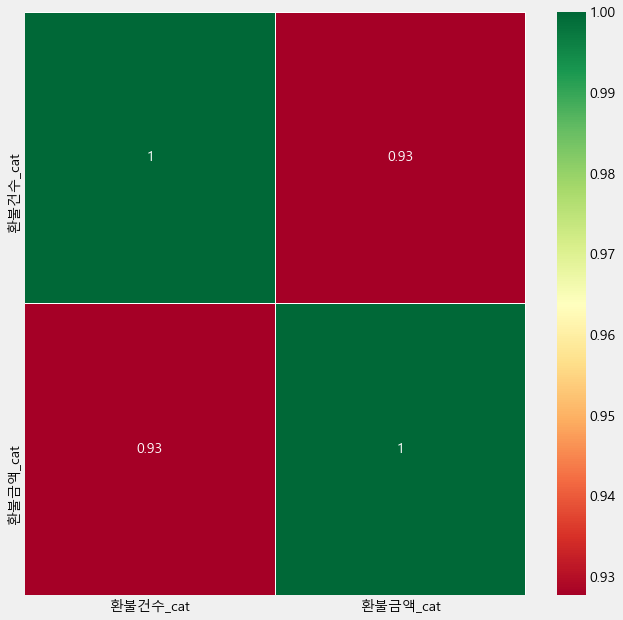

In [86]:
sns.heatmap(train[train.columns[[-1,-2]]].corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [87]:
train = train.drop(columns='환불건수_cat')

### 내점당 구매액

* 내점당 구매액이 적을수록 남성의 비율이 높게 나타났다.
* 단, 내점당 구매액이 음수인 경우는 별도의 그룹 '0'으로 분리하였다. (여성)

In [88]:
train['내점당구매액2'] = pd.qcut(train['내점당구매액'], 10)
train.groupby(['내점당구매액2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
내점당구매액2,
"(-2992000.001, 432977.75]",0.500000
"(432977.75, 981893.133]",0.451429
"(981893.133, 1599760.0]",0.454286
"(1599760.0, 2294410.0]",0.348571
"(2294410.0, 3117387.5]",0.317143
"(3117387.5, 4110399.524]",0.331429
"(4110399.524, 5290385.0]",0.374286
"(5290385.0, 7273477.606]",0.328571
"(7273477.606, 10891137.849]",0.300000


In [89]:
train['내점당구매액_cat'] = 0
train.loc[train['내점당구매액']==0,'내점당구매액_cat'] = 0
train.loc[(train['내점당구매액']>0) & (train['내점당구매액']<=1000000),'내점당구매액_cat'] = 1
train.loc[(train['내점당구매액']>1000000) & (train['내점당구매액']<=2500000),'내점당구매액_cat'] = 2
train.loc[(train['내점당구매액']>2500000) & (train['내점당구매액']<=4500000),'내점당구매액_cat'] = 3
train.loc[(train['내점당구매액']>4500000) & (train['내점당구매액']<=8000000),'내점당구매액_cat'] = 4
train.loc[train['내점당구매액']>8000000,'내점당구매액_cat'] = 5
train = train.drop(columns=["내점당구매액","내점당구매액2"])

In [90]:
train.groupby('내점당구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,내점당구매액_cat,고객수
0,0,10
1,1,702
2,2,778
3,3,742
4,4,657
5,5,611


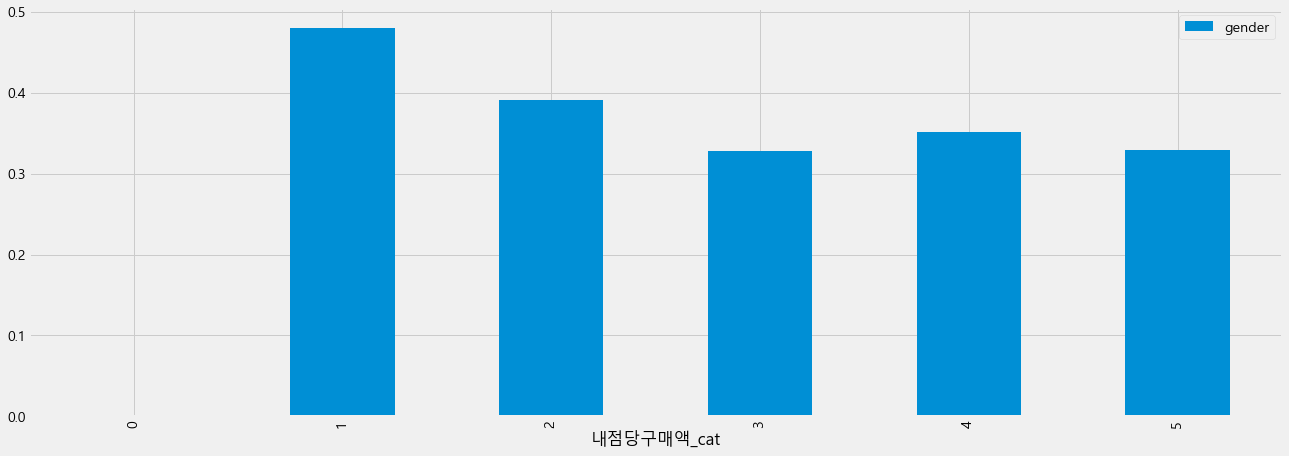

In [91]:
train[['내점당구매액_cat','gender']].groupby(['내점당구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [92]:
test['내점당구매액_cat'] = 0
test.loc[test['내점당구매액']==0,'내점당구매액_cat'] = 0
test.loc[(test['내점당구매액']>0) & (test['내점당구매액']<=1000000),'내점당구매액_cat'] = 1
test.loc[(test['내점당구매액']>1000000) & (test['내점당구매액']<=2500000),'내점당구매액_cat'] = 2
test.loc[(test['내점당구매액']>2500000) & (test['내점당구매액']<=4500000),'내점당구매액_cat'] = 3
test.loc[(test['내점당구매액']>4500000) & (test['내점당구매액']<=8000000),'내점당구매액_cat'] = 4
test.loc[test['내점당구매액']>8000000,'내점당구매액_cat'] = 5
test = test.drop(columns="내점당구매액")

### 내점당 구매건수

* 내점당 구매액이 적을수록 남성의 비율이 높게 나타났다.

In [93]:
train['내점당구매건수2'] = pd.qcut(train['내점당구매건수'], 4)
train.groupby(['내점당구매건수2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
내점당구매건수2,
"(0.999, 1.667]",0.442417
"(1.667, 2.333]",0.372304
"(2.333, 3.375]",0.343284
"(3.375, 22.083]",0.345580


In [94]:
train['내점당구매건수_cat'] = 0
train.loc[train['내점당구매건수']==1,'내점당구매건수_cat'] = 0
train.loc[(train['내점당구매건수']>1) & (train['내점당구매건수']<=2),'내점당구매건수_cat'] = 1
train.loc[(train['내점당구매건수']>2) & (train['내점당구매건수']<=3),'내점당구매건수_cat'] = 2
train.loc[train['내점당구매건수']>3,'내점당구매건수_cat'] = 3
train = train.drop(columns=["내점당구매건수","내점당구매건수2"])

In [95]:
train.groupby('내점당구매건수_cat')['gender'].agg([('고객',np.size)]).reset_index()

,내점당구매건수_cat,고객
0,0,457
1,1,968
2,2,987
3,3,1088


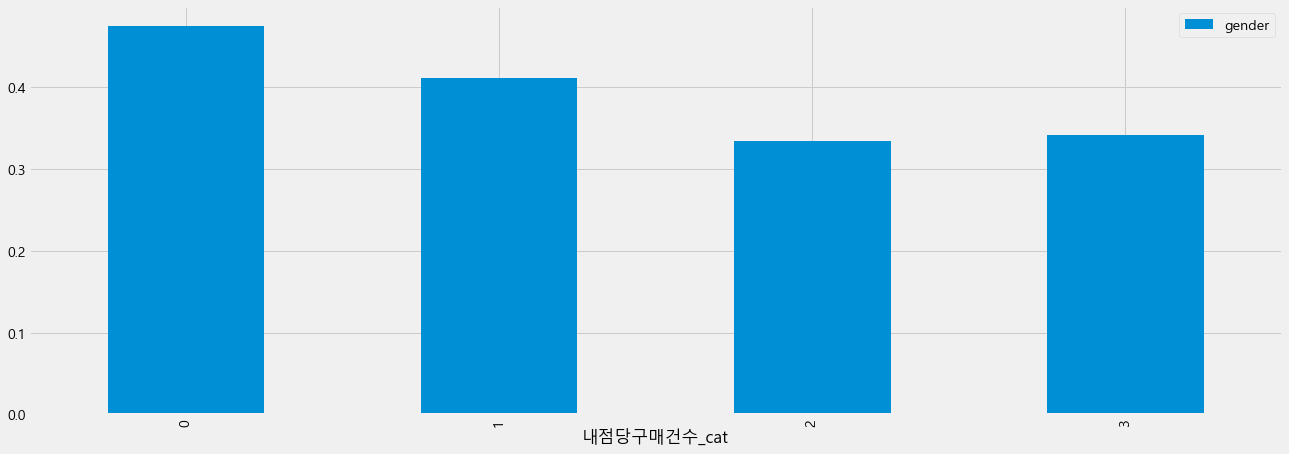

In [96]:
train[['내점당구매건수_cat','gender']].groupby(['내점당구매건수_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [97]:
test['내점당구매건수_cat'] = 0
test.loc[test['내점당구매건수']==1,'내점당구매건수_cat'] = 0
test.loc[(test['내점당구매건수']>1) & (test['내점당구매건수']<=2),'내점당구매건수_cat'] = 1
test.loc[(test['내점당구매건수']>2) & (test['내점당구매건수']<=3),'내점당구매건수_cat'] = 2
test.loc[test['내점당구매건수']>3,'내점당구매건수_cat'] = 3
test = test.drop(columns="내점당구매건수")

### 최근 n개월 구매금액

* 최근 n개월 구매금액 feature는 총구매액 feature와 매우 높은 상관관계를 보였다.  
* 따라서 본 분석에서는 탈락시키기로 하였다.

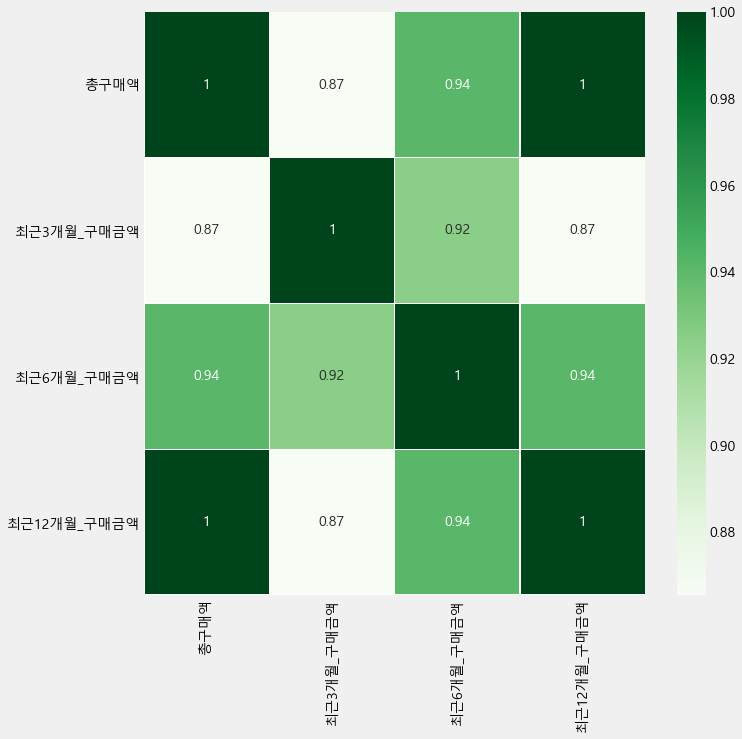

In [98]:
sns.heatmap(train[train.columns[[1,4,6,8]]].corr(),annot=True,cmap='Greens',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [99]:
train = train.drop(columns=["최근3개월_구매금액","최근6개월_구매금액","최근12개월_구매금액"])
test = test.drop(columns=["최근3개월_구매금액","최근6개월_구매금액","최근12개월_구매금액"])

### 최근n개월_구매건수

* 최근 n개월 구매건수 feature는 구매건수 feature와 매우 높은 상관관계를 보였다.  
* 따라서 위의 최근 n개월 구매총액 feature와 같은 이유로 본 분석에서는 탈락시키기로 하였다.

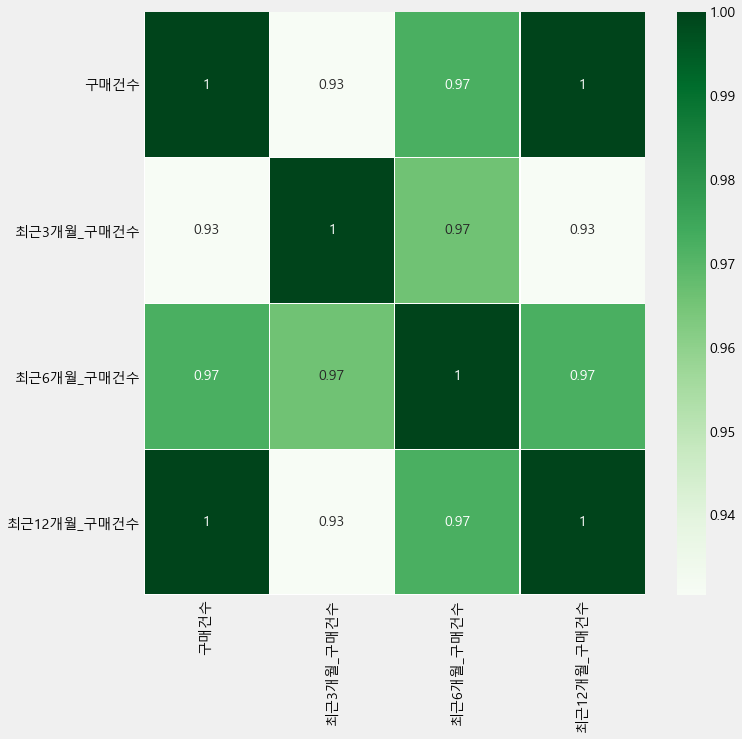

In [100]:
sns.heatmap(train[train.columns[[2,4,5,6]]].corr(),annot=True,cmap='Greens',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [101]:
train = train.drop(columns=["최근3개월_구매건수","최근6개월_구매건수","최근12개월_구매건수"])
test = test.drop(columns=["최근3개월_구매건수","최근6개월_구매건수","최근12개월_구매건수"])

### 시즌선호도

* 시즌선호도가 0일때 남성의 비율이 높게 나타났다.

In [102]:
train['시즌선호도_cat'] = 0
train.loc[train['시즌선호도']==0,'시즌선호도_cat'] = 0
train.loc[(train['시즌선호도']>0) & (train['시즌선호도']<=0.5),'시즌선호도_cat'] = 1
train.loc[(train['시즌선호도']>0.5) & (train['시즌선호도']<=1),'시즌선호도_cat'] = 2
train.loc[(train['시즌선호도']>1) & (train['시즌선호도']<=3),'시즌선호도_cat'] = 3
train.loc[train['시즌선호도']>3,'시즌선호도_cat'] = 4
train = train.drop(columns="시즌선호도")

In [103]:
train.groupby('시즌선호도_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,시즌선호도_cat,고객수
0,0,1057
1,1,688
2,2,534
3,3,610
4,4,611


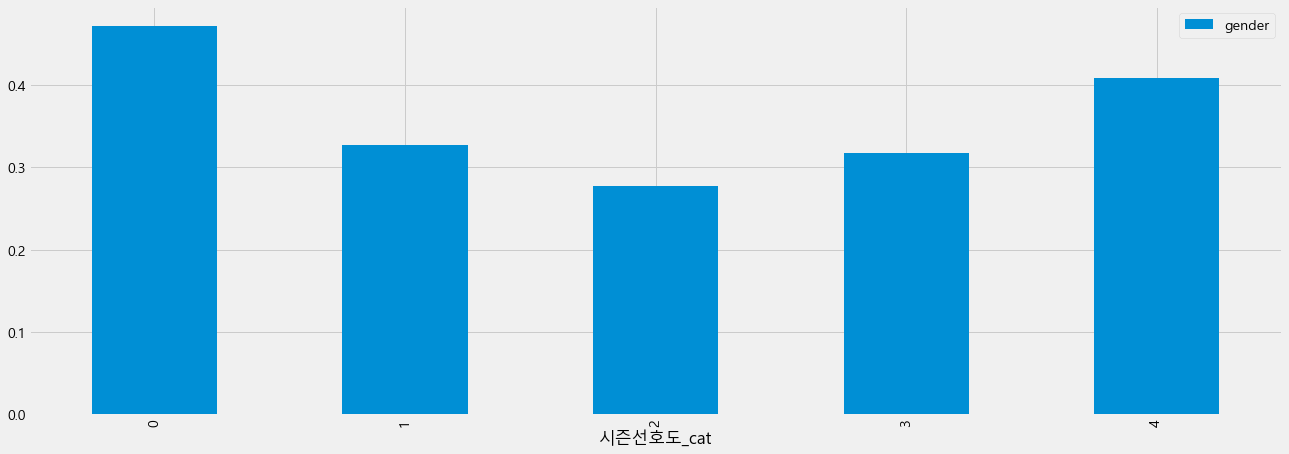

In [104]:
train[['시즌선호도_cat','gender']].groupby(['시즌선호도_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [105]:
test['시즌선호도_cat'] = 0
test.loc[test['시즌선호도']==0,'시즌선호도_cat'] = 0
test.loc[(test['시즌선호도']>0) & (test['시즌선호도']<=0.5),'시즌선호도_cat'] = 1
test.loc[(test['시즌선호도']>0.5) & (test['시즌선호도']<=1),'시즌선호도_cat'] = 2
test.loc[(test['시즌선호도']>1) & (test['시즌선호도']<=3),'시즌선호도_cat'] = 3
test.loc[test['시즌선호도']>3,'시즌선호도_cat'] = 4
test = test.drop(columns="시즌선호도")

### 구매추세패턴

* 구매추세패턴 feature의 경우는 구매 추세가 감소할 경우(0, FALSE), 남성의 비율이 높게 나타났다.  
* 하지만 유의미한 트렌드라고 보기 어려웠다.
* 삭제 예정

In [106]:
train.groupby('구매추세패턴')['gender'].agg([('고객수',np.size)]).reset_index()

,구매추세패턴,고객수
0,False,1802
1,True,1698


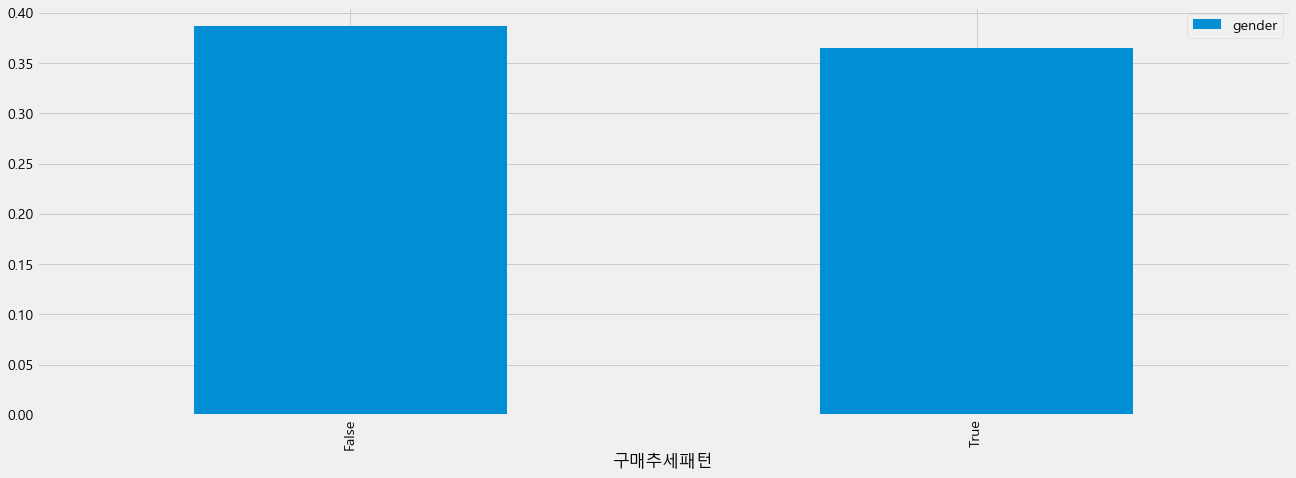

In [107]:
train[['구매추세패턴','gender']].groupby(['구매추세패턴']).mean().plot.bar(figsize=(20,7))
plt.show()

In [108]:
train = train.drop(columns='구매추세패턴')
test = test.drop(columns='구매추세패턴')

### 휴면(이탈)여부

* 휴면(이탈)을 한 적이 있는 고객집단에서(1,TRUE) 남성의 비율이 높게 나타났다.

In [109]:
train.groupby(['휴면(이탈)여부'])['gender'].agg([('고객수',np.size)]).reset_index()

,휴면(이탈)여부,고객수
0,False,1714
1,True,1786


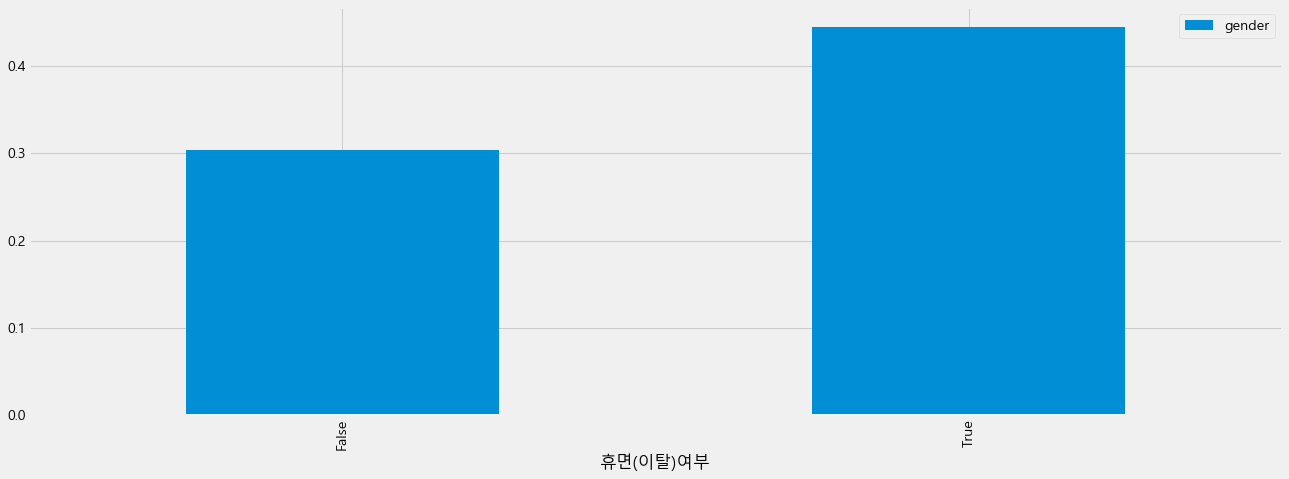

In [110]:
train[['휴면(이탈)여부','gender']].groupby(['휴면(이탈)여부']).mean().plot.bar(figsize=(20,7))
plt.show()

### 구매시환불비율

* 구매시환불비율을 분석해본 결과 환불을 한 적이 없다면 남성의 비율이 높게 나타났다.  
* 그러나 이 것은 위에서 다룬 환불관련 Feature 를 재가공해서 만들 예정이라 이 Feature는 삭제할 예정이다.

In [111]:
train['구매시환불비율_cat'] = 0
train.loc[train['구매시환불비율']<=0,'구매시환불비율_cat'] = 0
train.loc[(train['구매시환불비율']>0) & (train['구매시환불비율']<=.05),'구매시환불비율_cat'] = 1
train.loc[train['구매시환불비율']>.05,'구매시환불비율_cat'] = 2
train = train.drop(columns="구매시환불비율")

In [112]:
train.groupby('구매시환불비율_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,구매시환불비율_cat,고객수
0,0,2295
1,1,667
2,2,538


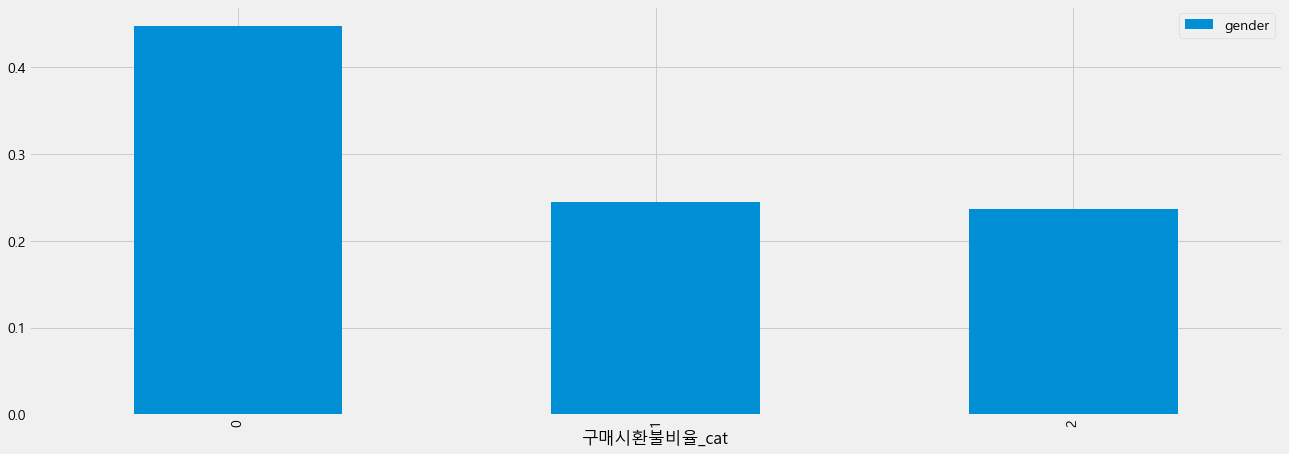

In [113]:
train[['구매시환불비율_cat','gender']].groupby(['구매시환불비율_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [114]:
train = train.drop(columns="구매시환불비율_cat")
test = test.drop(columns="구매시환불비율")

### 최장휴면일수

*  최장휴면일수가 길수록 남성의 비율이 높게 나타났다.

In [115]:
train['최장휴면일수2'] = pd.qcut(train['최장휴면일수'], 10)
train.groupby(['최장휴면일수2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
최장휴면일수2,
"(-0.001, 28.0]",0.274359
"(28.0, 41.0]",0.257576
"(41.0, 55.0]",0.309456
"(55.0, 71.0]",0.326531
"(71.0, 92.0]",0.351585
"(92.0, 121.0]",0.431884
"(121.0, 161.3]",0.410405
"(161.3, 215.0]",0.482955
"(215.0, 273.0]",0.470423


In [116]:
train['최장휴면일수_cat'] = 0
train.loc[train['최장휴면일수']<=40,'최장휴면일수_cat'] = 0
train.loc[(train['최장휴면일수']>40) & (train['최장휴면일수']<=70),'최장휴면일수_cat'] = 1
train.loc[(train['최장휴면일수']>70) & (train['최장휴면일수']<=120),'최장휴면일수_cat'] = 2
train.loc[(train['최장휴면일수']>120) & (train['최장휴면일수']<=215),'최장휴면일수_cat'] = 3
train.loc[train['최장휴면일수']>215,'최장휴면일수_cat'] = 4
train = train.drop(columns=["최장휴면일수","최장휴면일수2"])

In [117]:
train.groupby('최장휴면일수_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,최장휴면일수_cat,고객수
0,0,698
1,1,701
2,2,697
3,3,706
4,4,698


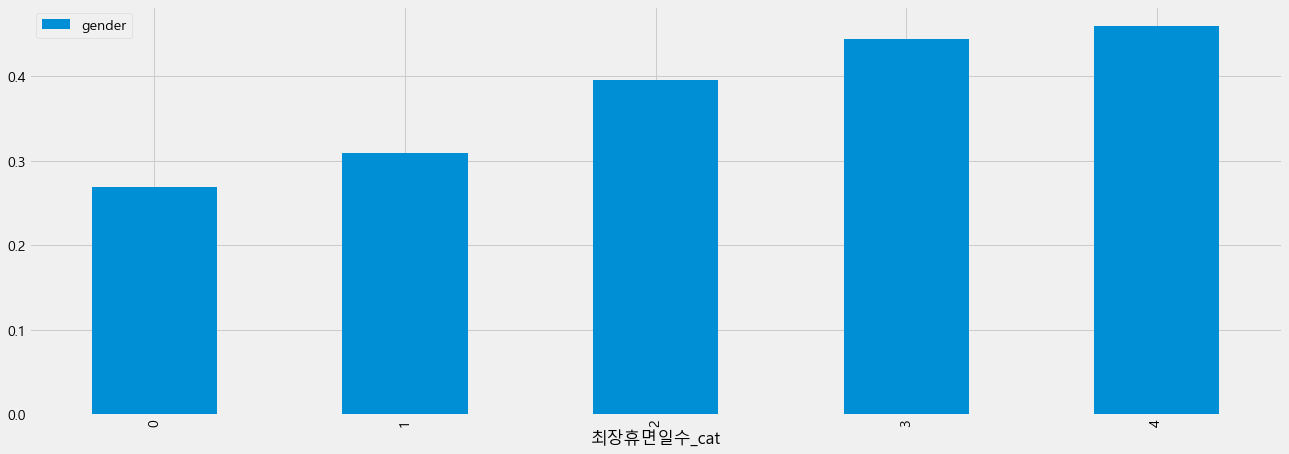

In [118]:
train[['최장휴면일수_cat','gender']].groupby(['최장휴면일수_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [119]:
test['최장휴면일수_cat'] = 0
test.loc[test['최장휴면일수']<=40,'최장휴면일수_cat'] = 0
test.loc[(test['최장휴면일수']>40) & (test['최장휴면일수']<=70),'최장휴면일수_cat'] = 1
test.loc[(test['최장휴면일수']>70) & (test['최장휴면일수']<=120),'최장휴면일수_cat'] = 2
test.loc[(test['최장휴면일수']>120) & (test['최장휴면일수']<=215),'최장휴면일수_cat'] = 3
test.loc[test['최장휴면일수']>215,'최장휴면일수_cat'] = 4
test = test.drop(columns="최장휴면일수")

### 행사상품 구매건수

* 행사상품의 구매건수가 적을수록 남성의 비율이 높게 나타났다.

In [120]:
train['행사상품구매건수_cat'] = 0
train.loc[train['행사상품구매건수']==0,'행사상품구매건수_cat'] = 0
train.loc[(train['행사상품구매건수']>=1) & (train['행사상품구매건수']<2),'행사상품구매건수_cat'] = 1
train.loc[(train['행사상품구매건수']>=2) & (train['행사상품구매건수']<5),'행사상품구매건수_cat'] = 2
train.loc[train['행사상품구매건수']>=5,'행사상품구매건수_cat'] = 3
train = train.drop(columns="행사상품구매건수")

In [121]:
train.groupby('행사상품구매건수_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,행사상품구매건수_cat,고객수
0,0,1911
1,1,473
2,2,637
3,3,479


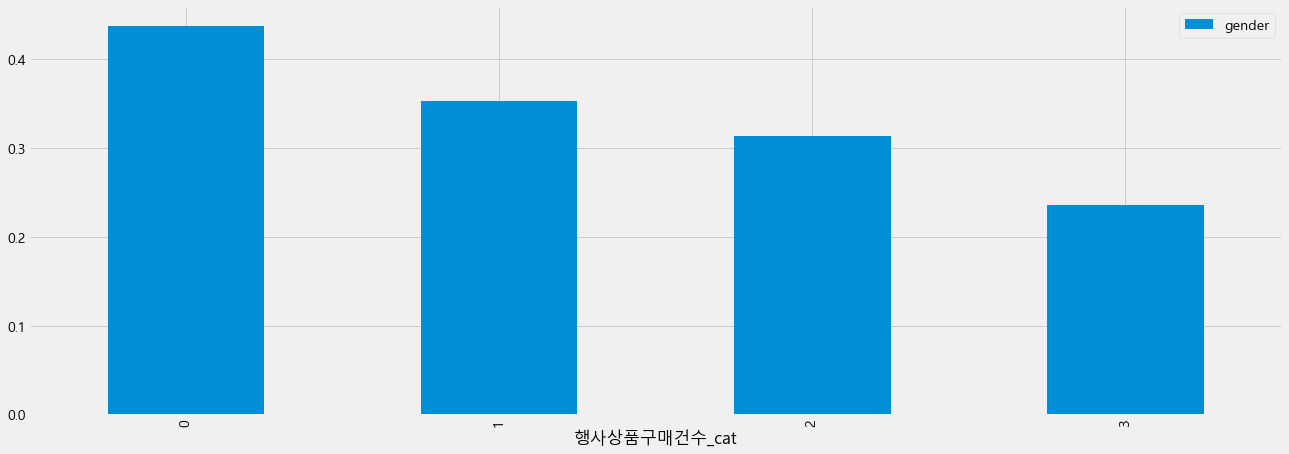

In [122]:
train[['행사상품구매건수_cat','gender']].groupby(['행사상품구매건수_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [123]:
test['행사상품구매건수_cat'] = 0
test.loc[test['행사상품구매건수']==0,'행사상품구매건수_cat'] = 0
test.loc[(test['행사상품구매건수']>=1) & (test['행사상품구매건수']<2),'행사상품구매건수_cat'] = 1
test.loc[(test['행사상품구매건수']>=2) & (test['행사상품구매건수']<5),'행사상품구매건수_cat'] = 2
test.loc[test['행사상품구매건수']>=5,'행사상품구매건수_cat'] = 3
test = test.drop(columns="행사상품구매건수")

### 행사상품 구매총액

* 행사상품의 구매총액이 적을수록 남성의 비율이 높게 나타났다.

In [124]:
train['행사상품구매총액_cat'] = 0
train.loc[train['행사상품구매총액']==0,'행사상품구매총액_cat'] = 0
train.loc[(train['행사상품구매총액']>0) & (train['행사상품구매총액']<=100000),'행사상품구매총액_cat'] = 1
train.loc[(train['행사상품구매총액']>100000) & (train['행사상품구매총액']<=750000),'행사상품구매총액_cat'] = 2
train.loc[train['행사상품구매총액']>750000,'행사상품구매총액_cat'] = 3
train = train.drop(columns="행사상품구매총액")

In [125]:
train.groupby('행사상품구매총액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,행사상품구매총액_cat,고객수
0,0,1930
1,1,493
2,2,506
3,3,571


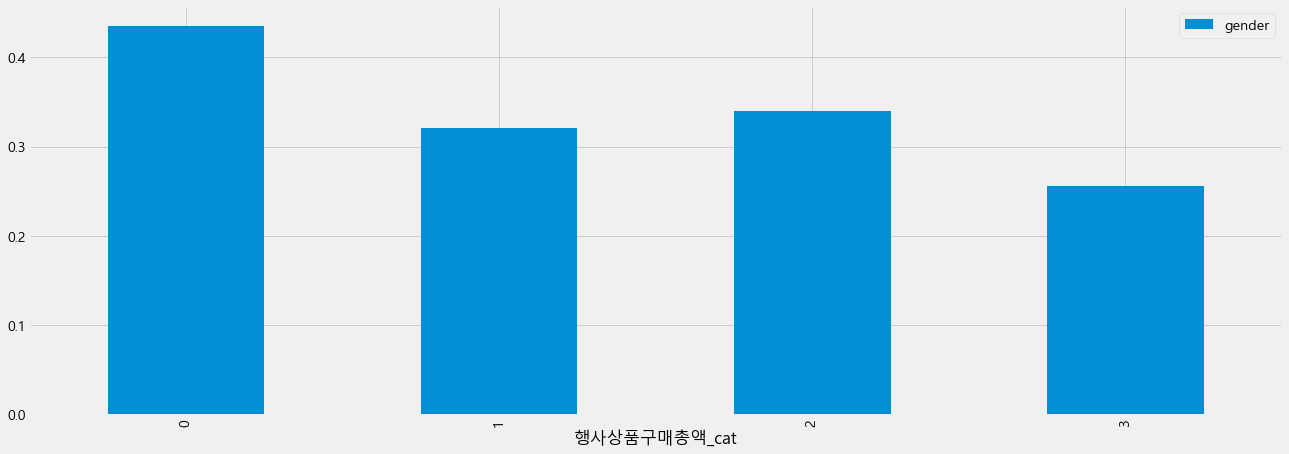

In [126]:
train[['행사상품구매총액_cat','gender']].groupby(['행사상품구매총액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [127]:
test['행사상품구매총액_cat'] = 0
test.loc[test['행사상품구매총액']==0,'행사상품구매총액_cat'] = 0
test.loc[(test['행사상품구매총액']>0) & (test['행사상품구매총액']<=100000),'행사상품구매총액_cat'] = 1
test.loc[(test['행사상품구매총액']>100000) & (test['행사상품구매총액']<=750000),'행사상품구매총액_cat'] = 2
test.loc[test['행사상품구매총액']>750000,'행사상품구매총액_cat'] = 3
test = test.drop(columns="행사상품구매총액")

### 특징상품-구매비율

* 특징상품의 구매비율이 낮을수록 남성의 비율이 두드러지게 높게 나타났다.  
* 여성이 구매할 확률이 높다고 판단한 상품끼리 묶어서 분석을 해본 것이 주효한 듯 하다.  
특징상품 = ['보석', '시티웨어', '침구/수예', '디자이너', '란제리/내의', '모피/피혁', '커리어', '액세서리', '농산물', '화장품']

In [128]:
train['특징상품-구매비율2'] = pd.qcut(train['특징상품-구매비율'], 4)
train.groupby(['특징상품-구매비율2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
특징상품-구매비율2,
"(-0.001, 0.0909]",0.623007
"(0.0909, 0.244]",0.388761
"(0.244, 0.4]",0.275901
"(0.4, 1.0]",0.214617


In [129]:
train['특징상품-구매비율_cat'] = 0
train.loc[train['특징상품-구매비율']<0.1,'특징상품-구매비율_cat'] = 0
train.loc[(train['특징상품-구매비율']>=0.1) & (train['특징상품-구매비율']<.25),'특징상품-구매비율_cat'] = 1
train.loc[(train['특징상품-구매비율']>=.25) & (train['특징상품-구매비율']<.4),'특징상품-구매비율_cat'] = 2
train.loc[train['특징상품-구매비율']>=.4,'특징상품-구매비율_cat'] = 3
train = train.drop(columns=["특징상품-구매비율","특징상품-구매비율2"])

In [130]:
train.groupby('특징상품-구매비율_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,특징상품-구매비율_cat,고객수
0,0,900
1,1,872
2,2,820
3,3,908


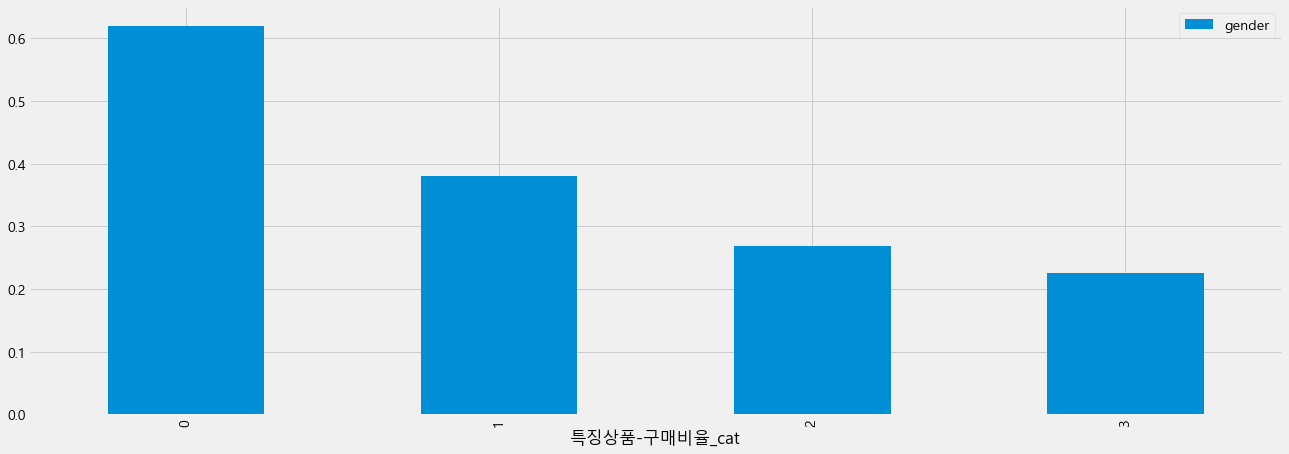

In [131]:
train[['특징상품-구매비율_cat','gender']].groupby(['특징상품-구매비율_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [132]:
test['특징상품-구매비율_cat'] = 0
test.loc[test['특징상품-구매비율']<0.1,'특징상품-구매비율_cat'] = 0
test.loc[(test['특징상품-구매비율']>=0.1) & (test['특징상품-구매비율']<.25),'특징상품-구매비율_cat'] = 1
test.loc[(test['특징상품-구매비율']>=.25) & (test['특징상품-구매비율']<.4),'특징상품-구매비율_cat'] = 2
test.loc[test['특징상품-구매비율']>=.4,'특징상품-구매비율_cat'] = 3
test = test.drop(columns="특징상품-구매비율")

### 베스트셀러 (TOP10) 품목 총구매액

* 총 구매액 feature와 디자이너품목 총구매액 feature의 상관관계가 높게 관찰되었다.

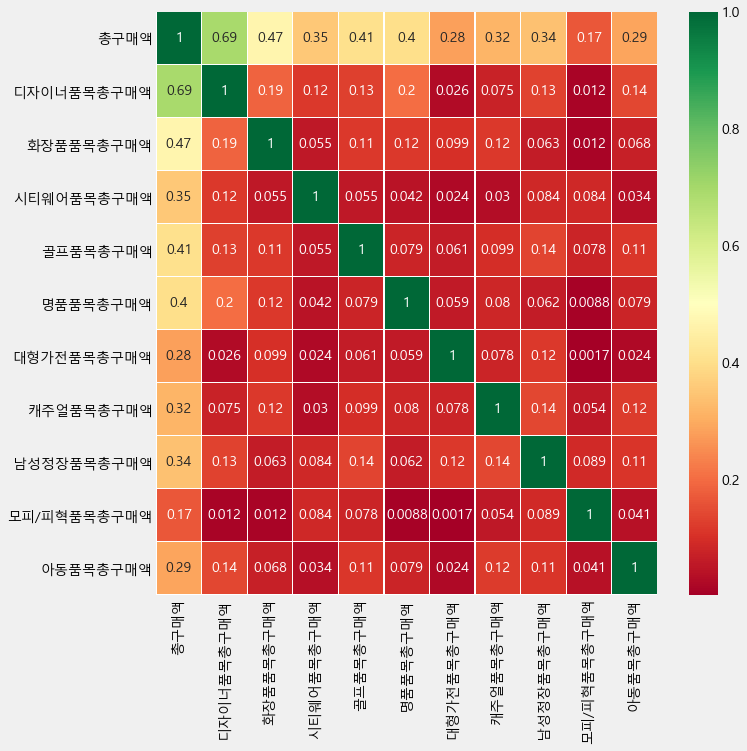

In [133]:
sns.heatmap(train[train.columns[[1,6,7,8,9,10,11,12,13,14,15]]].corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [134]:
train = train.drop(columns="총구매액")

### 디자이너품목총구매액

* 디자이너품목의 총구매액이 낮을수록 남성의 비율이 높게 나타났다.  

In [135]:
train['디자이너품목총구매액_cat'] = 0
train.loc[train['디자이너품목총구매액']<=0,'디자이너품목총구매액_cat'] = 0
train.loc[(train['디자이너품목총구매액']>0) & (train['디자이너품목총구매액']<=10000000),'디자이너품목총구매액_cat'] = 1
train.loc[(train['디자이너품목총구매액']>10000000) & (train['디자이너품목총구매액']<=100000000),'디자이너품목총구매액_cat'] = 2
train.loc[train['디자이너품목총구매액']>100000000,'디자이너품목총구매액_cat'] = 3

In [136]:
train.groupby('디자이너품목총구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()


,디자이너품목총구매액_cat,고객수
0,0,2394
1,1,334
2,2,583
3,3,189


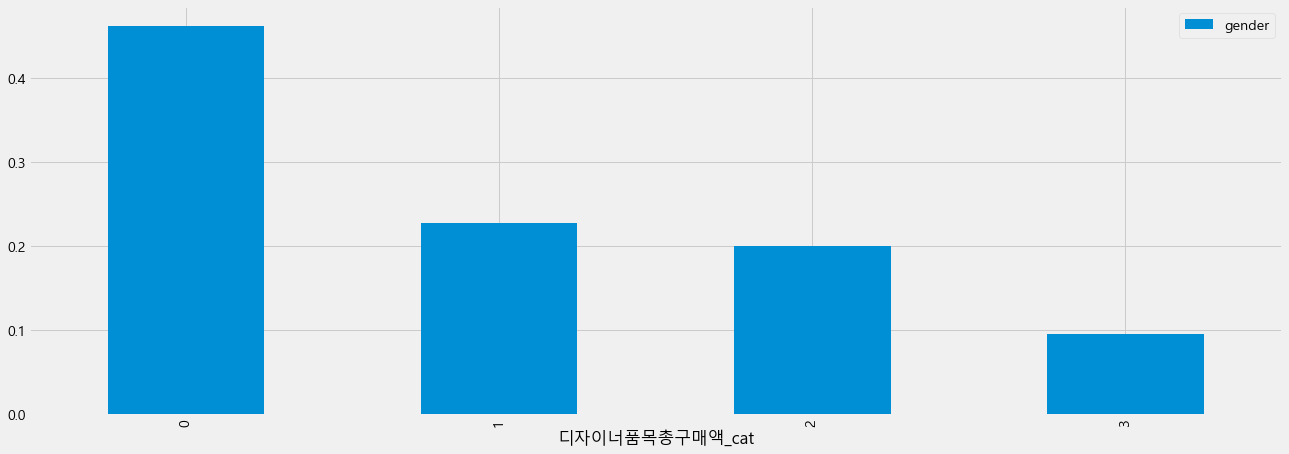

In [137]:
train[['디자이너품목총구매액_cat','gender']].groupby(['디자이너품목총구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [138]:
test['디자이너품목총구매액_cat'] = 0
test.loc[test['디자이너품목총구매액']<=0,'디자이너품목총구매액_cat'] = 0
test.loc[(test['디자이너품목총구매액']>0) & (test['디자이너품목총구매액']<=10000000),'디자이너품목총구매액_cat'] = 1
test.loc[(test['디자이너품목총구매액']>10000000) & (test['디자이너품목총구매액']<=100000000),'디자이너품목총구매액_cat'] = 2
test.loc[test['디자이너품목총구매액']>100000000,'디자이너품목총구매액_cat'] = 3
test = test.drop(columns="디자이너품목총구매액")

### 화장품품목총구매액

* 디자이너품목의 총구매액이 낮을수록 남성의 비율이 높게 나타났다.  
* 특히 총구매액이 1천만원을 넘어가면 유의미한 값을 보였다.

In [139]:
train['화장품품목총구매액_cat'] = 0
train.loc[train['화장품품목총구매액']<=0,'화장품품목총구매액_cat'] = 0
train.loc[(train['화장품품목총구매액']>0) & (train['화장품품목총구매액']<=10000000),'화장품품목총구매액_cat'] = 1
train.loc[train['화장품품목총구매액']>10000000,'화장품품목총구매액_cat'] = 2

In [140]:
train.groupby('화장품품목총구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,화장품품목총구매액_cat,고객수
0,0,1893
1,1,837
2,2,770


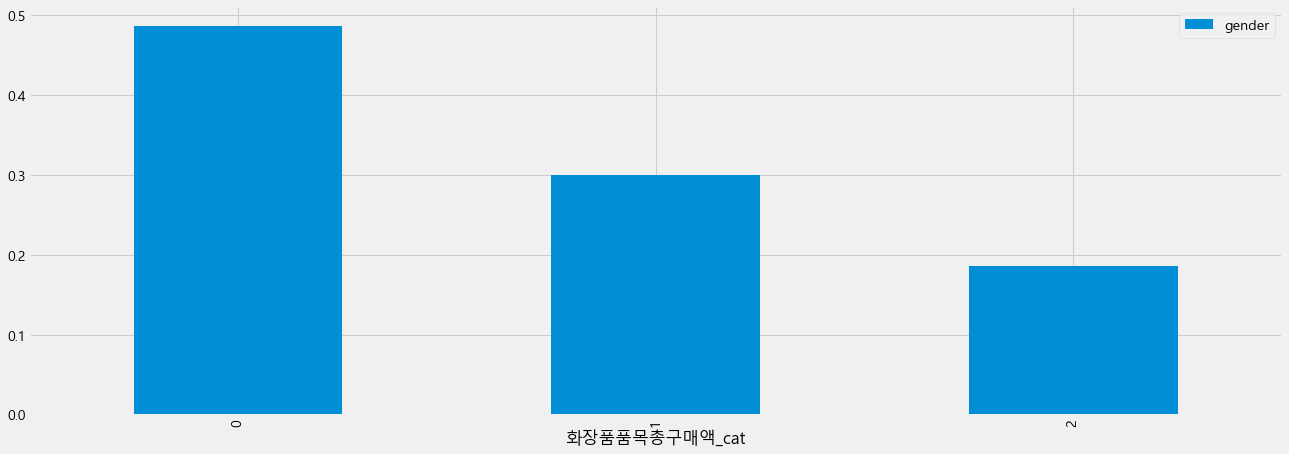

In [141]:
train[['화장품품목총구매액_cat','gender']].groupby(['화장품품목총구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [142]:
test['화장품품목총구매액_cat'] = 0
test.loc[test['화장품품목총구매액']<=0,'화장품품목총구매액_cat'] = 0
test.loc[(test['화장품품목총구매액']>0) & (test['화장품품목총구매액']<=10000000),'화장품품목총구매액_cat'] = 1
test.loc[test['화장품품목총구매액']>10000000,'화장품품목총구매액_cat'] = 2
test = test.drop(columns="화장품품목총구매액")

### 시티웨어품목총구매액

* 시티웨어품목의 총구매액이 낮을수록 남성의 비율이 높게 나타났다.  

In [143]:
train['시티웨어품목총구매액_cat'] = 0
train.loc[train['시티웨어품목총구매액']<=0,'시티웨어품목총구매액_cat'] = 0
train.loc[(train['시티웨어품목총구매액']>0) & (train['시티웨어품목총구매액']<=10000000),'시티웨어품목총구매액_cat'] = 1
train.loc[train['시티웨어품목총구매액']>10000000,'시티웨어품목총구매액_cat'] = 2

In [144]:
train.groupby('시티웨어품목총구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,시티웨어품목총구매액_cat,고객수
0,0,2125
1,1,716
2,2,659


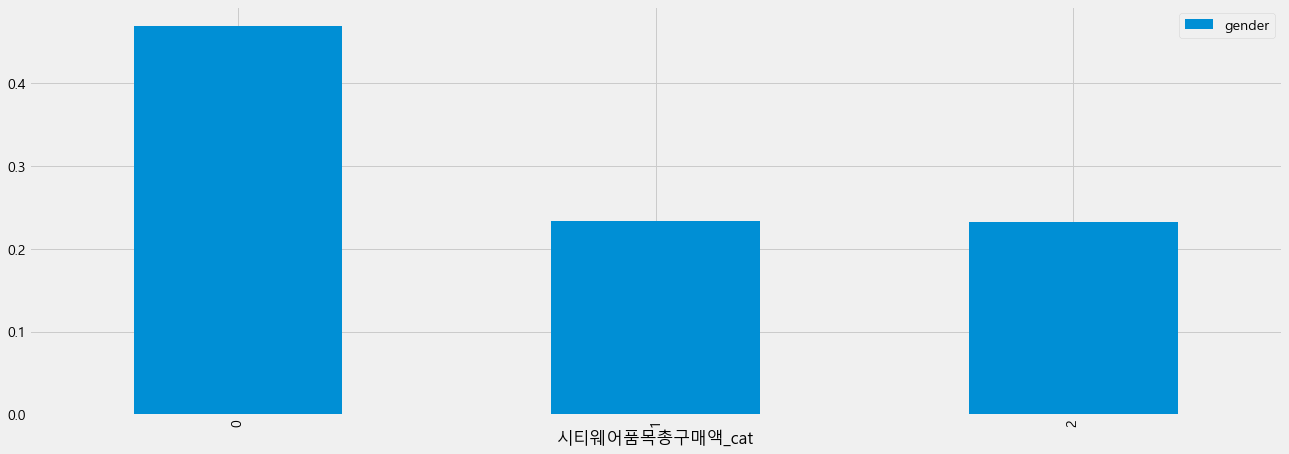

In [145]:
train[['시티웨어품목총구매액_cat','gender']].groupby(['시티웨어품목총구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [146]:
test['시티웨어품목총구매액_cat'] = 0
test.loc[test['시티웨어품목총구매액']<=0,'시티웨어품목총구매액_cat'] = 0
test.loc[(test['시티웨어품목총구매액']>0) & (train['시티웨어품목총구매액']<=10000000),'시티웨어품목총구매액_cat'] = 1
test.loc[test['시티웨어품목총구매액']>10000000,'시티웨어품목총구매액_cat'] = 2
test = test.drop(columns="시티웨어품목총구매액")

### 골프품목총구매액

* 골프품목을 구매한 적이 없다면 남성의 비율이 높게 나타났다.  
* 유의미한 지표라고 생각되지 않아 삭제할 예정이다.

In [147]:
train['골프품목총구매액_cat'] = 0
train.loc[train['골프품목총구매액']<=0,'골프품목총구매액_cat'] = 0
train.loc[(train['골프품목총구매액']>0) & (train['골프품목총구매액']<=10000000),'골프품목총구매액_cat'] = 1
train.loc[train['골프품목총구매액']>10000000,'골프품목총구매액_cat'] = 2
train = train.drop(columns="골프품목총구매액")

In [148]:
train.groupby('골프품목총구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,골프품목총구매액_cat,고객수
0,0,2625
1,1,473
2,2,402


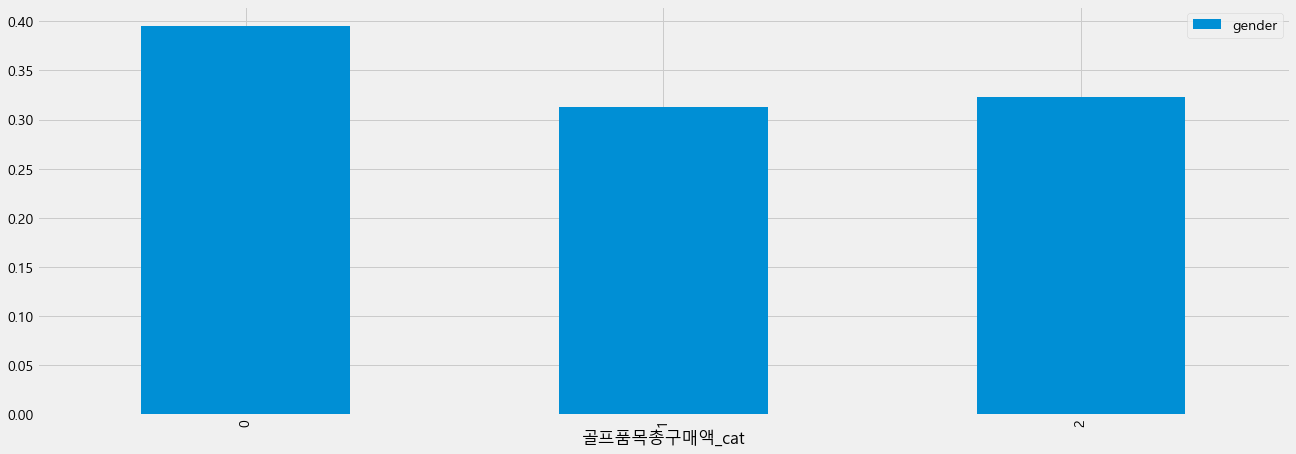

In [149]:
train[['골프품목총구매액_cat','gender']].groupby(['골프품목총구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [150]:
test['골프품목총구매액_cat'] = 0
test.loc[test['골프품목총구매액']<=0,'골프품목총구매액_cat'] = 0
test.loc[(test['골프품목총구매액']>0) & (test['골프품목총구매액']<=10000000),'골프품목총구매액_cat'] = 1
test.loc[test['골프품목총구매액']>10000000,'골프품목총구매액_cat'] = 2
test = test.drop(columns="골프품목총구매액")

### 명품품목구매총액

* 명품품목의 구매총액이 낮을수록 남성의 비율이 높게 나타났다.  

In [151]:
train['명품품목총구매액_cat'] = 0
train.loc[train['명품품목총구매액']<=0,'명품품목총구매액_cat'] = 0
train.loc[(train['명품품목총구매액']>0) & (train['명품품목총구매액']<=10000000),'명품품목총구매액_cat'] = 1
train.loc[train['명품품목총구매액']>10000000,'명품품목총구매액_cat'] = 2
train = train.drop(columns="명품품목총구매액")

In [152]:
train.groupby('명품품목총구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,명품품목총구매액_cat,고객수
0,0,2851
1,1,406
2,2,243


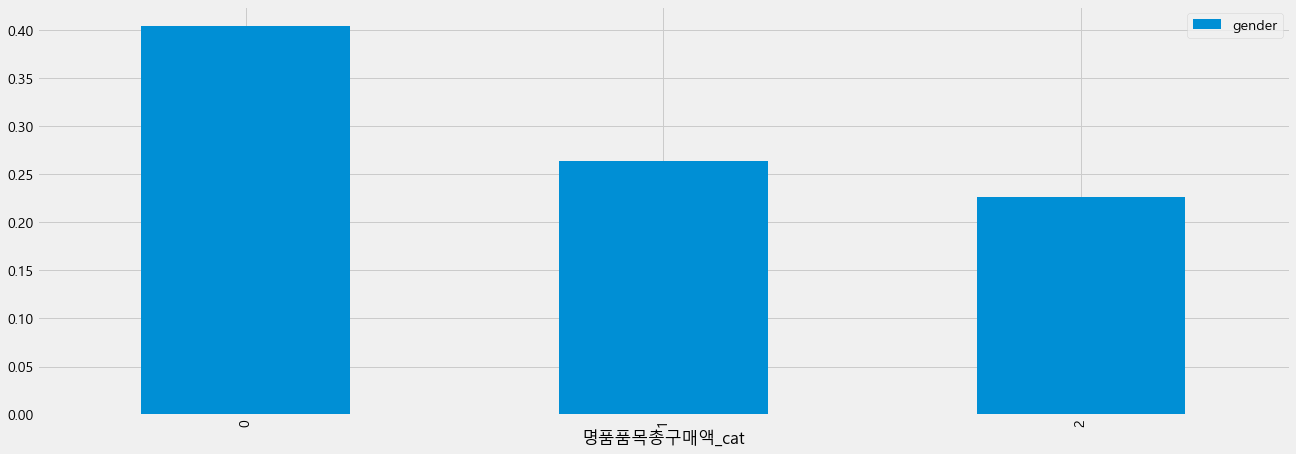

In [153]:
train[['명품품목총구매액_cat','gender']].groupby(['명품품목총구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [154]:
test['명품품목총구매액_cat'] = 0
test.loc[test['명품품목총구매액']<=0,'명품품목총구매액_cat'] = 0
test.loc[(test['명품품목총구매액']>0) & (test['명품품목총구매액']<=10000000),'명품품목총구매액_cat'] = 1
test.loc[test['명품품목총구매액']>10000000,'명품품목총구매액_cat'] = 2
test = test.drop(columns="명품품목총구매액")

### 대형가전품목구매총액

* 대형가전품목을 구매한 고객의 데이터가 적어 데이터가 불충분하다.  
* 또한 구매한 고객들에서도 뚜렷한 트렌드를 찾아볼 수 없었다. (삭제 예정)

In [155]:
train['대형가전품목총구매액_cat'] = 0
train.loc[train['대형가전품목총구매액']>0,'대형가전품목총구매액_cat'] = 1

In [156]:
train.groupby('대형가전품목총구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()


,대형가전품목총구매액_cat,고객수
0,0,3276
1,1,224


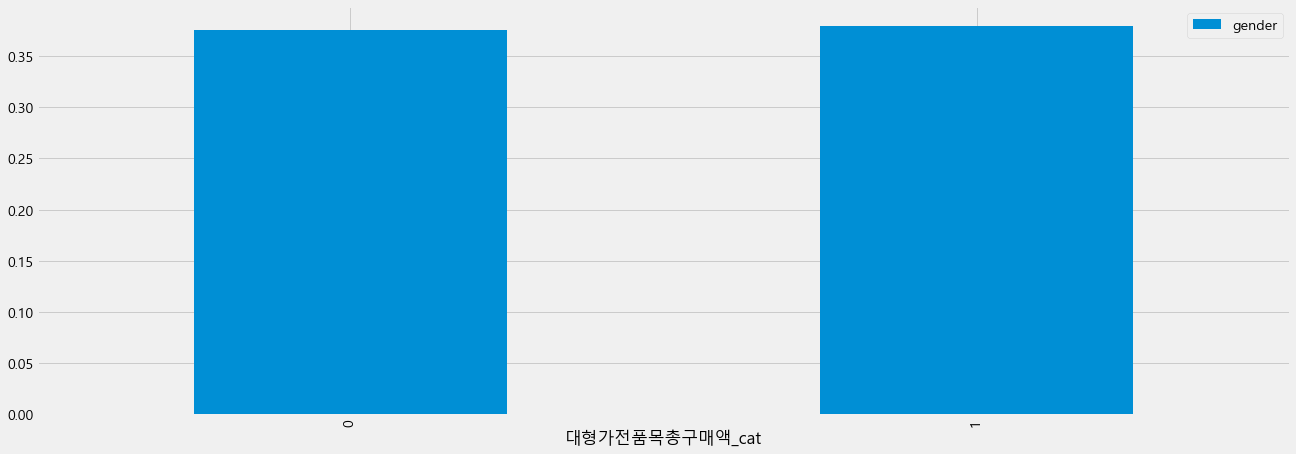

In [157]:
train[['대형가전품목총구매액_cat','gender']].groupby(['대형가전품목총구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [158]:
train = train.drop(columns=["대형가전품목총구매액","대형가전품목총구매액_cat"])
test = test.drop(columns="대형가전품목총구매액")

### 캐주얼품목구매총액

* 캐주얼품목구매총액이 0원일 경우 남성의 비율이 높게 나타났다.

In [159]:
train['캐주얼품목총구매액_cat'] = 0
train.loc[train['캐주얼품목총구매액']<=0,'캐주얼품목총구매액_cat'] = 0
train.loc[(train['캐주얼품목총구매액']>0) & (train['캐주얼품목총구매액']<=10000000),'캐주얼품목총구매액_cat'] = 1
train.loc[train['캐주얼품목총구매액']>10000000,'캐주얼품목총구매액_cat'] = 2
train = train.drop(columns="캐주얼품목총구매액")

In [160]:
train.groupby('캐주얼품목총구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,캐주얼품목총구매액_cat,고객수
0,0,2744
1,1,514
2,2,242


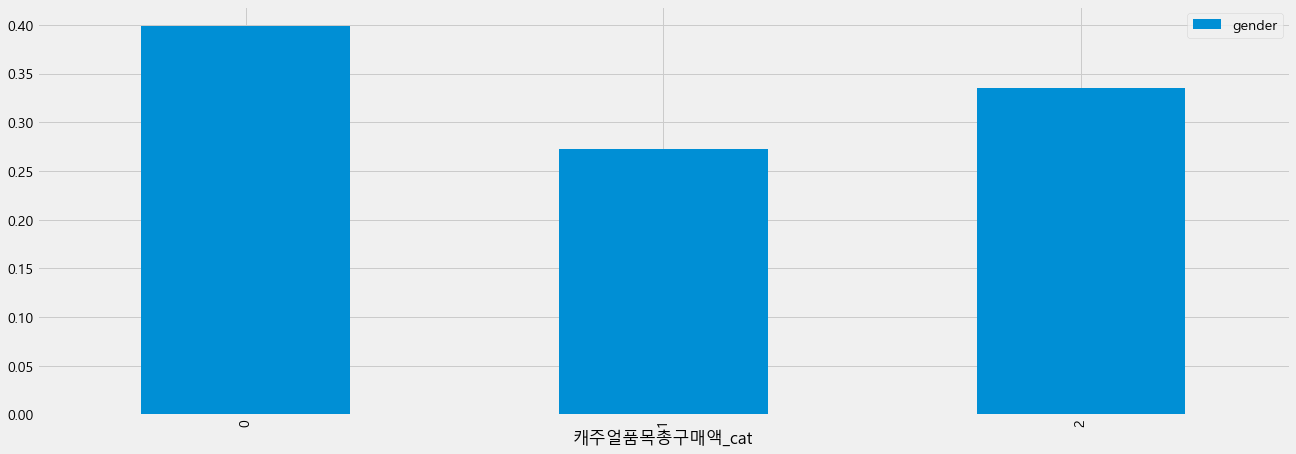

In [161]:
train[['캐주얼품목총구매액_cat','gender']].groupby(['캐주얼품목총구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [162]:
test['캐주얼품목총구매액_cat'] = 0
test.loc[test['캐주얼품목총구매액']<=0,'캐주얼품목총구매액_cat'] = 0
test.loc[(test['캐주얼품목총구매액']>0) & (test['캐주얼품목총구매액']<=10000000),'캐주얼품목총구매액_cat'] = 1
test.loc[test['캐주얼품목총구매액']>10000000,'캐주얼품목총구매액_cat'] = 2
test = test.drop(columns="캐주얼품목총구매액")

### 남성정장품목총구매액

* 남성정장품목의 총구매액이 많을수록 남성의 비율이 높게 나타났다.

In [163]:
train['남성정장품목총구매액_cat'] = 0
train.loc[train['남성정장품목총구매액']==0,'남성정장품목총구매액_cat'] = 0
train.loc[(train['남성정장품목총구매액']>0) & (train['남성정장품목총구매액']<=10000000),'남성정장품목총구매액_cat'] = 1
train.loc[train['남성정장품목총구매액']>10000000,'남성정장품목총구매액_cat'] = 2
train = train.drop(columns="남성정장품목총구매액")

In [164]:
train.groupby('남성정장품목총구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,남성정장품목총구매액_cat,고객수
0,0,2995
1,1,179
2,2,326


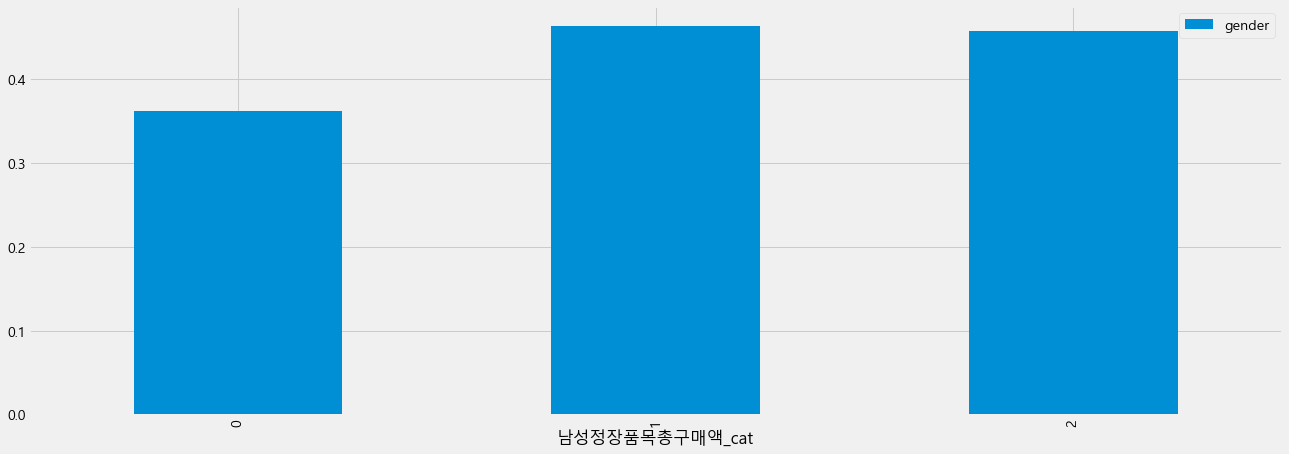

In [165]:
train[['남성정장품목총구매액_cat','gender']].groupby(['남성정장품목총구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [166]:
test['남성정장품목총구매액_cat'] = 0
test.loc[test['남성정장품목총구매액']==0,'남성정장품목총구매액_cat'] = 0
test.loc[(test['남성정장품목총구매액']>0) & (test['남성정장품목총구매액']<=10000000),'남성정장품목총구매액_cat'] = 1
test.loc[test['남성정장품목총구매액']>10000000,'남성정장품목총구매액_cat'] = 2
test = test.drop(columns="남성정장품목총구매액")

### 모피/피혁품목총구매액

* 모피/피혁품목의 총구매액이 낮을수록 남성의 비율이 높게 나타났다.  

In [167]:
train['모피/피혁품목총구매액_cat'] = 0
train.loc[train['모피/피혁품목총구매액']<=0,'모피/피혁품목총구매액_cat'] = 0
train.loc[(train['모피/피혁품목총구매액']>0) & (train['모피/피혁품목총구매액']<=1000000),'모피/피혁품목총구매액_cat'] = 1
train.loc[train['모피/피혁품목총구매액']>1000000,'모피/피혁품목총구매액_cat'] = 2
train = train.drop(columns="모피/피혁품목총구매액")

In [168]:
train.groupby('모피/피혁품목총구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,모피/피혁품목총구매액_cat,고객수
0,0,2931
1,1,189
2,2,380


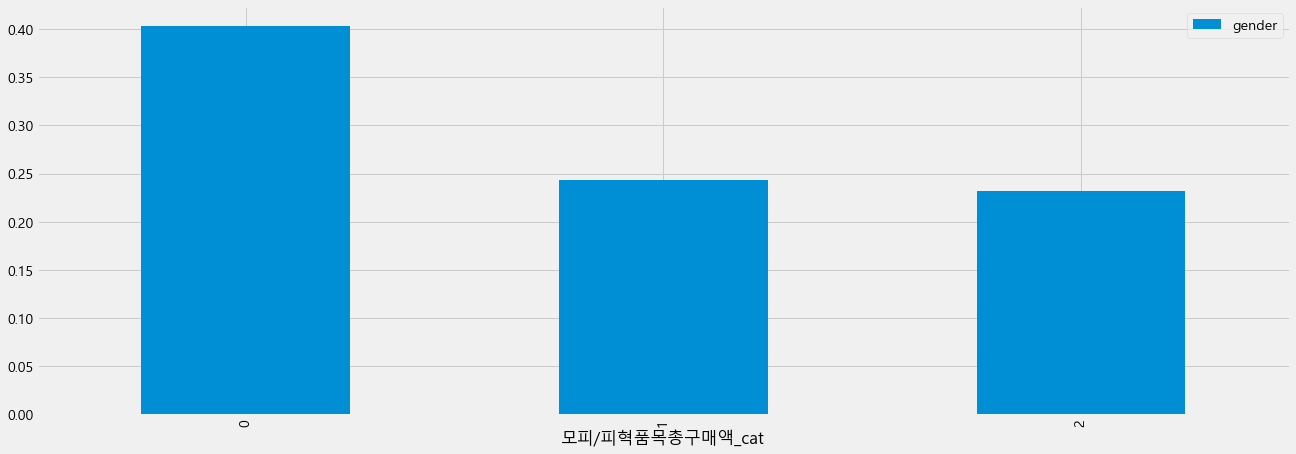

In [169]:
train[['모피/피혁품목총구매액_cat','gender']].groupby(['모피/피혁품목총구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [170]:
test['모피/피혁품목총구매액_cat'] = 0
test.loc[test['모피/피혁품목총구매액']<=0,'모피/피혁품목총구매액_cat'] = 0
test.loc[(test['모피/피혁품목총구매액']>0) & (test['모피/피혁품목총구매액']<=1000000),'모피/피혁품목총구매액_cat'] = 1
test.loc[test['모피/피혁품목총구매액']>1000000,'모피/피혁품목총구매액_cat'] = 2
test = test.drop(columns="모피/피혁품목총구매액")

### 아동품목총구매액

* 아동품목의 총구매액이 낮을수록 남성의 비율이 높게 나타났다.  

In [171]:
train['아동품목총구매액_cat'] = 0
train.loc[train['아동품목총구매액']<=0,'아동품목총구매액_cat'] = 0
train.loc[(train['아동품목총구매액']>0) & (train['아동품목총구매액']<=10000000),'아동품목총구매액_cat'] = 1
train.loc[train['아동품목총구매액']>10000000,'아동품목총구매액_cat'] = 2
train = train.drop(columns="아동품목총구매액")

In [172]:
train.groupby('아동품목총구매액_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,아동품목총구매액_cat,고객수
0,0,2976
1,1,361
2,2,163


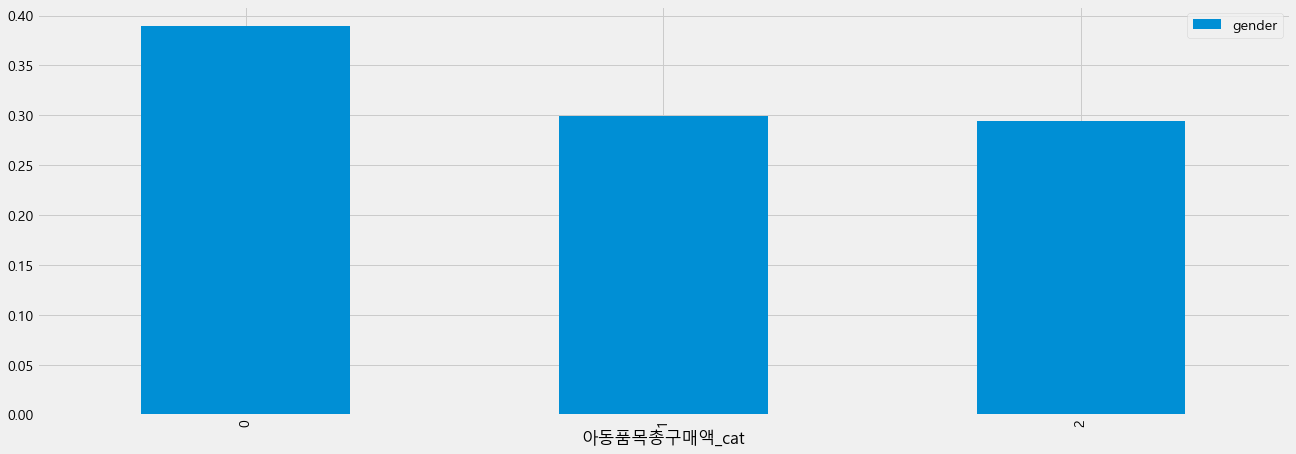

In [173]:
train[['아동품목총구매액_cat','gender']].groupby(['아동품목총구매액_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [174]:
test['아동품목총구매액_cat'] = 0
test.loc[test['아동품목총구매액']<=0,'아동품목총구매액_cat'] = 0
test.loc[(test['아동품목총구매액']>0) & (test['아동품목총구매액']<=10000000),'아동품목총구매액_cat'] = 1
test.loc[test['아동품목총구매액']>10000000,'아동품목총구매액_cat'] = 2
test = test.drop(columns="아동품목총구매액")

### 베스트셀러 (TOP10) 품목 구매건수

* 총 구매건수 feature와 베스트셀러 각 품목의 구매건수 feature들 중 일부의 상관관계 높게 관찰되었다.  
* 또한 그 feature들 간의 상관관계도 높은 값을 보였다.  
* 따라서 일부 feature들은 탈락 시키고 사용할 예정이다.

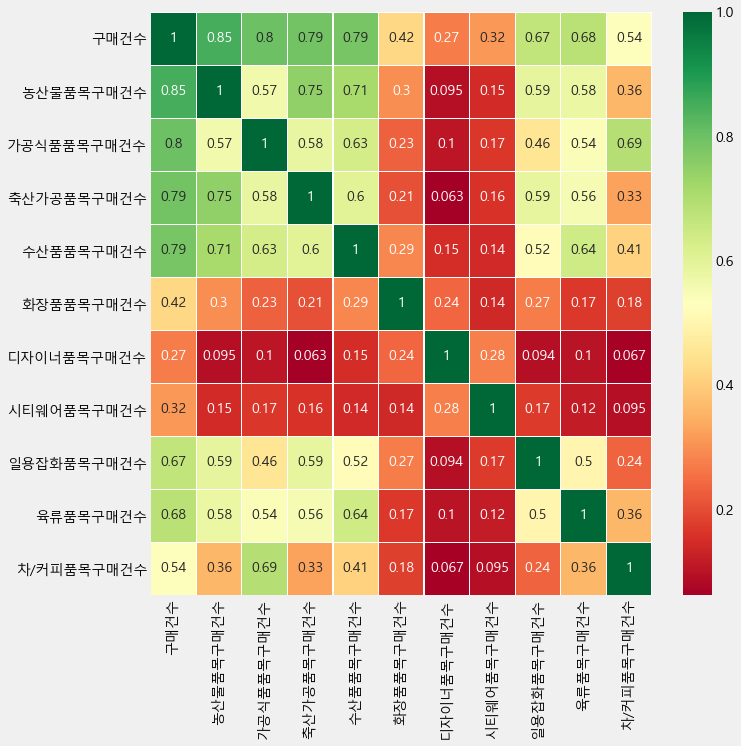

In [175]:
sns.heatmap(train[train.columns[[1,8,9,10,11,12,13,14,15,16,17]]].corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [176]:
train = train.drop(columns=["구매건수",'농산물품목구매건수','가공식품품목구매건수', '축산가공품목구매건수','수산품품목구매건수'])
test = test.drop(columns=['농산물품목구매건수','가공식품품목구매건수', '축산가공품목구매건수','수산품품목구매건수'])

* 위에서 0.5 미만의 상관관계를 보인 3가지 feature들은 앞서 분석한 각각의 항목의 총구매액 feature들과의 상관관계가 높게 나타났다.  
* 따라서 같은 품목의 구매건수 feature들 또한 삭제할 예정이다.

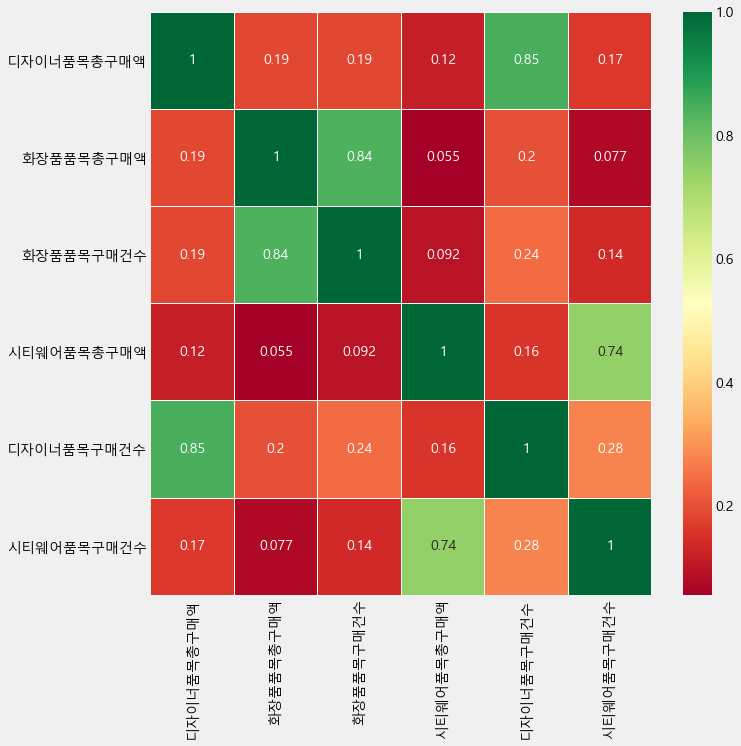

In [177]:
sns.heatmap(train[train.columns[[4,5,7,6,8,9]]].corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [178]:
train = train.drop(columns=["시티웨어품목총구매액","화장품품목총구매액",
                            "디자이너품목총구매액",'화장품품목구매건수', '디자이너품목구매건수', '시티웨어품목구매건수'])
test = test.drop(columns=['화장품품목구매건수', '디자이너품목구매건수', '시티웨어품목구매건수'])

### 일용잡화품목구매건수

* 일용잡화품목의 구매건수가 적을수록 남성의 비율이 높게 나타났다. 

In [179]:
train['일용잡화품목구매건수_cat'] = 0
train.loc[train['일용잡화품목구매건수']<=3,'일용잡화품목구매건수_cat'] = 0
train.loc[(train['일용잡화품목구매건수']>3) & (train['일용잡화품목구매건수']<=10),'일용잡화품목구매건수_cat'] = 1
train.loc[train['일용잡화품목구매건수']>10,'일용잡화품목구매건수_cat'] = 2
train = train.drop(columns="일용잡화품목구매건수")

In [180]:
train.groupby('일용잡화품목구매건수_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,일용잡화품목구매건수_cat,고객수
0,0,3003
1,1,337
2,2,160


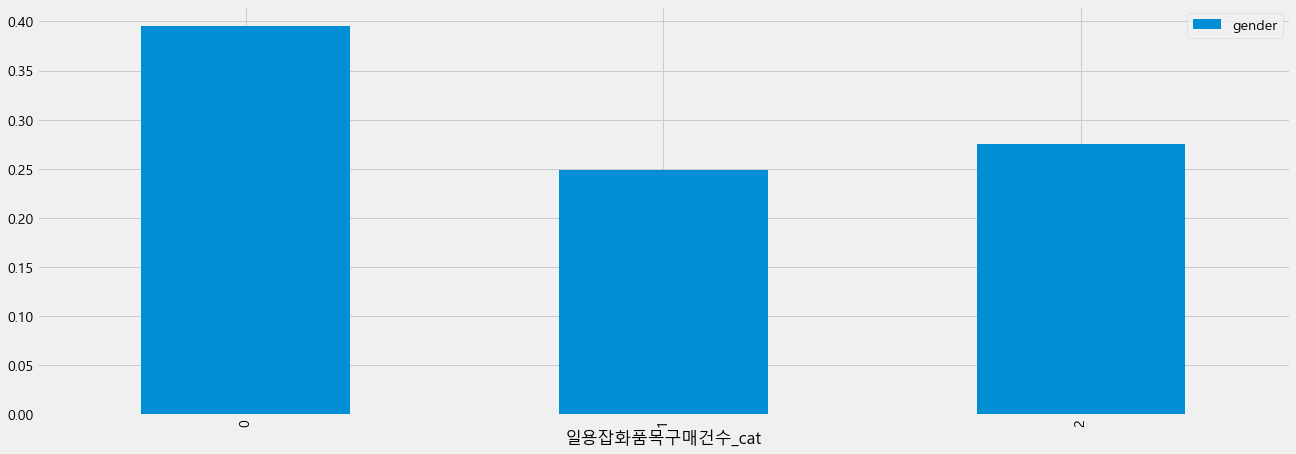

In [181]:
train[['일용잡화품목구매건수_cat','gender']].groupby(['일용잡화품목구매건수_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [182]:
test['일용잡화품목구매건수_cat'] = 0
test.loc[test['일용잡화품목구매건수']<=3,'일용잡화품목구매건수_cat'] = 0
test.loc[(test['일용잡화품목구매건수']>3) & (test['일용잡화품목구매건수']<=10),'일용잡화품목구매건수_cat'] = 1
test.loc[test['일용잡화품목구매건수']>10,'일용잡화품목구매건수_cat'] = 2
test = test.drop(columns="일용잡화품목구매건수")

### 육류품목구매건수

* 육류품목의 구매건수가 적을수록 남성의 비율이 높게 나타났다.  

In [183]:
train['육류품목구매건수_cat'] = 0
train.loc[train['육류품목구매건수']<=3,'육류품목구매건수_cat'] = 0
train.loc[(train['육류품목구매건수']>3) & (train['육류품목구매건수']<=10),'육류품목구매건수_cat'] = 1
train.loc[train['육류품목구매건수']>10,'육류품목구매건수_cat'] = 2
train = train.drop(columns="육류품목구매건수")

In [184]:
train.groupby('육류품목구매건수_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,육류품목구매건수_cat,고객수
0,0,3055
1,1,298
2,2,147


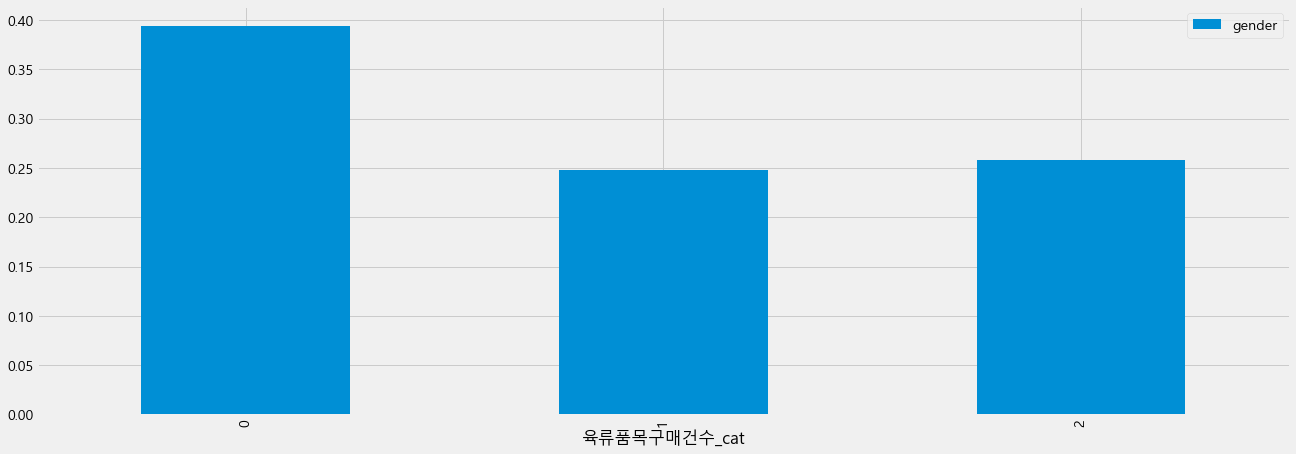

In [185]:
train[['육류품목구매건수_cat','gender']].groupby(['육류품목구매건수_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [186]:
test['육류품목구매건수_cat'] = 0
test.loc[test['육류품목구매건수']<=3,'육류품목구매건수_cat'] = 0
test.loc[(test['육류품목구매건수']>3) & (test['육류품목구매건수']<=10),'육류품목구매건수_cat'] = 1
test.loc[test['육류품목구매건수']>10,'육류품목구매건수_cat'] = 2
test = test.drop(columns="육류품목구매건수")

### 차/커피품목구매건수

* 차/커피품목의 구매건수가 적을수록 남성의 비율이 높게 나타났다.

In [187]:
train['차/커피품목구매건수_cat'] = 0
train.loc[train['차/커피품목구매건수']<=3,'차/커피품목구매건수_cat'] = 0
train.loc[(train['차/커피품목구매건수']>3) & (train['차/커피품목구매건수']<=10),'차/커피품목구매건수_cat'] = 1
train.loc[train['차/커피품목구매건수']>10,'차/커피품목구매건수_cat'] = 2
train = train.drop(columns="차/커피품목구매건수")

In [188]:
train.groupby('차/커피품목구매건수_cat')['gender'].agg([('고객수',np.size)]).reset_index()

,차/커피품목구매건수_cat,고객수
0,0,3057
1,1,320
2,2,123


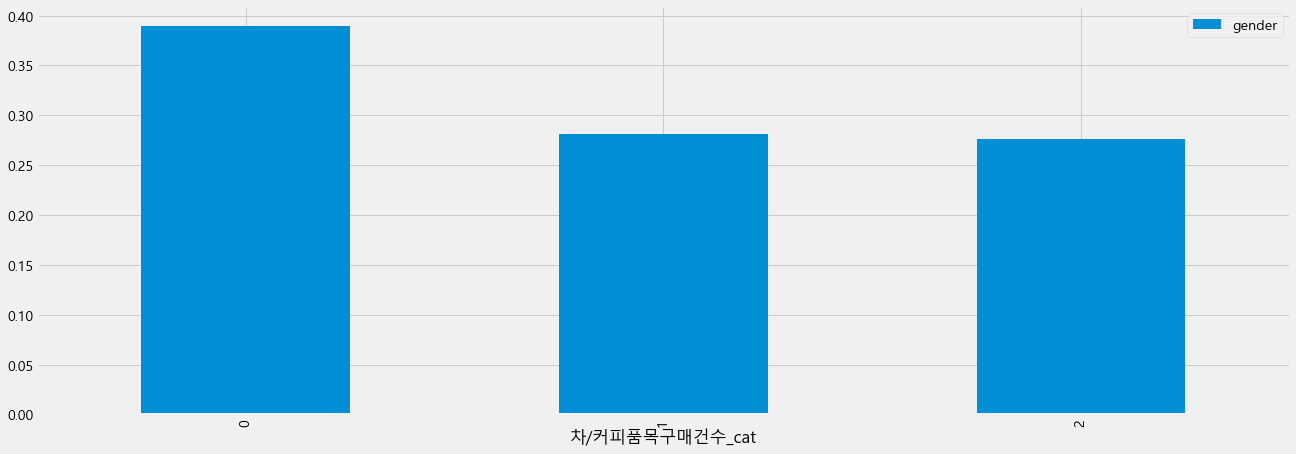

In [189]:
train[['차/커피품목구매건수_cat','gender']].groupby(['차/커피품목구매건수_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [190]:
test['차/커피품목구매건수_cat'] = 0
test.loc[test['차/커피품목구매건수']<=3,'차/커피품목구매건수_cat'] = 0
test.loc[(test['차/커피품목구매건수']>3) & (test['차/커피품목구매건수']<=10),'차/커피품목구매건수_cat'] = 1
test.loc[test['차/커피품목구매건수']>10,'차/커피품목구매건수_cat'] = 2
test = test.drop(columns="차/커피품목구매건수")

## 베스트셀러 (TOP10) 품목 구매여부

### 농산물품목구매여부

* 농산물품목을 구매하지 않았을 경우 남성의 비율이 높게 나타났다.

In [191]:
train.groupby('농산물품목구매여부')['gender'].agg([('고객수',np.size)]).reset_index()

,농산물품목구매여부,고객수
0,False,1795
1,True,1705


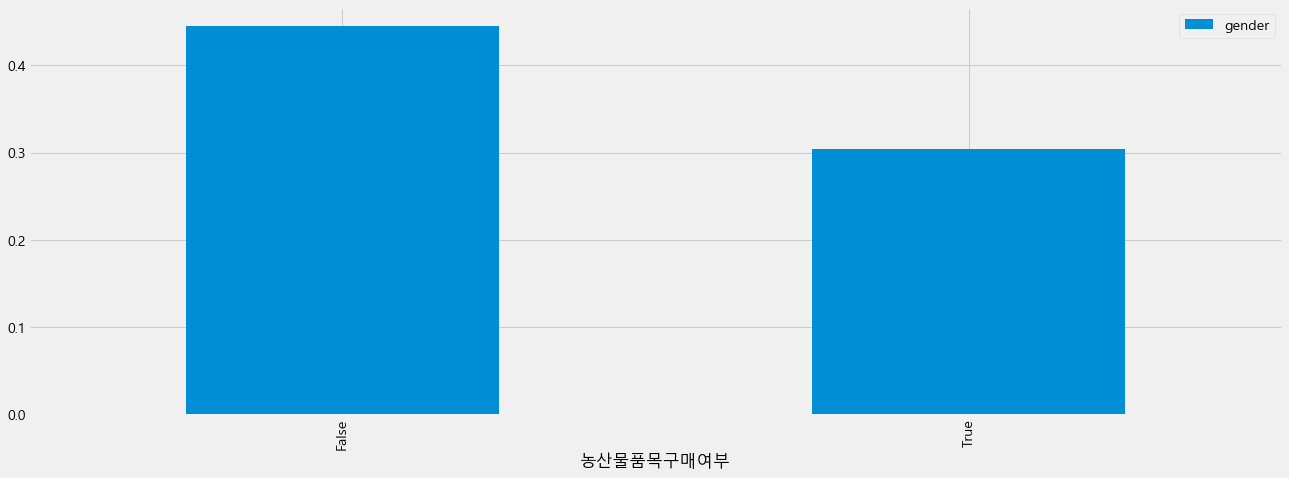

In [192]:
train[['농산물품목구매여부','gender']].groupby(['농산물품목구매여부']).mean().plot.bar(figsize=(20,7))
plt.show()

### 가공식품품목구매여부

* 가공식품품목을 구매하지 않았을 경우 남성의 비율이 높게 나타났다.

In [193]:
train.groupby('가공식품품목구매여부')['gender'].agg([('고객수',np.size)]).reset_index()

,가공식품품목구매여부,고객수
0,False,1503
1,True,1997


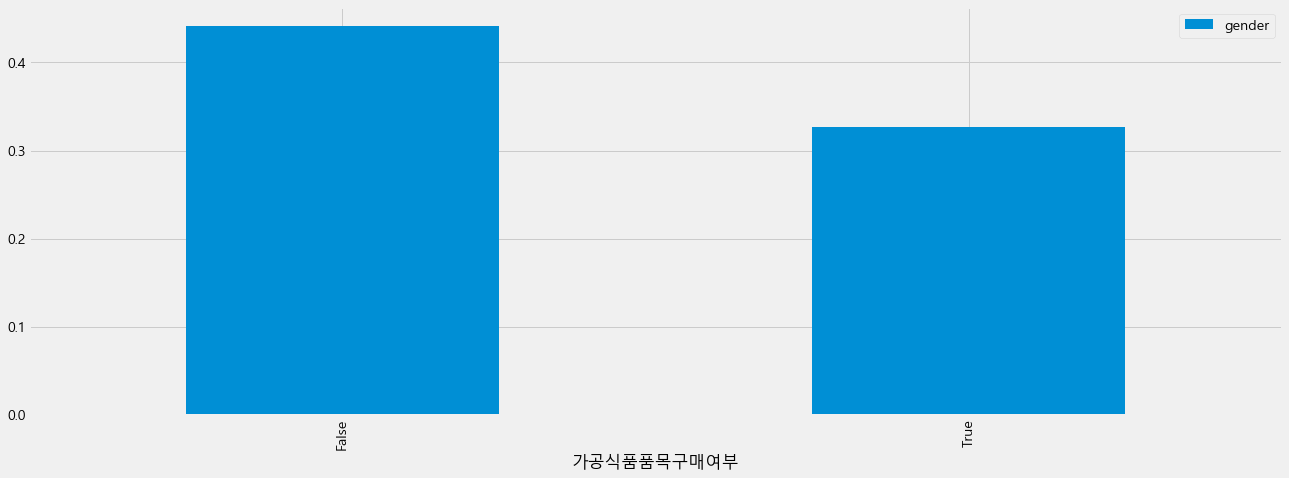

In [194]:
train[['가공식품품목구매여부','gender']].groupby(['가공식품품목구매여부']).mean().plot.bar(figsize=(20,7))
plt.show()

### 축산가공물품목구매여부

* 축산가공품목을 구매하지 않았을 경우 남성의 비율이 높게 나타났다.

In [195]:
train.groupby('축산가공품목구매여부')['gender'].agg([('고객수',np.size)]).reset_index()

,축산가공품목구매여부,고객수
0,False,2352
1,True,1148


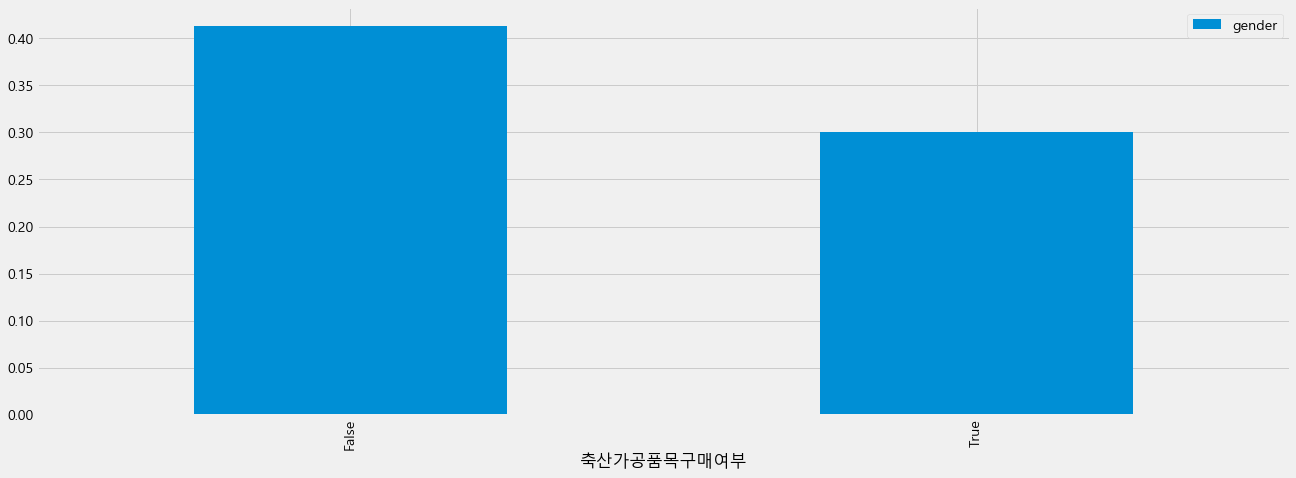

In [196]:
train[['축산가공품목구매여부','gender']].groupby(['축산가공품목구매여부']).mean().plot.bar(figsize=(20,7))
plt.show()

### 수산품품목구매여부

* 수산품품목을 구매하지 않았을 경우 남성의 비율이 높게 나타났다.

In [197]:
train.groupby('수산품품목구매여부')['gender'].agg([('고객수',np.size)]).reset_index()

,수산품품목구매여부,고객수
0,False,1844
1,True,1656


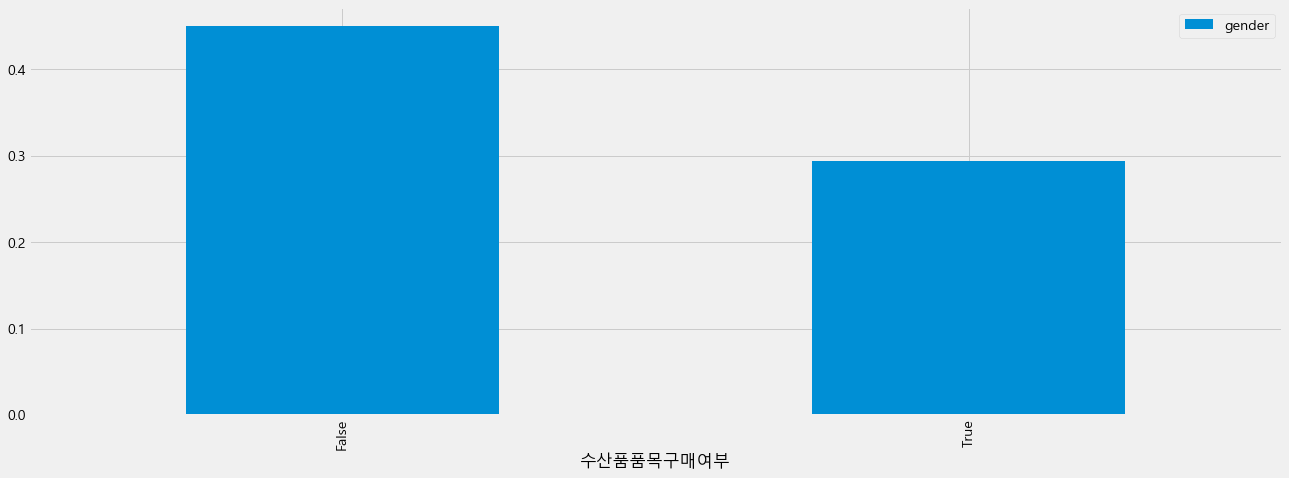

In [198]:
train[['수산품품목구매여부','gender']].groupby(['수산품품목구매여부']).mean().plot.bar(figsize=(20,7))
plt.show()

### 화장품품목구매여부

* 화장품품목을 구매하지 않았을 경우 남성의 비율이 높게 나타났다.

In [199]:
train.groupby('화장품품목구매여부')['gender'].agg([('고객수',np.size)]).reset_index()

,화장품품목구매여부,고객수
0,False,1886
1,True,1614


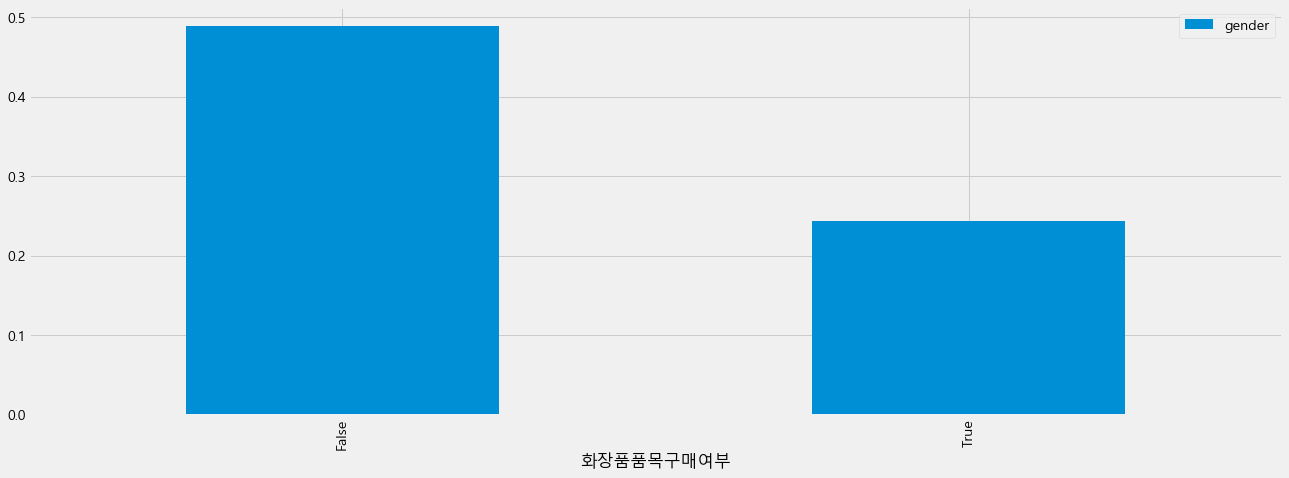

In [200]:
train[['화장품품목구매여부','gender']].groupby(['화장품품목구매여부']).mean().plot.bar(figsize=(20,7))
plt.show()

### 디자이너품목구매여부

* 디자이너품목을 구매하지 않았을 경우 남성의 비율이 높게 나타났다.

In [201]:
train.groupby('디자이너품목구매여부')['gender'].agg([('고객수',np.size)]).reset_index()

,디자이너품목구매여부,고객수
0,False,2352
1,True,1148


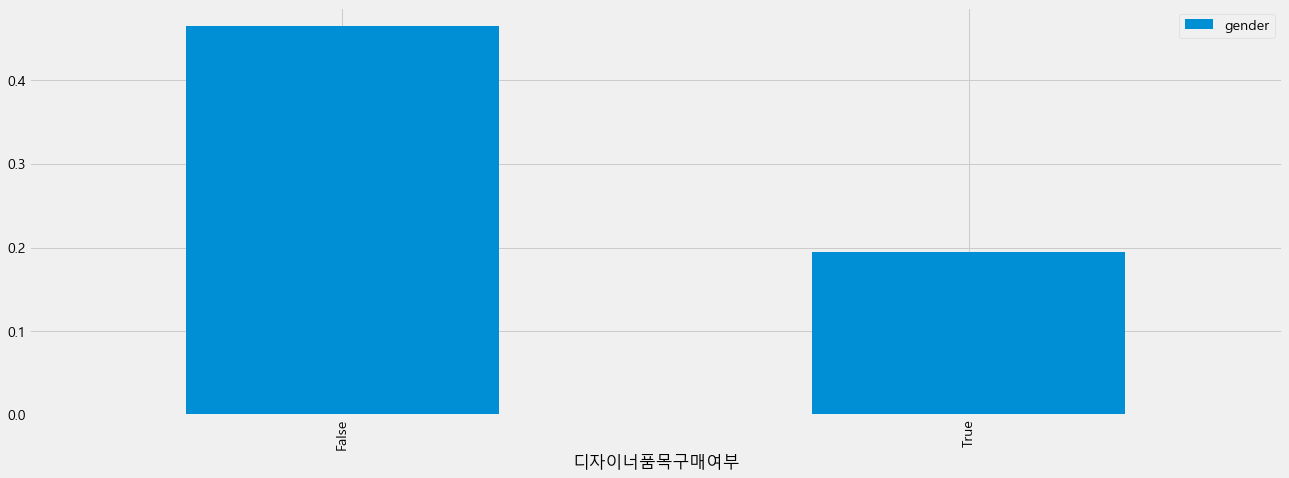

In [202]:
train[['디자이너품목구매여부','gender']].groupby(['디자이너품목구매여부']).mean().plot.bar(figsize=(20,7))
plt.show()

### 시티웨어품목구매여부

* 시티웨어품목을 구매하지 않았을 경우 남성의 비율이 높게 나타났다.

In [203]:
train.groupby('시티웨어품목구매여부')['gender'].agg([('고객수',np.size)]).reset_index()

,시티웨어품목구매여부,고객수
0,False,2094
1,True,1406


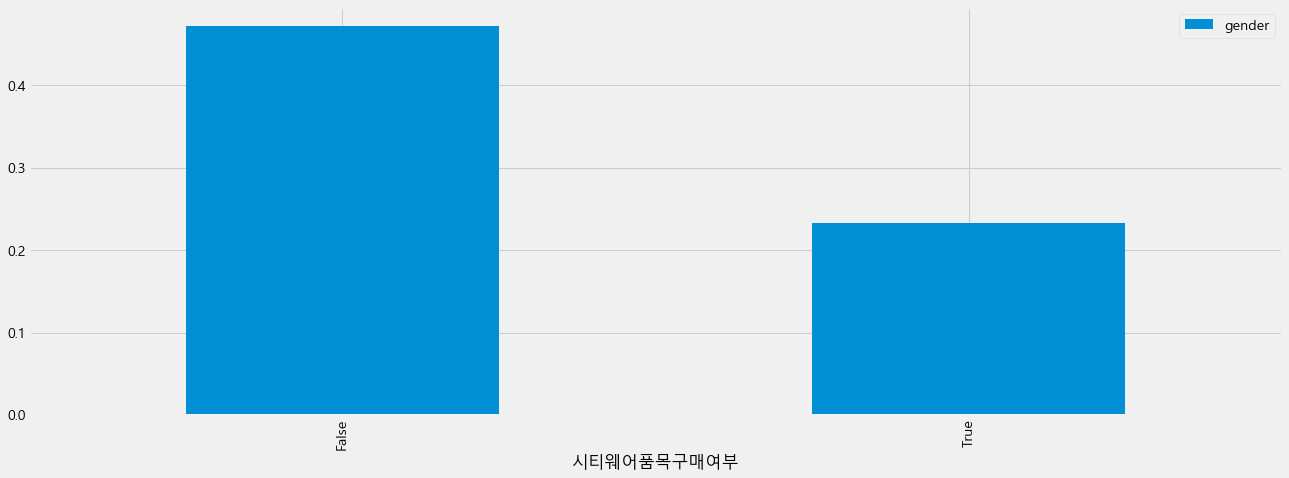

In [204]:
train[['시티웨어품목구매여부','gender']].groupby(['시티웨어품목구매여부']).mean().plot.bar(figsize=(20,7))
plt.show()

### 일용잡화품목구매여부

* 일용잡화품목을 구매하지 않았을 경우 남성의 비율이 더 높게 나타났다.

In [205]:
train.groupby('일용잡화품목구매여부')['gender'].agg([('고객수',np.size)]).reset_index()

,일용잡화품목구매여부,고객수
0,False,2261
1,True,1239


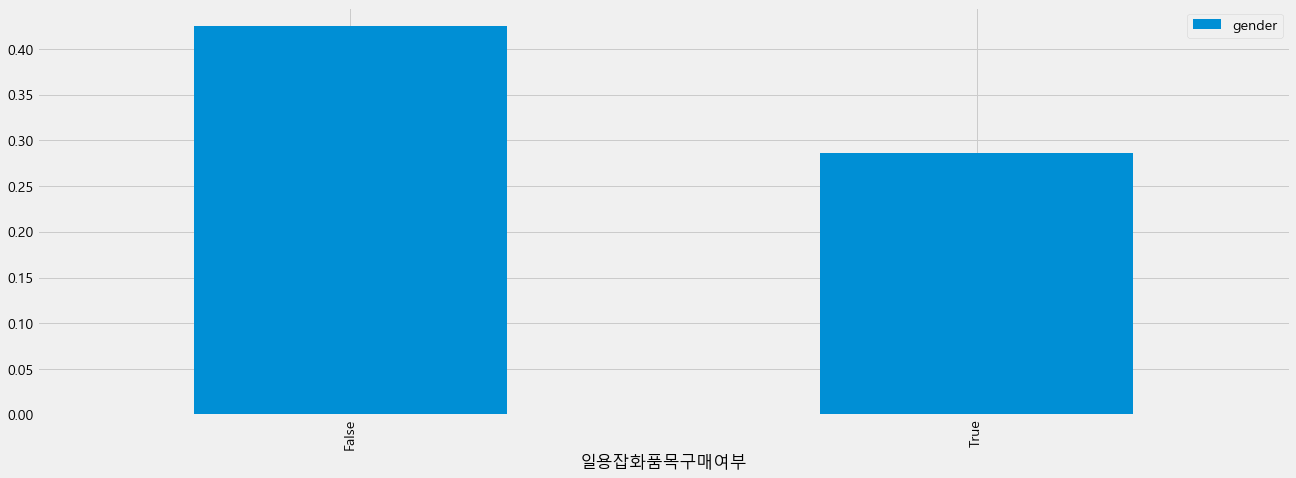

In [206]:
train[['일용잡화품목구매여부','gender']].groupby(['일용잡화품목구매여부']).mean().plot.bar(figsize=(20,7))
plt.show()

### 육류품목구매여부

* 육류품목을 구매하지 않았을 경우 남성의 비율이 더 높게 나타났다.

In [207]:
train.groupby('육류품목구매여부')['gender'].agg([('고객수',np.size)]).reset_index()

,육류품목구매여부,고객수
0,False,2337
1,True,1163


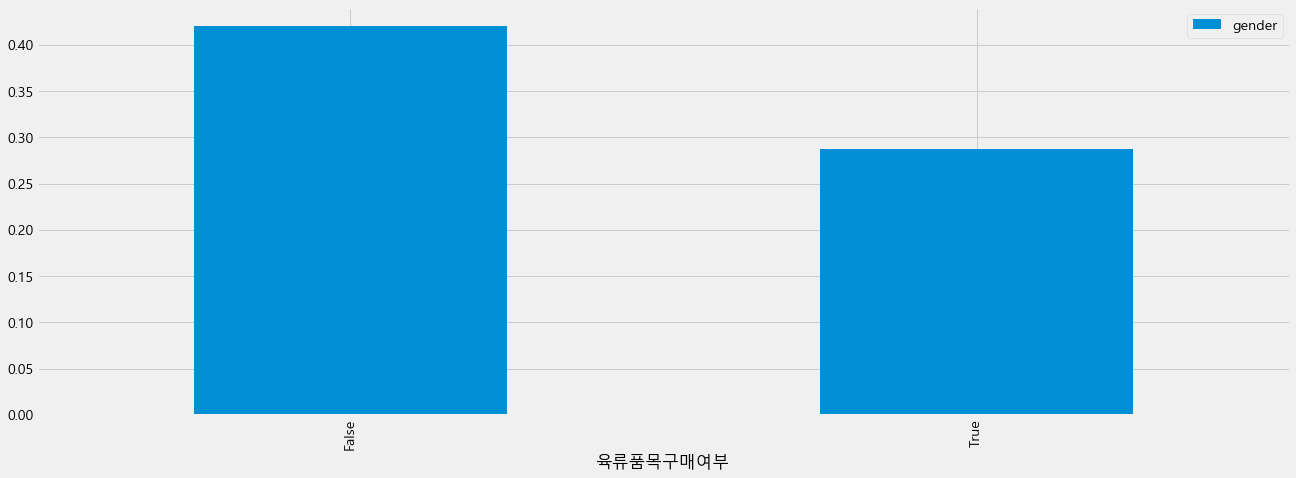

In [208]:
train[['육류품목구매여부','gender']].groupby(['육류품목구매여부']).mean().plot.bar(figsize=(20,7))
plt.show()

### 차/커피품목구매여부

* 차/커피품목을 구매하지 않았을 경우 남성의 비율이 높게 나타났다.

In [209]:
train.groupby('차/커피품목구매여부')['gender'].agg([('고객수',np.size)]).reset_index()

,차/커피품목구매여부,고객수
0,False,2307
1,True,1193


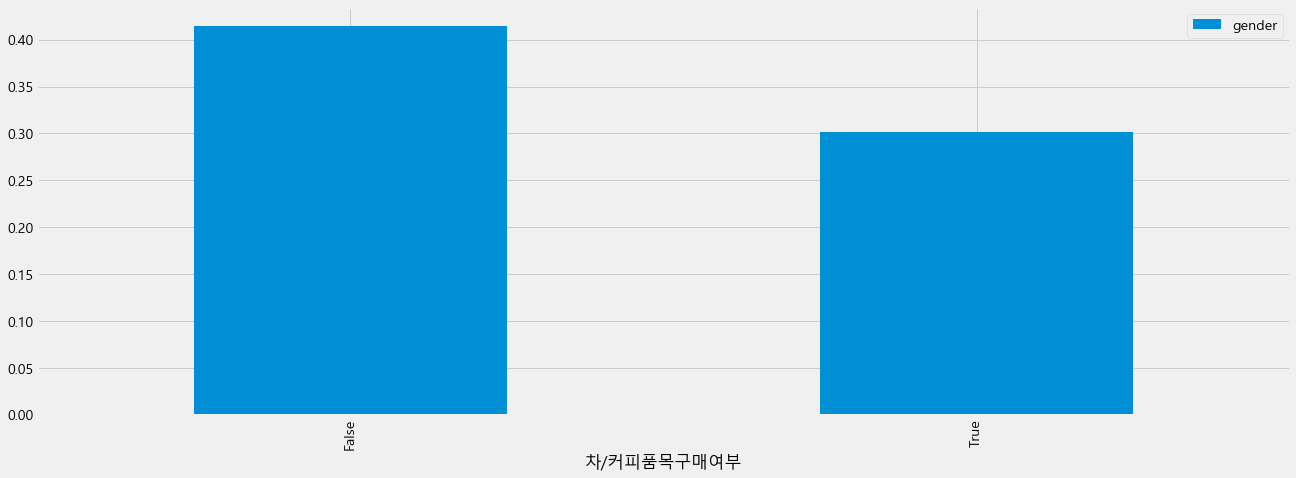

In [210]:
train[['차/커피품목구매여부','gender']].groupby(['차/커피품목구매여부']).mean().plot.bar(figsize=(20,7))
plt.show()

### <span style="color:red"> *  추가 Features</span>


### 남성/여성 상품 구매총액/건수 비율

In [211]:
train['남성상품구매총액비율2'] = pd.qcut(train['남성상품구매총액비율'], 4)
train.groupby(['남성상품구매총액비율2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
남성상품구매총액비율2,
"(-0.0010000382, 0.0]",0.339574
"(0.0, 1.14e-08]",0.154229
"(1.14e-08, 6.55e-08]",0.309714
"(6.55e-08, inf]",0.557714


In [212]:
train['남성상품구매총액비율_cat'] = 0
train.loc[train['남성상품구매총액비율']<=0,'남성상품구매총액비율_cat'] = 0
train.loc[(train['남성상품구매총액비율']>0) & (train['남성상품구매총액비율']<=0.0000000114),'남성상품구매총액비율_cat'] = 1
train.loc[(train['남성상품구매총액비율']>0.0000000114) & (train['남성상품구매총액비율']<=0.0000000655),'남성상품구매총액비율_cat'] = 2
train.loc[train['남성상품구매총액비율']>0.0000000655,'남성상품구매총액비율_cat'] = 3
train = train.drop(columns=["남성상품구매총액비율",'남성상품구매총액비율2'])

In [213]:
train.groupby('남성상품구매총액비율_cat')['gender'].agg([('트랜잭션건수',np.size)]).reset_index()

,남성상품구매총액비율_cat,트랜잭션건수
0,0,1549
1,1,201
2,2,875
3,3,875


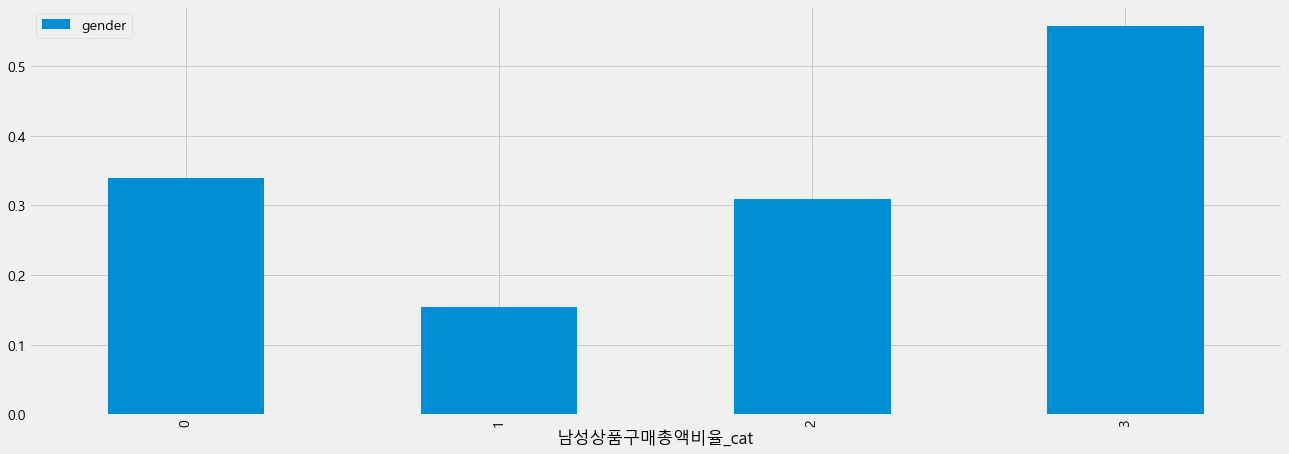

In [214]:
train[['남성상품구매총액비율_cat','gender']].groupby(['남성상품구매총액비율_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [215]:
test['남성상품구매총액비율_cat'] = 0
test.loc[test['남성상품구매총액비율']<=0,'남성상품구매총액비율_cat'] = 0
test.loc[(test['남성상품구매총액비율']>0) & (test['남성상품구매총액비율']<=0.0000000114),'남성상품구매총액비율_cat'] = 1
test.loc[(test['남성상품구매총액비율']>0.0000000114) & (test['남성상품구매총액비율']<=0.0000000655),'남성상품구매총액비율_cat'] = 2
test.loc[test['남성상품구매총액비율']>0.0000000655,'남성상품구매총액비율_cat'] = 3
test = test.drop(columns='남성상품구매총액비율')

In [216]:
train['여성상품구매총액비율2'] = pd.qcut(train['여성상품구매총액비율'], 14)
train.groupby(['여성상품구매총액비율2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
여성상품구매총액비율2,
"(-0.00100169, 0.0]",0.683084
"(0.0, 2.17e-08]",0.666667
"(2.17e-08, 7.49e-08]",0.468000
"(7.49e-08, 1.12e-07]",0.392000
"(1.12e-07, 1.49e-07]",0.328000
"(1.49e-07, 1.93e-07]",0.316000
"(1.93e-07, 2.43e-07]",0.248000
"(2.43e-07, 3.04e-07]",0.300000
"(3.04e-07, 3.77e-07]",0.260000


In [217]:
train['여성상품구매총액비율_cat'] = 0
train.loc[train['여성상품구매총액비율']<=0,'여성상품구매총액비율_cat'] = 0
train.loc[(train['여성상품구매총액비율']>0) & (train['여성상품구매총액비율']<=0.0000000217),'여성상품구매총액비율_cat'] = 1
train.loc[(train['여성상품구매총액비율']>0.0000000217) & (train['여성상품구매총액비율']<=0.0000000749),'여성상품구매총액비율_cat'] = 2
train.loc[(train['여성상품구매총액비율']>0.0000000749) & (train['여성상품구매총액비율']<=0.000000112),'여성상품구매총액비율_cat'] = 3
train.loc[(train['여성상품구매총액비율']>0.000000112) & (train['여성상품구매총액비율']<=0.000000149),'여성상품구매총액비율_cat'] = 4
train.loc[(train['여성상품구매총액비율']>0.000000149) & (train['여성상품구매총액비율']<=0.000000193),'여성상품구매총액비율_cat'] = 5
train.loc[(train['여성상품구매총액비율']>0.000000193) & (train['여성상품구매총액비율']<=0.000000243),'여성상품구매총액비율_cat'] = 6
train.loc[(train['여성상품구매총액비율']>0.000000243) & (train['여성상품구매총액비율']<=0.000000304),'여성상품구매총액비율_cat'] = 7
train.loc[(train['여성상품구매총액비율']>0.000000304) & (train['여성상품구매총액비율']<=0.000000377),'여성상품구매총액비율_cat'] = 8
train.loc[(train['여성상품구매총액비율']>0.000000377) & (train['여성상품구매총액비율']<=0.000000497),'여성상품구매총액비율_cat'] = 9
train.loc[(train['여성상품구매총액비율']>0.000000497) & (train['여성상품구매총액비율']<=0.000000704),'여성상품구매총액비율_cat'] = 10
train.loc[(train['여성상품구매총액비율']>0.000000704) & (train['여성상품구매총액비율']<=0.00000108),'여성상품구매총액비율_cat'] = 11
train.loc[(train['여성상품구매총액비율']>0.00000108) & (train['여성상품구매총액비율']<=0.00000208),'여성상품구매총액비율_cat'] = 12
train.loc[train['여성상품구매총액비율']>0.00000208,'여성상품구매총액비율_cat'] = 13
train = train.drop(columns=["여성상품구매총액비율",'여성상품구매총액비율2'])

In [218]:
train.groupby('여성상품구매총액비율_cat')['gender'].agg([('트랜잭션건수',np.size)]).reset_index()

,여성상품구매총액비율_cat,트랜잭션건수
0,0,467
1,1,33
2,2,250
3,3,251
4,4,244
5,5,254
6,6,251
7,7,252
8,8,246
9,9,252


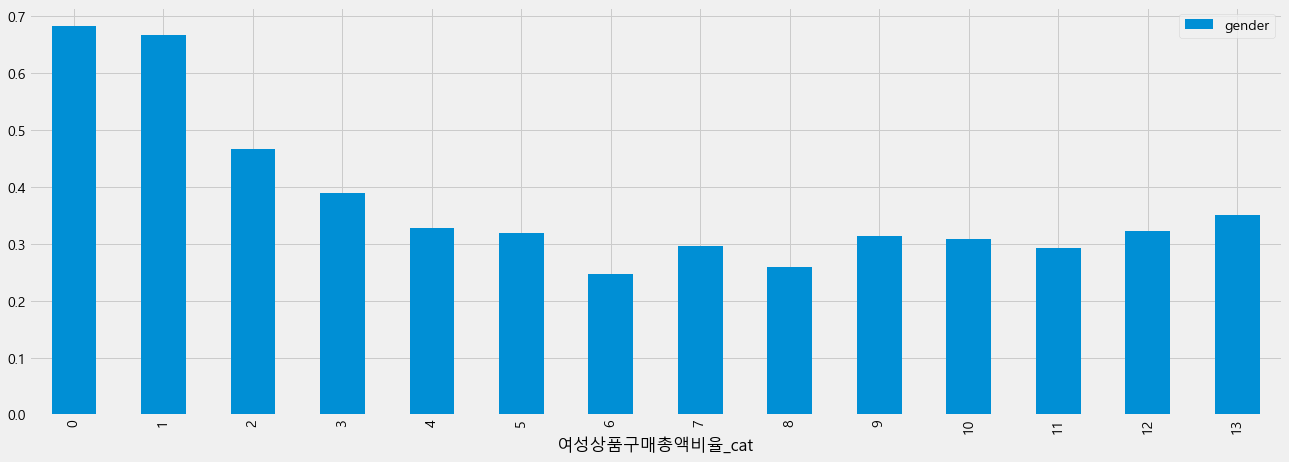

In [219]:
train[['여성상품구매총액비율_cat','gender']].groupby(['여성상품구매총액비율_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [220]:
test['여성상품구매총액비율_cat'] = 0
test.loc[test['여성상품구매총액비율']<=0,'여성상품구매총액비율_cat'] = 0
test.loc[(test['여성상품구매총액비율']>0) & (test['여성상품구매총액비율']<=0.0000000217),'여성상품구매총액비율_cat'] = 1
test.loc[(test['여성상품구매총액비율']>0.0000000217) & (test['여성상품구매총액비율']<=0.0000000749),'여성상품구매총액비율_cat'] = 2
test.loc[(test['여성상품구매총액비율']>0.0000000749) & (test['여성상품구매총액비율']<=0.000000112),'여성상품구매총액비율_cat'] = 3
test.loc[(test['여성상품구매총액비율']>0.000000112) & (test['여성상품구매총액비율']<=0.000000149),'여성상품구매총액비율_cat'] = 4
test.loc[(test['여성상품구매총액비율']>0.000000149) & (test['여성상품구매총액비율']<=0.000000193),'여성상품구매총액비율_cat'] = 5
test.loc[(test['여성상품구매총액비율']>0.000000193) & (test['여성상품구매총액비율']<=0.000000243),'여성상품구매총액비율_cat'] = 6
test.loc[(test['여성상품구매총액비율']>0.000000243) & (test['여성상품구매총액비율']<=0.000000304),'여성상품구매총액비율_cat'] = 7
test.loc[(test['여성상품구매총액비율']>0.000000304) & (test['여성상품구매총액비율']<=0.000000377),'여성상품구매총액비율_cat'] = 8
test.loc[(test['여성상품구매총액비율']>0.000000377) & (test['여성상품구매총액비율']<=0.000000497),'여성상품구매총액비율_cat'] = 9
test.loc[(test['여성상품구매총액비율']>0.000000497) & (test['여성상품구매총액비율']<=0.000000704),'여성상품구매총액비율_cat'] = 10
test.loc[(test['여성상품구매총액비율']>0.000000704) & (test['여성상품구매총액비율']<=0.00000108),'여성상품구매총액비율_cat'] = 11
test.loc[(test['여성상품구매총액비율']>0.00000108) & (test['여성상품구매총액비율']<=0.00000208),'여성상품구매총액비율_cat'] = 12
test.loc[test['여성상품구매총액비율']>0.00000208,'여성상품구매총액비율_cat'] = 13
test = test.drop(columns="여성상품구매총액비율")

In [221]:
train['남성상품구매건수비율2'] = pd.cut(train['남성상품구매건수비율'], 5)
train.groupby(['남성상품구매건수비율2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
남성상품구매건수비율2,
"(-0.001, 0.2]",0.329656
"(0.2, 0.4]",0.677824
"(0.4, 0.6]",0.741935
"(0.6, 0.8]",0.777778
"(0.8, 1.0]",0.813559


In [222]:
train['남성상품구매건수비율_cat'] = 0
train.loc[train['남성상품구매건수비율']<=0.2,'남성상품구매건수비율_cat'] = 0
train.loc[(train['남성상품구매건수비율']>0.2) & (train['남성상품구매건수비율']<=0.4),'남성상품구매건수비율_cat'] = 1
train.loc[train['남성상품구매건수비율']>0.4,'남성상품구매건수비율_cat'] = 2
train = train.drop(columns=["남성상품구매건수비율",'남성상품구매건수비율2'])

In [223]:
train.groupby('남성상품구매건수비율_cat')['gender'].agg([('트랜잭션건수',np.size)]).reset_index()

,남성상품구매건수비율_cat,트랜잭션건수
0,0,3082
1,1,239
2,2,179


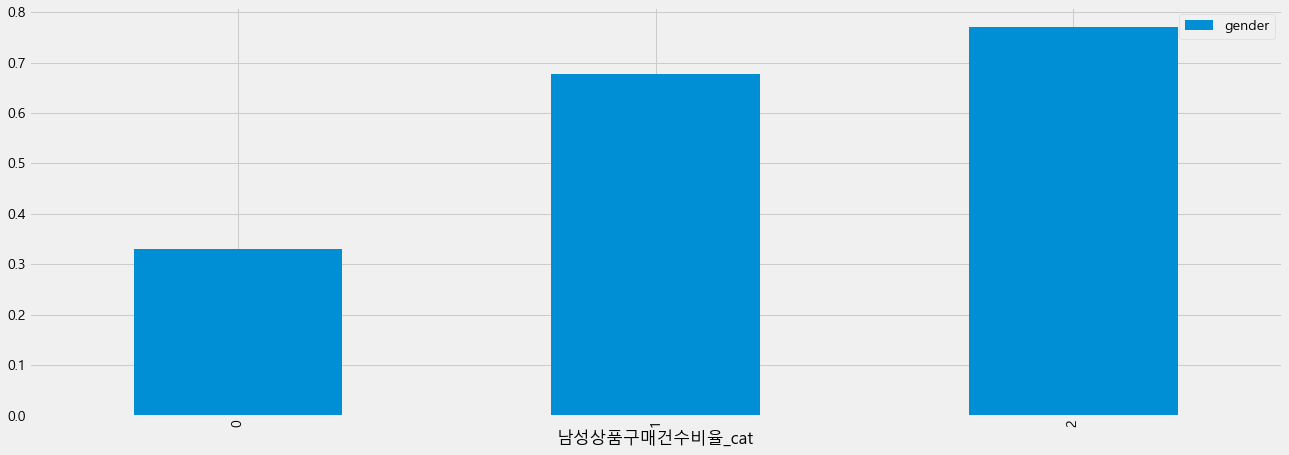

In [224]:
train[['남성상품구매건수비율_cat','gender']].groupby(['남성상품구매건수비율_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [225]:
test['남성상품구매건수비율_cat'] = 0
test.loc[test['남성상품구매건수비율']<=0.2,'남성상품구매건수비율_cat'] = 0
test.loc[(test['남성상품구매건수비율']>0.2) & (test['남성상품구매건수비율']<=0.4),'남성상품구매건수비율_cat'] = 1
test.loc[test['남성상품구매건수비율']>0.4,'남성상품구매건수비율_cat'] = 2
test = test.drop(columns='남성상품구매건수비율')

In [226]:
train['여성상품구매건수비율2'] = pd.qcut(train['여성상품구매건수비율'], 7)
train.groupby(['여성상품구매건수비율2'])['gender'].mean().to_frame().style.background_gradient(cmap='bwr_r')

,gender
여성상품구매건수비율2,
"(-0.001, 0.0712]",0.694000
"(0.0712, 0.227]",0.564870
"(0.227, 0.333]",0.412646
"(0.333, 0.405]",0.251256
"(0.405, 0.5]",0.248162
"(0.5, 0.667]",0.172917
"(0.667, 1.0]",0.252101


In [227]:
train['여성상품구매건수비율_cat'] = 0
train.loc[train['여성상품구매건수비율']<=0.0712,'여성상품구매건수비율_cat'] = 0
train.loc[(train['여성상품구매건수비율']>0.0712) & (train['여성상품구매건수비율']<=0.227),'여성상품구매건수비율_cat'] = 1
train.loc[(train['여성상품구매건수비율']>0.227) & (train['여성상품구매건수비율']<=0.333),'여성상품구매건수비율_cat'] = 2
train.loc[(train['여성상품구매건수비율']>0.333) & (train['여성상품구매건수비율']<=0.405),'여성상품구매건수비율_cat'] = 3
train.loc[(train['여성상품구매건수비율']>0.405) & (train['여성상품구매건수비율']<=0.5),'여성상품구매건수비율_cat'] = 4
train.loc[(train['여성상품구매건수비율']>0.5) & (train['여성상품구매건수비율']<=0.667),'여성상품구매건수비율_cat'] = 5
train.loc[train['여성상품구매건수비율']>0.667,'여성상품구매건수비율_cat'] = 6
train = train.drop(columns=["여성상품구매건수비율",'여성상품구매건수비율2'])

In [228]:
train.groupby('여성상품구매건수비율_cat')['gender'].agg([('트랜잭션건수',np.size)]).reset_index()

,여성상품구매건수비율_cat,트랜잭션건수
0,0,500
1,1,498
2,2,499
3,3,501
4,4,546
5,5,480
6,6,476


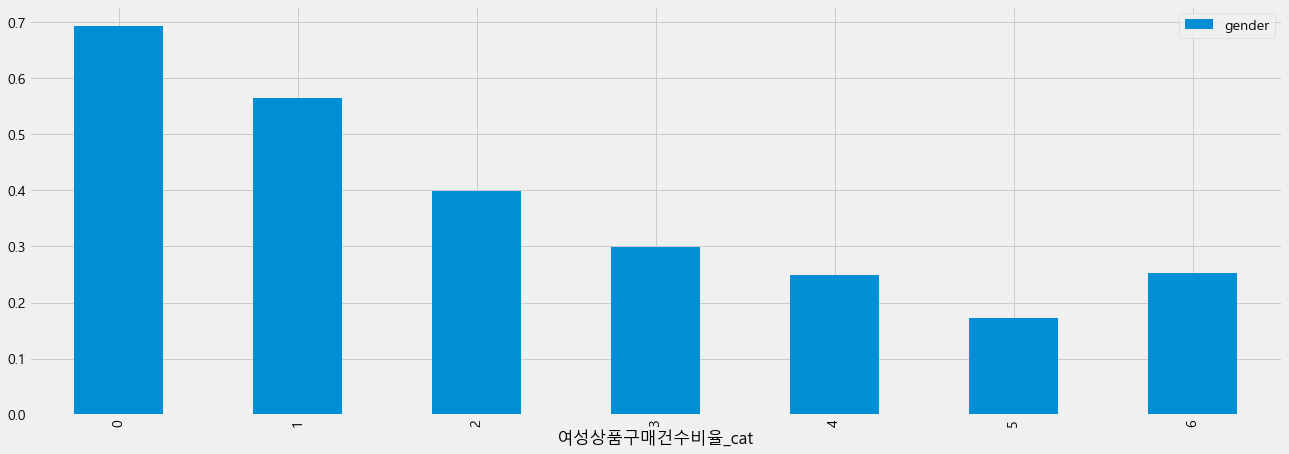

In [229]:
train[['여성상품구매건수비율_cat','gender']].groupby(['여성상품구매건수비율_cat']).mean().plot.bar(figsize=(20,7))
plt.show()

In [230]:
test['여성상품구매건수비율_cat'] = 0
test.loc[test['여성상품구매건수비율']<=0.0712,'여성상품구매건수비율_cat'] = 0
test.loc[(test['여성상품구매건수비율']>0.0712) & (test['여성상품구매건수비율']<=0.227),'여성상품구매건수비율_cat'] = 1
test.loc[(test['여성상품구매건수비율']>0.227) & (test['여성상품구매건수비율']<=0.333),'여성상품구매건수비율_cat'] = 2
test.loc[(test['여성상품구매건수비율']>0.333) & (test['여성상품구매건수비율']<=0.405),'여성상품구매건수비율_cat'] = 3
test.loc[(test['여성상품구매건수비율']>0.405) & (test['여성상품구매건수비율']<=0.5),'여성상품구매건수비율_cat'] = 4
test.loc[(test['여성상품구매건수비율']>0.5) & (test['여성상품구매건수비율']<=0.667),'여성상품구매건수비율_cat'] = 5
test.loc[test['여성상품구매건수비율']>0.667,'여성상품구매건수비율_cat'] = 6
test = test.drop(columns="여성상품구매건수비율")

### Correlation among Features

* 일부 feature들 사이의 상관관계가 높게 드러나는 경우, feature interaction engineering를 수행 후 삭제하였다. (Continuous)

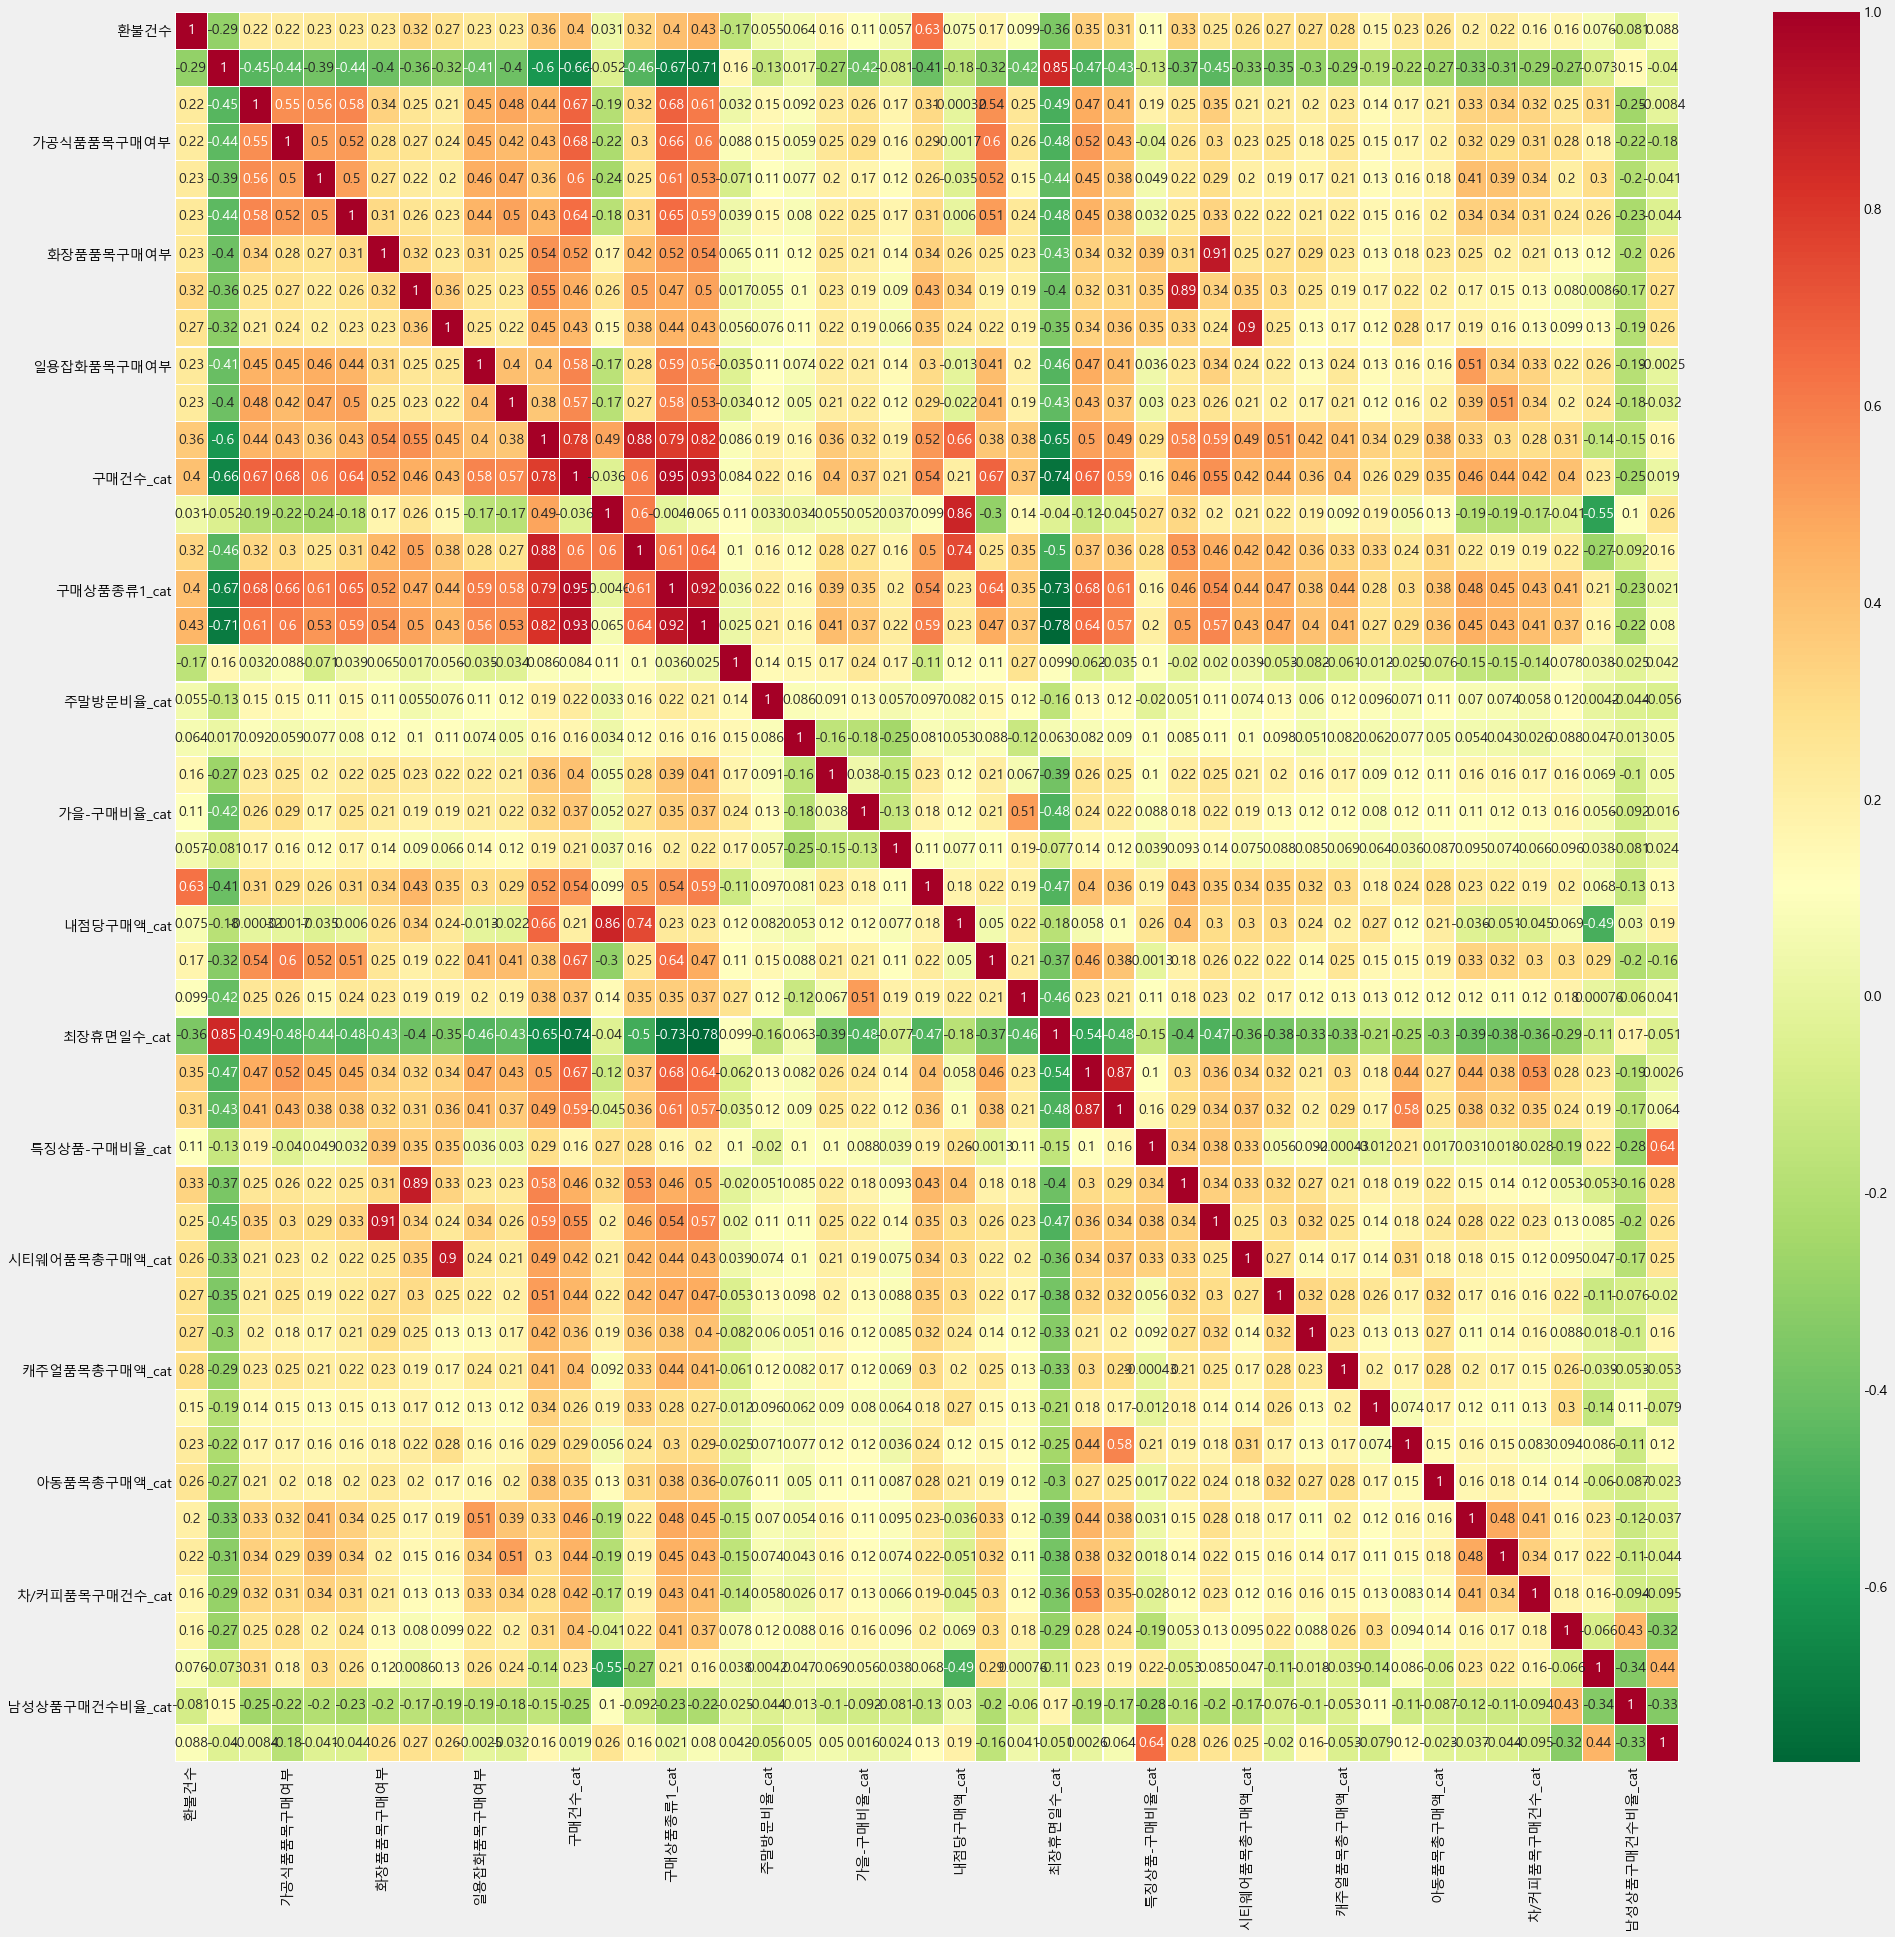

In [231]:
target_corr = list(train.columns[1:13])+list(train.columns[20:])
sns.heatmap(train[target_corr].corr(),annot=True,cmap='RdYlGn_r',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(30,30)
plt.show()

# Part 2. Feature Engineering and Data Cleaning

* 지금까지 분석한 결과를 토대로, 필요한 경우, feature들을 재가공하거나 상관관계가 0.7이상인 피쳐들은 삭제하였다.

In [232]:
train = train.drop(columns='gender')
train_test = pd.concat([train, test])
train_test.to_csv('Raw_feature_labelencoding+categorical_before_Encoding.csv',encoding='cp949')

## Data Cleaning

In [233]:
target_to_remove = ['휴면(이탈)여부','화장품품목구매여부', '디자이너품목구매여부', '시티웨어품목구매여부','구매상품종류1_cat', '내점일수_cat',
                   '총구매액_cat','최대구매액_cat','내점당구매액_cat','행사상품구매총액_cat']
train_test = train_test.drop(columns = target_to_remove)

In [234]:
train_test.to_csv('Raw_feature_labelencoding+categorical_before_Encoding_cleansed.csv',encoding='cp949')